In [ ]:
pip install python-dateutil

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM, GRU, Bidirectional
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from datetime import timedelta
from tqdm import tqdm
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import pywt
import pandas_datareader.data as web
import plotly.express as px
import plotly.graph_objects as go
import datetime 
from pandas.tseries.offsets import CustomBusinessDay, DateOffset, WeekOfMonth
from pandas.tseries.holiday import sunday_to_monday, AbstractHolidayCalendar, Holiday, USMemorialDay, USLaborDay, USColumbusDay, USThanksgivingDay
import math
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import string
from datetime import date
from dateutil.relativedelta import relativedelta

warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(20, 7)})

# I. Study of the data

## 1. Data processing

In [ ]:
# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()

drive = GoogleDrive(gauth)

In [ ]:
# Load dataset from google drive
id = '1hkdyEgTcenZr3_jIYdzWEYMxht6Y8q0P'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Perf vol revisionMarks.xlsm')  


In [ ]:
df_cours = pd.read_excel("Perf vol revisionMarks.xlsm", header=1, sheet_name = 'Cours')
df_cours.set_index('Date', inplace = True, drop = True)
#Pour avoir la même taille que df_vol
df_cours = df_cours[:-1]

df_vol = pd.read_excel("Perf vol revisionMarks.xlsm", header=1, sheet_name = 'Volatilité')
df_vol.set_index('Date', inplace = True, drop = True)

df_marksup = pd.read_excel("Perf vol revisionMarks.xlsm", header=1, sheet_name = 'MarksUP')
df_marksup.set_index('Date', inplace = True, drop = True)
df_marksup['Weekday'] = df_marksup.index.dayofweek
df_marksup = df_marksup[df_marksup.Weekday <= 4]
del df_marksup['Weekday']

df_marksdn = pd.read_excel("Perf vol revisionMarks.xlsm", header=1, sheet_name = 'MarksDN')
df_marksdn.set_index('Date', inplace = True, drop = True)
df_marksdn['Weekday'] = df_marksdn.index.dayofweek
df_marksdn = df_marksdn[df_marksdn.Weekday <= 4]
del df_marksdn['Weekday']

Les dataframes des markups contiennent 3985 lignes en tout. Une bonne dizaine de colonnes de ces dataframes ont la moitié (voire plus) de leurs entrées qui sont des **NaN**. On a parfois des colonnes avec que 900 entrées contenant des markups, le reste étant des entrées inconnues. On peut par conséquent choisir de ne travailler qu'avec les colonnes ayant le moins de valeurs manquantes possibles.

In [ ]:
df_marksdn

,GLANBIA PLC,GRIFOLS SA,PUMA SE,SHOP APOTHEKE EU,AMUNDI SA,SARTORIUS AG-PFD,ATLANTIA SPA,BIOMERIEUX,HERMES INTL,EUROFINS SCIEN,SARTORIUS STEDIM,CARL ZEISS ME-BR,L'OREAL,CORBION NV,ANDRITZ AG,SIEMENS GAMESA R,IBERDROLA SA,SOFINA,HELLOFRESH SE,KONINKLIJKE PHIL,DELIVERY HERO SE,LEGRAND SA,INPOST SA,ADIDAS AG,EVOTEC SE,EIFFAGE,VALMET OYJ,KERRY GROUP-A,RWE AG,IMCD NV,TELEPERFORMANCE,KERING,ARGENX SE,SIGNIFY NV,ACCIONA SA,NEMETSCHEK SE,ANHEUSER-BUSCH I,LA FRANCAISE DES,WARTSILA OYJ ABP,EDP,...,POSTE ITALIANE,VOPAK,CAIXABANK SA,UNITED INTERN-RE,OMV AG,EVONIK INDUSTRIE,INTESA SANPAOLO,WORLDLINE,NN GROUP,TOTAL SE,SOC GENERALE SA,DAIMLER AG,PRYSMIAN SPA,ENI SPA,COMMERZBANK,GALP ENERGIA,SCOR SE,THYSSENKRUPP AG,AEGON NV,SBM OFFSHORE NV,GERRESHEIMER AG,CTS EVENTIM AG &,BANCO BPM SPA,RATIONAL AG,RYANAIR HLDGS,STELLANTIS NV,COVESTRO AG,ROYAL DUTCH SH-A,FAURECIA,DEUTSCHE LUFT-RG,MICHELIN,SMURFIT KAPPA GR,TENARIS SA,REPSOL SA,VALEO SA,TELECOM ITALIA S,KESKO OYJ-B,LANXESS AG,UNICREDIT SPA,RENAULT SA
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2006-01-02,0,NaN,2,NaN,NaN,0,0,0,0,0,1,1,0,1,0,1.0,2,0.0,NaN,14,NaN,NaN,NaN,0,0,0,NaN,0,2,NaN,1,0,NaN,NaN,0,0,3,NaN,0,4,...,NaN,0,NaN,2,1,NaN,4,NaN,NaN,2,0,1,NaN,3,3,NaN,1,3,1,1,NaN,0,NaN,0,2,NaN,NaN,15,7,2,4,NaN,0,1,1,0,1,3,5,2
2006-01-03,0,NaN,2,NaN,NaN,0,1,0,0,0,0,1,0,1,0,1.0,1,0.0,NaN,14,NaN,NaN,NaN,0,0,0,NaN,0,3,NaN,1,1,NaN,NaN,0,0,4,NaN,0,4,...,NaN,0,NaN,2,1,NaN,5,NaN,NaN,2,0,1,NaN,4,3,NaN,1,2,1,1,NaN,0,NaN,0,2,NaN,NaN,15,7,2,4,NaN,0,1,2,1,1,3,7,1
2006-01-04,0,NaN,2,NaN,NaN,0,1,0,0,0,0,1,0,1,0,2.0,1,0.0,NaN,14,NaN,NaN,NaN,0,0,0,NaN,0,4,NaN,1,1,NaN,NaN,0,0,5,NaN,0,4,...,NaN,0,NaN,2,2,NaN,5,NaN,NaN,2,0,1,NaN,4,3,NaN,1,2,1,0,NaN,0,NaN,0,2,NaN,NaN,15,7,2,3,NaN,0,1,2,1,1,3,7,1
2006-01-05,0,NaN,2,NaN,NaN,0,1,0,0,0,0,1,0,1,0,2.0,1,0.0,NaN,12,NaN,NaN,NaN,0,0,0,NaN,0,4,NaN,0,1,NaN,NaN,0,0,5,NaN,0,3,...,NaN,0,NaN,2,2,NaN,5,NaN,NaN,2,0,1,NaN,4,3,NaN,1,2,2,0,NaN,0,NaN,0,3,NaN,NaN,15,7,2,3,NaN,0,1,2,1,1,3,7,1
2006-01-06,0,NaN,2,NaN,NaN,0,1,0,0,0,0,1,1,1,0,2.0,1,0.0,NaN,12,NaN,NaN,NaN,0,0,1,NaN,0,8,NaN,0,2,NaN,NaN,1,0,6,NaN,0,3,...,NaN,0,NaN,2,3,NaN,5,NaN,NaN,1,0,1,NaN,4,2,NaN,1,3,1,1,NaN,0,NaN,0,4,NaN,NaN,16,8,2,4,NaN,0,2,2,1,1,4,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-05,0,6.0,0,3.0,0.0,0,4,0,1,2,0,1,1,2,0,3.0,3,NaN,1.0,0,5.0,1.0,1.0,24,4,0,0.0,2,10,0.0,0,1,1.0,1.0,1,9,5,0.0,0,4,...,2.0,2,1.0,2,1,4.0,2,3.0,1.0,0,0,1,11.0,2,0,1.0,2,2,1,1,3.0,1,2.0,2,5,2.0,2.0,1,4,4,1,1.0,0,0,3,1,0,7,3,1
2021-04-06,0,6.0,0,2.0,0.0,0,4,0,3,2,0,1,1,0,0,2.0,3,NaN,1.0,0,5.0,1.0,1.0,23,4,0,0.0,1,10,0.0,0,1,1.0,1.0,1,9,9,0.0,0,4,...,2.0,2,1.0,2,1,3.0,2,4.0,0.0,0,0,1,11.0,2,0,1.0,2,2,1,0,3.0,1,2.0,2,5,2.0,3.0,2,4,4,1,1.0,0,0,3,1,0,7,3,1
2021-04-07,0,4.0,0,2.0,0.0,0,4,0,3,2,0,1,1,0,0,1.0,3,NaN,1.0,0,5.0,2.0,1.0,16,4,0,0.0,1,10,0.0,0,1,1.0,1.0,1,9,9,0.0,0,4,...,2.0,2,1.0,2,1,3.0,1,4.0,0.0,0,1,1,10.0,2,0,1.0,2,2,1,0,3.0,1,1.0,2,8,1.0,3.0,4,4,4,1,1.0,0,0,3,1,0,7,2,1


In [ ]:
df_marksup.describe()

,GLANBIA PLC,GRIFOLS SA,PUMA SE,SHOP APOTHEKE EU,AMUNDI SA,SARTORIUS AG-PFD,ATLANTIA SPA,BIOMERIEUX,HERMES INTL,EUROFINS SCIEN,SARTORIUS STEDIM,CARL ZEISS ME-BR,L'OREAL,CORBION NV,ANDRITZ AG,SIEMENS GAMESA R,IBERDROLA SA,SOFINA,HELLOFRESH SE,KONINKLIJKE PHIL,DELIVERY HERO SE,LEGRAND SA,INPOST SA,ADIDAS AG,EVOTEC SE,EIFFAGE,VALMET OYJ,KERRY GROUP-A,RWE AG,IMCD NV,TELEPERFORMANCE,KERING,ARGENX SE,SIGNIFY NV,ACCIONA SA,NEMETSCHEK SE,ANHEUSER-BUSCH I,LA FRANCAISE DES,WARTSILA OYJ ABP,EDP,...,POSTE ITALIANE,VOPAK,CAIXABANK SA,UNITED INTERN-RE,OMV AG,EVONIK INDUSTRIE,INTESA SANPAOLO,WORLDLINE,NN GROUP,TOTAL SE,SOC GENERALE SA,DAIMLER AG,PRYSMIAN SPA,ENI SPA,COMMERZBANK,GALP ENERGIA,SCOR SE,THYSSENKRUPP AG,AEGON NV,SBM OFFSHORE NV,GERRESHEIMER AG,CTS EVENTIM AG &,BANCO BPM SPA,RATIONAL AG,RYANAIR HLDGS,STELLANTIS NV,COVESTRO AG,ROYAL DUTCH SH-A,FAURECIA,DEUTSCHE LUFT-RG,MICHELIN,SMURFIT KAPPA GR,TENARIS SA,REPSOL SA,VALEO SA,TELECOM ITALIA S,KESKO OYJ-B,LANXESS AG,UNICREDIT SPA,RENAULT SA
count,3985.000000,3974.000000,3985.000000,1145.000000,1408.00000,3985.000000,3985.000000,3985.000000,3985.000000,3985.000000,3985.000000,3985.000000,3985.000000,3985.000000,3985.000000,3614.000000,3985.000000,1785.000000,870.000000,3985.000000,960.000000,3913.000000,32.000000,3985.000000,3985.000000,3985.000000,1906.000000,3985.000000,3985.000000,1742.000000,3985.000000,3985.000000,1734.000000,1271.000000,3985.000000,3985.000000,3985.000000,258.000000,3985.000000,3985.000000,...,1398.000000,3985.000000,2634.000000,3985.000000,3985.000000,2077.000000,3985.000000,1763.000000,1762.000000,3985.000000,3985.000000,3985.000000,3612.000000,3985.000000,3985.000000,3744.000000,3985.000000,3985.000000,3985.000000,3985.000000,3574.000000,3985.000000,3632.000000,3985.000000,3985.000000,1697.000000,1413.000000,3985.000000,3985.000000,3985.000000,3985.00000,3665.000000,3985.000000,3985.000000,3985.000000,3985.000000,3985.000000,3985.000000,3985.000000,3985.000000
mean,1.011292,2.444640,2.922208,1.006987,3.96875,1.422083,2.636136,1.856211,4.637139,1.405019,0.978921,1.378670,6.043915,1.479297,2.061731,1.815440,3.045169,0.067227,1.986207,5.280301,1.731250,3.922310,1.250000,5.873275,0.792723,2.426851,3.010493,1.709661,4.254956,1.413892,3.301631,6.155583,0.758362,3.299764,1.840903,0.908407,9.126223,1.782946,3.112673,1.797240,...,1.547210,1.858218,2.105163,2.453701,5.384944,3.759268,2.941531,2.936472,2.570375,13.502886,5.188959,7.239649,2.431340,6.989711,3.957089,4.128472,3.332497,4.243664,3.618319,3.916186,1.651651,0.851192,2.479075,1.415307,5.093350,5.167354,6.169851,15.518444,2.644417,5.080803,3.86675,1.972988,3.930740,7.316688,2.874780,3.048432,2.178921,4.689586,4.765872,3.819573
std,1.433822,2.526941,3.878031,1.512172,3.94459,2.136298,2.455139,2.370258,4.374801,1.910412,1.446349,1.769157,5.884585,2.052801,2.437307,1.950104,2.486907,0.286009,2.283637,5.742157,1.658128,3.728119,1.606439,6.579431,1.072051,2.499745,3.222443,2.207774,3.695452,1.503315,3.554913,5.915434,1.488512,2.707352,1.653092,1.302374,7.177810,2.353774,3.854807,1.538999,...,1.890409,2.243291,2.342321,2.256389,3.211171,3.181234,3.212495,3.143818,2.487193,9.043073,4.555953,7.015011,2.369962,4.883445,4.436173,3.517340,2.960010,3.842285,3.101628,4.232512,2.437653,1.148681,2.398729,2.188968,5.241011,4.413909,5.363239,10.439740,2.891579,4.850889,3.59119,2.171189,3.754946,4.485148,3.165551,2.481035,2.814880,4.823986,4.386926,3.562455
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

In [ ]:
describe_to_df = df_marksup.describe()
get_count = describe_to_df.loc['count']

In [ ]:
my_dict = dict(get_count)
column_to_drop = dict()
somme = 0
for key, value in my_dict.items():
  if value < len(df_marksup):
    somme += value
    column_to_drop[key] = value

In [ ]:
mean = somme/len(column_to_drop)
print('Il n\'y a en moyenne que {} markups observées sur les {} au total'.format(int(mean), len(df_marksdn)))

Il n'y a en moyenne que 2154 markups observées sur les 3985 au total


In [ ]:
print('Il y a {} colonnes ayant des valeurs manquantes'.format(len(column_to_drop)))

Il y a 84 colonnes ayant des valeurs manquantes


On peut donc décider de travailler avec les entreprises ayant tour leur markups. On passera alors de **291** entreprises à **207**. Ce qui demeure tout à fait pertinent.

In [ ]:
def remove_columns(cours, volatilite, up, down, col_list):
  cours_df = cours.drop(columns=col_list)
  vol_df = volatilite.drop(columns=col_list)
  up_df = up.drop(columns=col_list)
  down_df = down.drop(columns=col_list)
  return cours_df, vol_df, up_df, down_df

In [ ]:
df_stock_price, df_volatility, marks_UP, marks_DOWN = remove_columns(df_cours, df_vol, df_marksup, df_marksdn, column_to_drop.keys())

In [ ]:
stock_list = marks_UP.columns.to_list()

In [ ]:
def check_if_weekend(date):
  if date.dayofweek ==5:
    return "Saturday"
  elif date.dayofweek == 6:
    return "Sunday"

In [ ]:
class Performance():
  def __init__(self, stock_name, marks_UP, marks_DOWN, df_volatility, df_stock_price):
    self.stock_name = stock_name
    self.marks_UP = marks_UP
    self.marks_DOWN = marks_DOWN
    self.df_volatility = df_volatility
    self.df_stock_price = df_stock_price

  
  def performance_indicator(self):
    self.last_index = self.marks_UP.index[-2] + relativedelta(months=-6)
    self.df_performance = pd.DataFrame(index=self.marks_UP.index)
    self.df_performance = self.df_performance.loc[:self.last_index]
    self.df_performance.columns.names = [self.stock_name]
    self.df_performance['MarksUP'] = self.marks_UP.loc[:self.last_index][self.stock_name]
    self.df_performance['MarksDown'] = self.marks_DOWN.loc[:self.last_index][self.stock_name]
    self.df_performance['Volatility'] = self.df_volatility.loc[self.marks_UP.index[0]:self.last_index][self.stock_name]
    self.df_performance['Current_stock'] = self.df_stock_price.loc[self.marks_UP.index[0]:self.last_index][self.stock_name]
    return self.df_performance



def get_stock_and_date(stock, timestep, name):
  """
  Cette fonction permet de recupérer les cours 1, 2, 3 et 12 mois ainsi que les dates correspondantes
  """
  l, m = [], []
  for i in range(len(stock)):
    timestep_month = stock.index[i] + relativedelta(months=-timestep)
    if check_if_weekend(timestep_month)== 'Saturday':
      timestep_month += relativedelta(days=-1)
      timestep_value = df_stock_price.loc[timestep_month][name]
      l.append(timestep_month)
      m.append(timestep_value)
    elif check_if_weekend(timestep_month)== 'Sunday':
      timestep_month += relativedelta(days=-2)
      timestep_value = df_stock_price.loc[timestep_month][name]
      l.append(timestep_month)
      m.append(timestep_value)
    else:
      timestep_value = df_stock_price.loc[timestep_month][name]
      l.append(timestep_month)
      m.append(timestep_value)
  return l, m

def perf_indicator_without_zeros(df, col_list):
  for col in col_list:
    df = df[df[col]!=0]
  return df

In [ ]:
def append_stock_value_to_df(stock_name, marks_UP, marks_DOWN, df_volatility, df_stock_price, timestep_list):
  perf = Performance(stock_name, marks_UP, marks_DOWN, df_volatility, df_stock_price)
  dataframe = perf.performance_indicator()
  for t in timestep_list[:-1]:
    previous_date, previous_value = get_stock_and_date(dataframe, t, stock_name)
    dataframe['Prev_' + str(t) + 'month'], dataframe[str(t) + 'month'] = previous_date, previous_value
  next_6_months, next_6_months_value = get_stock_and_date(dataframe, timestep_list[-1], stock_name)
  dataframe['Next_6month'], dataframe['+6months'] = next_6_months, next_6_months_value
  return dataframe

In [ ]:
timestep_list = [1, 3, 6, 12, -6]
stock_name = stock_list[0]
df = append_stock_value_to_df(stock_name, marks_UP, marks_DOWN, df_volatility, df_stock_price, timestep_list)
col_list = ['Current_stock', '1month', '3month', '6month', '12month','+6months']
non_zeros = perf_indicator_without_zeros(df, col_list)

In [ ]:
df

In [ ]:
non_zeros.head()

GLANBIA PLC,MarksUP,MarksDown,Volatility,Current_stock,Prev_1month,1month,Prev_3month,3month,Prev_6month,6month,Prev_12month,12month,Next_6month,+6months
Date,,,,,,,,,,,,,,
2006-01-04,0,0,25.766,2.46,2005-12-02,2.53,2005-10-04,2.52,2005-07-04,2.89,2005-01-04,2.82,2006-07-04,2.27
2006-01-05,0,0,25.884,2.52,2005-12-05,2.50,2005-10-05,2.55,2005-07-05,2.86,2005-01-05,2.86,2006-07-05,2.25
2006-01-06,0,0,25.959,2.47,2005-12-06,2.55,2005-10-06,2.60,2005-07-06,2.83,2005-01-06,2.92,2006-07-06,2.25
2006-01-09,0,0,26.041,2.52,2005-12-09,2.51,2005-10-07,2.70,2005-07-08,2.85,2005-01-07,3.00,2006-07-07,2.29
2006-01-10,0,0,26.088,2.48,2005-12-09,2.51,2005-10-10,2.67,2005-07-08,2.85,2005-01-10,2.96,2006-07-10,2.27


In [ ]:
def compute_performance_indicator(dataframe, col_list):
  for col in col_list[1:-1]:
    dataframe['Perf_' + col] = dataframe[col_list[0]]/dataframe[col] - 1
  dataframe['Perf_' + col_list[-1]] = dataframe[col_list[-1]]/dataframe[col_list[0]] - 1
  return dataframe

In [ ]:
final_data = compute_performance_indicator(non_zeros, col_list)

In [ ]:
def extract_columns_for_lstm(df, columns):
  df = df[columns]
  return df

In [ ]:
lstm_df_cols = ['Volatility','MarksUP', 'MarksDown', 'Perf_1month',	'Perf_3month',	'Perf_6month',	'Perf_12month',	'Perf_+6months', 'Next_6month']
lstm_df = extract_columns_for_lstm(final_data, lstm_df_cols)

In [ ]:
lstm_df

GLANBIA PLC,Volatility,MarksUP,MarksDown,Perf_1month,Perf_3month,Perf_6month,Perf_12month,Perf_+6months,Next_6month
Date,,,,,,,,,
2006-01-04,25.766,0,0,-0.027668,-0.023810,-0.148789,-0.127660,-0.077236,2006-07-04
2006-01-05,25.884,0,0,0.008000,-0.011765,-0.118881,-0.118881,-0.107143,2006-07-05
2006-01-06,25.959,0,0,-0.031373,-0.050000,-0.127208,-0.154110,-0.089069,2006-07-06
2006-01-09,26.041,0,0,0.003984,-0.066667,-0.115789,-0.160000,-0.091270,2006-07-07
2006-01-10,26.088,0,0,-0.011952,-0.071161,-0.129825,-0.162162,-0.084677,2006-07-10
...,...,...,...,...,...,...,...,...,...
2020-09-30,44.108,1,3,-0.069202,-0.125992,-0.067725,-0.227193,0.450624,2021-03-30
2020-10-01,44.102,1,4,-0.071354,-0.125123,-0.011641,-0.213151,0.420079,2021-04-01
2020-10-06,44.115,2,4,-0.081976,-0.146139,0.091875,-0.244377,0.450487,2021-04-06


Some useful function

In [ ]:
def forecasting_performance_measures(expected, predicted, model):
  mae = metrics.mean_absolute_error(expected, predicted)
  medae = metrics.median_absolute_error(expected, predicted)
  mse = metrics.mean_squared_error(expected, predicted)
  rmse = math.sqrt(mse)
  return pd.DataFrame({'MAE' : mae, 'MEDAE' : medae, 'MSE' : mse, 'RMSE' : rmse}, index = [model])

## Work in progress


In [ ]:
def create_data(X):
  X_lagged, Y_lagged = [], []
  for i in range(len(X)):
    up = X['MarksUP'][i]
    down = X['MarksDown'][i]
    vol = X['Volatility'][i]
    one_month = X['Perf_1month'][i]
    three_month = X['Perf_3month'][i]
    six_month = X['Perf_6month'][i]
    twelve_month = X['Perf_12month'][i]
    target = X['Perf_+6months'][i]
    stacked_col = np.column_stack((up, down, vol, one_month, three_month, six_month, twelve_month))
    X_lagged.append(stacked_col)
    Y_lagged.append(target)
  return np.array(X_lagged), np.array(Y_lagged)

In [ ]:
def train_test_split(df, split):
  len_train = int(split*len(df))
  train_set, test_set = df[:len_train], df[len_train:]
  train_x, train_y = create_data(train_set)
  test_x, test_y = create_data(test_set)
  return train_x, train_y, test_x, test_y, train_set, test_set

In [ ]:
X_train , Y_train, X_test , Y_test, train, test = train_test_split(lstm_df, 0.8)

In [ ]:
# Create LSTM or GRU model
def baseline_model(shape):
  model = Sequential()
  model.add(LSTM(units = 128, input_shape = (shape[1], shape[2]))) 
  model.add(Dropout(0.2))
  model.add(Dense(units = 100))
  model.add(Dropout(0.2))
  model.add(Dense(units = 100))
  model.add(Dropout(0.1))
  model.add(Dense(units = 1, activation = 'linear'))
  model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
  return model

def gru_model(shape):
  model = Sequential()
  model.add(GRU(units = 128, input_shape = (shape[1], shape[2]))) 
  model.add(Dropout(0.2))
  model.add(Dense(units = 100))
  model.add(Dropout(0.2))
  model.add(Dense(units = 100))
  model.add(Dropout(0.1))
  model.add(Dense(units = 1, activation = 'linear'))
  model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
  return model

# Create BiLSTM model
def bidirectional_lstm_model(shape, units):
    model = Sequential()
    model.add(Bidirectional(LSTM(units = units,                             
              return_sequences=True),
              input_shape=(shape[1], shape[2])))
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dense(1))
    #Compile model
    model.compile(loss='mse', optimizer='adam',  metrics=['mse','mae'])
    return model

In [ ]:
def fit_model(model, epochs, batch_size, X_train, X_test, Y_train, Y_test):
  callbacks = [
    EarlyStopping(monitor="val_loss", patience=3, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model.h5', verbose=1, save_best_only=True, save_weights_only=True)]
  history = model.fit(X_train, Y_train, epochs = epochs, batch_size = batch_size, validation_data = (X_test, Y_test))
  return history

In [ ]:
batch_size = 32
epochs = 12

model_bilstm = bidirectional_lstm_model(X_train.shape, 128)
model_lstm = baseline_model(X_train.shape)
model_gru = gru_model(X_train.shape)


In [ ]:
#fitted_bilstm = fit_model(model_bilstm, epochs, batch_size, X_train, X_test, Y_train, Y_test)
#print('------------------------------------------------------------------------------')
fitted_lstm = fit_model(model_lstm, epochs, batch_size, X_train, X_test, Y_train, Y_test)
print('------------------------------------------------------------------------------')
fitted_gru = fit_model(model_gru, epochs, batch_size, X_train, X_test, Y_train, Y_test)

Epoch 1/12
83/83 [==============================] - 4s 17ms/step - loss: 0.1532 - mse: 0.1532 - mae: 0.3016 - val_loss: 0.0407 - val_mse: 0.0407 - val_mae: 0.1510
Epoch 2/12
83/83 [==============================] - 0s 5ms/step - loss: 0.0526 - mse: 0.0526 - mae: 0.1779 - val_loss: 0.0459 - val_mse: 0.0459 - val_mae: 0.1639
Epoch 3/12
83/83 [==============================] - 0s 5ms/step - loss: 0.0468 - mse: 0.0468 - mae: 0.1664 - val_loss: 0.0405 - val_mse: 0.0405 - val_mae: 0.1521
Epoch 4/12
83/83 [==============================] - 0s 5ms/step - loss: 0.0474 - mse: 0.0474 - mae: 0.1679 - val_loss: 0.0418 - val_mse: 0.0418 - val_mae: 0.1558
Epoch 5/12
83/83 [==============================] - 0s 5ms/step - loss: 0.0450 - mse: 0.0450 - mae: 0.1645 - val_loss: 0.0519 - val_mse: 0.0519 - val_mae: 0.1782
Epoch 6/12
83/83 [==============================] - 0s 5ms/step - loss: 0.0436 - mse: 0.0436 - mae: 0.1603 - val_loss: 0.0388 - val_mse: 0.0388 - val_mae: 0.1526
Epoch 7/12
83/83 [=========

In [ ]:
# Plot train loss and validation loss
def plot_loss(history):
    plt.figure(figsize=(10, 4))
    plt.plot(history.epoch, history.history['loss'], lw=3, label='Training')
    plt.plot(history.epoch, history.history['val_loss'], lw=3, label='Testing')
    plt.title('Loss as a function of epoch', fontsize=16)
    plt.ylabel('Loss', fontsize=14)
    plt.xlabel('epoch', fontsize=14)
    plt.tight_layout()
    plt.legend(['Train loss', 'Validation loss'], loc='upper right', fontsize=14)

# Plot true future vs prediction
def plot_future(prediction, y_test):
    plt.figure(figsize=(10, 4))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), y_test, 
             label='Real performance')     
    plt.plot(np.arange(range_future),prediction,
            label='Prediction')
    plt.title('Stock +6 months performance', fontsize=16)
    plt.xlabel('Time (day)')
    plt.ylabel('+6 months')
    plt.legend(['True', 'Pred'], loc='upper left', fontsize=10)


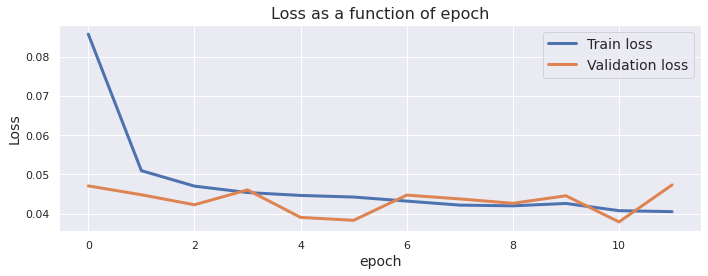

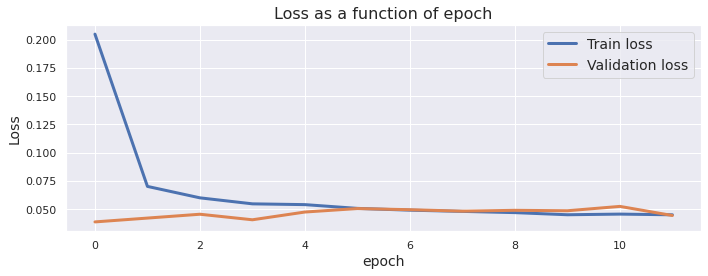

In [ ]:
#plt.subplot(3, 1, 1)
#plot_loss(fitted_bilstm)
#plt.subplot(3, 1, 2)
plot_loss(fitted_lstm)
#plt.subplot(3, 1, 3)
plot_loss(fitted_gru)

In [ ]:
#predicted_bilstm = np.hstack(model_bilstm.predict(X_test))
predicted_lstm = np.hstack(model_lstm.predict(X_test))
predicted_gru = np.hstack(model_gru.predict(X_test))
observed = Y_test

In [ ]:
#bi_lstm_metrics = forecasting_performance_measures(observed,predicted_bilstm, "BI_LSTM")
lstm_metrics = forecasting_performance_measures(observed,predicted_lstm, "LSTM")
gru_metrics = forecasting_performance_measures(observed,predicted_gru, "GRU")

lstm_metrics = lstm_metrics.append(gru_metrics)
#lstm_metrics = lstm_metrics.append(bi_lstm_metrics)
lstm_metrics

,MAE,MEDAE,MSE,RMSE
LSTM,0.174590,0.136998,0.047296,0.217476
GRU,0.163357,0.117839,0.044314,0.210509


In [ ]:
#plot_future(predicted_bilstm, observed)

#plot_future(predicted_lstm, observed)

#plot_future(predicted_gru, observed)

In [ ]:
test["Perf_+6months"]

Date
2017-11-15   -0.129630
2017-11-16   -0.121391
2017-11-17   -0.092048
2017-11-20   -0.077116
2017-11-21   -0.075371
                ...   
2020-09-30    0.450624
2020-10-01    0.420079
2020-10-06    0.450487
2020-10-07    0.497083
2020-10-08    0.544883
Name: Perf_+6months, Length: 661, dtype: float64

In [ ]:
def get_all_performance(stock_list, col_list, timestep_list, lstm_df_cols, split=0.8):
  for stock in tqdm(stock_list):
    stock_df = append_stock_value_to_df(stock, marks_UP, marks_DOWN, df_volatility, df_stock_price, timestep_list)
    stock_df_non_zeros = perf_indicator_without_zeros(stock_df, col_list)
    stock_performance = compute_performance_indicator(stock_df_non_zeros, col_list)
    stock_extract_performance = extract_columns_for_lstm(stock_performance, lstm_df_cols)
    x_train , y_train, x_test , y_test, train_df, test_df = train_test_split(stock_extract_performance, split)
    
    dd = pd.DataFrame()
    dd["Actual_perf" ] = test_df['Perf_+6months']
    dd["+6_" + stock] = test_df['Next_6month']
    
    #Save prediction in a dataframe

    with pd.ExcelWriter('Actual_performance.xlsx', engine='openpyxl', mode='a') as writer: 
      dd.to_excel(writer, sheet_name=stock.translate(str.maketrans('', '', string.punctuation)))

In [ ]:
get_all_performance(stock_list, col_list, timestep_list, lstm_df_cols, split=0.8)

100%|██████████| 207/207 [51:40<00:00, 14.98s/it]


In [ ]:
def get_all_performance(stock_list, col_list, timestep_list, lstm_df_cols, batch_size, epochs, split=0.8):
  for stock in tqdm(stock_list):
    stock_df = append_stock_value_to_df(stock, marks_UP, marks_DOWN, df_volatility, df_stock_price, timestep_list)
    stock_df_non_zeros = perf_indicator_without_zeros(stock_df, col_list)
    stock_performance = compute_performance_indicator(stock_df_non_zeros, col_list)
    stock_extract_performance = extract_columns_for_lstm(stock_performance, lstm_df_cols)
    x_train , y_train, x_test , y_test, train_df, test_df = train_test_split(stock_extract_performance, split)
    
    dd = pd.DataFrame()
    dd["Actual_" + stock ] = test_df['Perf_+6months']
    dd["+6_" + stock] = test_df['Next_6month']
    
    #Define models
    lstm = baseline_model(x_train.shape)
    gru = gru_model(x_train.shape)

    #Fit model 
    lstm_fit = fit_model(lstm, epochs, batch_size, x_train, x_test, y_train, y_test)
    gru_fit = fit_model(gru, epochs, batch_size, x_train, x_test, y_train, y_test)

    #Make Prediction
    lstm_prediction = np.hstack(lstm.predict(x_test))
    gru_prediction = np.hstack(gru.predict(x_test))
    
    #Save prediction in a dataframe

    #df_final = pd.DataFrame(index=test_df['Next_6month'])
    #df_final['Actual'] = test_df['Perf_+6months']
    dd['LSTM'] = lstm_prediction
    dd['GRU'] = gru_prediction
    with pd.ExcelWriter('Predictions.xlsx', engine='openpyxl', mode='a') as writer: 
      dd.to_excel(writer, sheet_name=stock.translate(str.maketrans('', '', string.punctuation)))

In [ ]:
pd.DataFrame(index=test.index).to_excel("Actual_performance.xlsx")

In [ ]:
get_all_performance(stock_list, col_list, timestep_list, lstm_df_cols, batch_size, epochs, split=0.8)

  0%|          | 0/207 [00:00<?, ?it/s]

Epoch 1/12
83/83 [==============================] - 3s 11ms/step - loss: 0.2121 - mse: 0.2121 - mae: 0.3482 - val_loss: 0.0444 - val_mse: 0.0444 - val_mae: 0.1595
Epoch 2/12
83/83 [==============================] - 0s 4ms/step - loss: 0.0546 - mse: 0.0546 - mae: 0.1817 - val_loss: 0.0423 - val_mse: 0.0423 - val_mae: 0.1536
Epoch 3/12
83/83 [==============================] - 0s 5ms/step - loss: 0.0503 - mse: 0.0503 - mae: 0.1726 - val_loss: 0.0544 - val_mse: 0.0544 - val_mae: 0.1817
Epoch 4/12
83/83 [==============================] - 0s 5ms/step - loss: 0.0487 - mse: 0.0487 - mae: 0.1702 - val_loss: 0.0382 - val_mse: 0.0382 - val_mae: 0.1461
Epoch 5/12
83/83 [==============================] - 0s 5ms/step - loss: 0.0474 - mse: 0.0474 - mae: 0.1681 - val_loss: 0.0418 - val_mse: 0.0418 - val_mae: 0.1571
Epoch 6/12
83/83 [==============================] - 0s 5ms/step - loss: 0.0459 - mse: 0.0459 - mae: 0.1661 - val_loss: 0.0415 - val_mse: 0.0415 - val_mae: 0.1564
Epoch 7/12
83/83 [=========

  0%|          | 1/207 [00:20<1:11:14, 20.75s/it]

Epoch 1/12
84/84 [==============================] - 3s 11ms/step - loss: 0.1055 - mse: 0.1055 - mae: 0.2484 - val_loss: 0.0458 - val_mse: 0.0458 - val_mae: 0.1788
Epoch 2/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0397 - mse: 0.0397 - mae: 0.1477 - val_loss: 0.0341 - val_mse: 0.0341 - val_mae: 0.1503
Epoch 3/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0378 - mse: 0.0378 - mae: 0.1440 - val_loss: 0.0376 - val_mse: 0.0376 - val_mae: 0.1621
Epoch 4/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0364 - mse: 0.0364 - mae: 0.1427 - val_loss: 0.0366 - val_mse: 0.0366 - val_mae: 0.1557
Epoch 5/12
84/84 [==============================] - 0s 4ms/step - loss: 0.0322 - mse: 0.0322 - mae: 0.1341 - val_loss: 0.0400 - val_mse: 0.0400 - val_mae: 0.1674
Epoch 6/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0309 - mse: 0.0309 - mae: 0.1317 - val_loss: 0.0340 - val_mse: 0.0340 - val_mae: 0.1526
Epoch 7/12
84/84 [=========

  1%|          | 2/207 [00:41<1:11:11, 20.83s/it]

Epoch 1/12
84/84 [==============================] - 3s 11ms/step - loss: 0.2053 - mse: 0.2053 - mae: 0.3480 - val_loss: 0.0987 - val_mse: 0.0987 - val_mae: 0.2643
Epoch 2/12
84/84 [==============================] - 0s 5ms/step - loss: 0.1151 - mse: 0.1151 - mae: 0.2668 - val_loss: 0.1337 - val_mse: 0.1337 - val_mae: 0.2942
Epoch 3/12
84/84 [==============================] - 0s 5ms/step - loss: 0.1005 - mse: 0.1005 - mae: 0.2516 - val_loss: 0.1172 - val_mse: 0.1172 - val_mae: 0.2754
Epoch 4/12
84/84 [==============================] - 0s 4ms/step - loss: 0.1068 - mse: 0.1068 - mae: 0.2597 - val_loss: 0.0724 - val_mse: 0.0724 - val_mae: 0.2257
Epoch 5/12
84/84 [==============================] - 0s 4ms/step - loss: 0.0903 - mse: 0.0903 - mae: 0.2382 - val_loss: 0.0895 - val_mse: 0.0895 - val_mae: 0.2419
Epoch 6/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0919 - mse: 0.0919 - mae: 0.2374 - val_loss: 0.1122 - val_mse: 0.1122 - val_mae: 0.2622
Epoch 7/12
84/84 [=========

  1%|▏         | 3/207 [01:03<1:11:27, 21.02s/it]

Epoch 1/12
84/84 [==============================] - 3s 17ms/step - loss: 0.0951 - mse: 0.0951 - mae: 0.2344 - val_loss: 0.0637 - val_mse: 0.0637 - val_mae: 0.2095
Epoch 2/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0356 - mse: 0.0356 - mae: 0.1476 - val_loss: 0.0613 - val_mse: 0.0613 - val_mae: 0.2074
Epoch 3/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0314 - mse: 0.0314 - mae: 0.1379 - val_loss: 0.0535 - val_mse: 0.0535 - val_mae: 0.1937
Epoch 4/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0313 - mse: 0.0313 - mae: 0.1369 - val_loss: 0.0614 - val_mse: 0.0614 - val_mae: 0.2064
Epoch 5/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0289 - mse: 0.0289 - mae: 0.1321 - val_loss: 0.0508 - val_mse: 0.0508 - val_mae: 0.1880
Epoch 6/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0297 - mse: 0.0297 - mae: 0.1343 - val_loss: 0.0561 - val_mse: 0.0561 - val_mae: 0.2004
Epoch 7/12
84/84 [=========

  2%|▏         | 4/207 [01:25<1:12:26, 21.41s/it]

Epoch 1/12
87/87 [==============================] - 3s 11ms/step - loss: 0.0974 - mse: 0.0974 - mae: 0.2390 - val_loss: 0.0516 - val_mse: 0.0516 - val_mae: 0.1813
Epoch 2/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0266 - mse: 0.0266 - mae: 0.1286 - val_loss: 0.0516 - val_mse: 0.0516 - val_mae: 0.1748
Epoch 3/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0231 - mse: 0.0231 - mae: 0.1184 - val_loss: 0.0513 - val_mse: 0.0513 - val_mae: 0.1756
Epoch 4/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0219 - mse: 0.0219 - mae: 0.1171 - val_loss: 0.0516 - val_mse: 0.0516 - val_mae: 0.1760
Epoch 5/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0214 - mse: 0.0214 - mae: 0.1141 - val_loss: 0.0529 - val_mse: 0.0529 - val_mae: 0.1851
Epoch 6/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0195 - mse: 0.0195 - mae: 0.1085 - val_loss: 0.0531 - val_mse: 0.0531 - val_mae: 0.1796
Epoch 7/12
87/87 [=========

  2%|▏         | 5/207 [01:48<1:13:34, 21.86s/it]

Epoch 1/12
87/87 [==============================] - 3s 11ms/step - loss: 0.0933 - mse: 0.0933 - mae: 0.2373 - val_loss: 0.0203 - val_mse: 0.0203 - val_mae: 0.1177
Epoch 2/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0457 - mse: 0.0457 - mae: 0.1675 - val_loss: 0.0212 - val_mse: 0.0212 - val_mae: 0.1215
Epoch 3/12
87/87 [==============================] - 0s 4ms/step - loss: 0.0373 - mse: 0.0373 - mae: 0.1508 - val_loss: 0.0173 - val_mse: 0.0173 - val_mae: 0.1094
Epoch 4/12
87/87 [==============================] - 0s 4ms/step - loss: 0.0382 - mse: 0.0382 - mae: 0.1511 - val_loss: 0.0171 - val_mse: 0.0171 - val_mae: 0.1090
Epoch 5/12
87/87 [==============================] - 0s 4ms/step - loss: 0.0337 - mse: 0.0337 - mae: 0.1412 - val_loss: 0.0147 - val_mse: 0.0147 - val_mae: 0.0998
Epoch 6/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0341 - mse: 0.0341 - mae: 0.1422 - val_loss: 0.0157 - val_mse: 0.0157 - val_mae: 0.1045
Epoch 7/12
87/87 [=========

  3%|▎         | 6/207 [02:11<1:13:59, 22.09s/it]

Epoch 1/12
87/87 [==============================] - 3s 10ms/step - loss: 0.1214 - mse: 0.1214 - mae: 0.2721 - val_loss: 0.0458 - val_mse: 0.0458 - val_mae: 0.1684
Epoch 2/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0647 - mse: 0.0647 - mae: 0.1963 - val_loss: 0.0511 - val_mse: 0.0511 - val_mae: 0.1778
Epoch 3/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0646 - mse: 0.0646 - mae: 0.1924 - val_loss: 0.0532 - val_mse: 0.0532 - val_mae: 0.1810
Epoch 4/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0576 - mse: 0.0576 - mae: 0.1816 - val_loss: 0.0589 - val_mse: 0.0589 - val_mae: 0.1898
Epoch 5/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0608 - mse: 0.0608 - mae: 0.1847 - val_loss: 0.0583 - val_mse: 0.0583 - val_mae: 0.1894
Epoch 6/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0566 - mse: 0.0566 - mae: 0.1795 - val_loss: 0.0540 - val_mse: 0.0540 - val_mae: 0.1874
Epoch 7/12
87/87 [=========

  3%|▎         | 7/207 [02:34<1:14:32, 22.36s/it]

Epoch 1/12
86/86 [==============================] - 3s 11ms/step - loss: 0.2590 - mse: 0.2590 - mae: 0.3796 - val_loss: 0.1010 - val_mse: 0.1010 - val_mae: 0.2584
Epoch 2/12
86/86 [==============================] - 0s 4ms/step - loss: 0.0814 - mse: 0.0814 - mae: 0.2148 - val_loss: 0.0849 - val_mse: 0.0849 - val_mae: 0.2386
Epoch 3/12
86/86 [==============================] - 0s 5ms/step - loss: 0.0743 - mse: 0.0743 - mae: 0.2072 - val_loss: 0.0882 - val_mse: 0.0882 - val_mae: 0.2426
Epoch 4/12
86/86 [==============================] - 0s 5ms/step - loss: 0.0779 - mse: 0.0779 - mae: 0.2073 - val_loss: 0.1138 - val_mse: 0.1138 - val_mae: 0.2735
Epoch 5/12
86/86 [==============================] - 0s 5ms/step - loss: 0.0765 - mse: 0.0765 - mae: 0.2036 - val_loss: 0.1020 - val_mse: 0.1020 - val_mae: 0.2585
Epoch 6/12
86/86 [==============================] - 0s 5ms/step - loss: 0.0662 - mse: 0.0662 - mae: 0.1951 - val_loss: 0.0903 - val_mse: 0.0903 - val_mae: 0.2454
Epoch 7/12
86/86 [=========

  4%|▍         | 8/207 [02:56<1:14:38, 22.50s/it]

Epoch 1/12
84/84 [==============================] - 3s 11ms/step - loss: 0.0879 - mse: 0.0879 - mae: 0.2238 - val_loss: 0.0448 - val_mse: 0.0448 - val_mae: 0.1796
Epoch 2/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0323 - mse: 0.0323 - mae: 0.1435 - val_loss: 0.0405 - val_mse: 0.0405 - val_mae: 0.1653
Epoch 3/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0316 - mse: 0.0316 - mae: 0.1411 - val_loss: 0.0504 - val_mse: 0.0504 - val_mae: 0.1934
Epoch 4/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0289 - mse: 0.0289 - mae: 0.1358 - val_loss: 0.0428 - val_mse: 0.0428 - val_mae: 0.1752
Epoch 5/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0272 - mse: 0.0272 - mae: 0.1329 - val_loss: 0.0465 - val_mse: 0.0465 - val_mae: 0.1854
Epoch 6/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0282 - mse: 0.0282 - mae: 0.1352 - val_loss: 0.0435 - val_mse: 0.0435 - val_mae: 0.1777
Epoch 7/12
84/84 [=========

  4%|▍         | 9/207 [03:20<1:15:12, 22.79s/it]

Epoch 1/12
87/87 [==============================] - 3s 11ms/step - loss: 0.1270 - mse: 0.1270 - mae: 0.2631 - val_loss: 0.0153 - val_mse: 0.0153 - val_mae: 0.0981
Epoch 2/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0247 - mse: 0.0247 - mae: 0.1216 - val_loss: 0.0109 - val_mse: 0.0109 - val_mae: 0.0827
Epoch 3/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0215 - mse: 0.0215 - mae: 0.1127 - val_loss: 0.0097 - val_mse: 0.0097 - val_mae: 0.0775
Epoch 4/12
87/87 [==============================] - 0s 4ms/step - loss: 0.0198 - mse: 0.0198 - mae: 0.1076 - val_loss: 0.0100 - val_mse: 0.0100 - val_mae: 0.0791
Epoch 5/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0201 - mse: 0.0201 - mae: 0.1093 - val_loss: 0.0092 - val_mse: 0.0092 - val_mae: 0.0759
Epoch 6/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0193 - mse: 0.0193 - mae: 0.1069 - val_loss: 0.0116 - val_mse: 0.0116 - val_mae: 0.0850
Epoch 7/12
87/87 [=========

  5%|▍         | 10/207 [03:43<1:15:38, 23.04s/it]

Epoch 1/12
87/87 [==============================] - 3s 11ms/step - loss: 0.1583 - mse: 0.1583 - mae: 0.2998 - val_loss: 0.0290 - val_mse: 0.0290 - val_mae: 0.1239
Epoch 2/12
87/87 [==============================] - 0s 4ms/step - loss: 0.0758 - mse: 0.0758 - mae: 0.1993 - val_loss: 0.0354 - val_mse: 0.0354 - val_mae: 0.1391
Epoch 3/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0700 - mse: 0.0700 - mae: 0.1884 - val_loss: 0.0398 - val_mse: 0.0398 - val_mae: 0.1479
Epoch 4/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0640 - mse: 0.0640 - mae: 0.1800 - val_loss: 0.0387 - val_mse: 0.0387 - val_mae: 0.1491
Epoch 5/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0659 - mse: 0.0659 - mae: 0.1845 - val_loss: 0.0303 - val_mse: 0.0303 - val_mae: 0.1243
Epoch 6/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0637 - mse: 0.0637 - mae: 0.1828 - val_loss: 0.0242 - val_mse: 0.0242 - val_mae: 0.1090
Epoch 7/12
87/87 [=========

  5%|▌         | 11/207 [04:07<1:15:29, 23.11s/it]

Epoch 1/12
76/76 [==============================] - 3s 13ms/step - loss: 0.1616 - mse: 0.1616 - mae: 0.3064 - val_loss: 0.0289 - val_mse: 0.0289 - val_mae: 0.1387
Epoch 2/12
76/76 [==============================] - 0s 5ms/step - loss: 0.0530 - mse: 0.0530 - mae: 0.1716 - val_loss: 0.0299 - val_mse: 0.0299 - val_mae: 0.1419
Epoch 3/12
76/76 [==============================] - 0s 5ms/step - loss: 0.0482 - mse: 0.0482 - mae: 0.1631 - val_loss: 0.0376 - val_mse: 0.0376 - val_mae: 0.1640
Epoch 4/12
76/76 [==============================] - 0s 5ms/step - loss: 0.0507 - mse: 0.0507 - mae: 0.1658 - val_loss: 0.0391 - val_mse: 0.0391 - val_mae: 0.1674
Epoch 5/12
76/76 [==============================] - 0s 5ms/step - loss: 0.0449 - mse: 0.0449 - mae: 0.1560 - val_loss: 0.0296 - val_mse: 0.0296 - val_mae: 0.1408
Epoch 6/12
76/76 [==============================] - 0s 5ms/step - loss: 0.0457 - mse: 0.0457 - mae: 0.1595 - val_loss: 0.0336 - val_mse: 0.0336 - val_mae: 0.1540
Epoch 7/12
76/76 [=========

  6%|▌         | 12/207 [04:30<1:15:34, 23.25s/it]

Epoch 1/12
86/86 [==============================] - 3s 12ms/step - loss: 0.1341 - mse: 0.1341 - mae: 0.2744 - val_loss: 0.0184 - val_mse: 0.0184 - val_mae: 0.1070
Epoch 2/12
86/86 [==============================] - 0s 5ms/step - loss: 0.0332 - mse: 0.0332 - mae: 0.1449 - val_loss: 0.0221 - val_mse: 0.0221 - val_mae: 0.1185
Epoch 3/12
86/86 [==============================] - 0s 5ms/step - loss: 0.0295 - mse: 0.0295 - mae: 0.1372 - val_loss: 0.0211 - val_mse: 0.0211 - val_mae: 0.1150
Epoch 4/12
86/86 [==============================] - 0s 5ms/step - loss: 0.0280 - mse: 0.0280 - mae: 0.1340 - val_loss: 0.0159 - val_mse: 0.0159 - val_mae: 0.1008
Epoch 5/12
86/86 [==============================] - 0s 5ms/step - loss: 0.0260 - mse: 0.0260 - mae: 0.1284 - val_loss: 0.0216 - val_mse: 0.0216 - val_mae: 0.1169
Epoch 6/12
86/86 [==============================] - 0s 5ms/step - loss: 0.0257 - mse: 0.0257 - mae: 0.1292 - val_loss: 0.0160 - val_mse: 0.0160 - val_mae: 0.1011
Epoch 7/12
86/86 [=========

  6%|▋         | 13/207 [04:55<1:16:03, 23.53s/it]

Epoch 1/12
87/87 [==============================] - 3s 11ms/step - loss: 0.1001 - mse: 0.1001 - mae: 0.2397 - val_loss: 0.0220 - val_mse: 0.0220 - val_mae: 0.1210
Epoch 2/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0387 - mse: 0.0387 - mae: 0.1529 - val_loss: 0.0200 - val_mse: 0.0200 - val_mae: 0.1169
Epoch 3/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0325 - mse: 0.0325 - mae: 0.1416 - val_loss: 0.0202 - val_mse: 0.0202 - val_mae: 0.1167
Epoch 4/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0318 - mse: 0.0318 - mae: 0.1386 - val_loss: 0.0237 - val_mse: 0.0237 - val_mae: 0.1252
Epoch 5/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0325 - mse: 0.0325 - mae: 0.1410 - val_loss: 0.0226 - val_mse: 0.0226 - val_mae: 0.1223
Epoch 6/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0299 - mse: 0.0299 - mae: 0.1345 - val_loss: 0.0240 - val_mse: 0.0240 - val_mae: 0.1267
Epoch 7/12
87/87 [=========

  7%|▋         | 14/207 [05:19<1:16:36, 23.82s/it]

Epoch 1/12
84/84 [==============================] - 3s 12ms/step - loss: 0.1320 - mse: 0.1320 - mae: 0.2727 - val_loss: 0.0324 - val_mse: 0.0324 - val_mae: 0.1381
Epoch 2/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0422 - mse: 0.0422 - mae: 0.1565 - val_loss: 0.0342 - val_mse: 0.0342 - val_mae: 0.1398
Epoch 3/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0388 - mse: 0.0388 - mae: 0.1479 - val_loss: 0.0327 - val_mse: 0.0327 - val_mae: 0.1382
Epoch 4/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0358 - mse: 0.0358 - mae: 0.1434 - val_loss: 0.0330 - val_mse: 0.0330 - val_mae: 0.1371
Epoch 5/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0344 - mse: 0.0344 - mae: 0.1379 - val_loss: 0.0328 - val_mse: 0.0328 - val_mae: 0.1381
Epoch 6/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0326 - mse: 0.0326 - mae: 0.1345 - val_loss: 0.0330 - val_mse: 0.0330 - val_mae: 0.1374
Epoch 7/12
84/84 [=========

  7%|▋         | 15/207 [05:43<1:16:46, 23.99s/it]

Epoch 1/12
84/84 [==============================] - 3s 11ms/step - loss: 0.2805 - mse: 0.2805 - mae: 0.4017 - val_loss: 0.0474 - val_mse: 0.0474 - val_mae: 0.1733
Epoch 2/12
84/84 [==============================] - 0s 5ms/step - loss: 0.2186 - mse: 0.2186 - mae: 0.3517 - val_loss: 0.0453 - val_mse: 0.0453 - val_mae: 0.1681
Epoch 3/12
84/84 [==============================] - 0s 5ms/step - loss: 0.2086 - mse: 0.2086 - mae: 0.3419 - val_loss: 0.0467 - val_mse: 0.0467 - val_mae: 0.1700
Epoch 4/12
84/84 [==============================] - 0s 5ms/step - loss: 0.2049 - mse: 0.2049 - mae: 0.3379 - val_loss: 0.0449 - val_mse: 0.0449 - val_mae: 0.1668
Epoch 5/12
84/84 [==============================] - 0s 5ms/step - loss: 0.1821 - mse: 0.1821 - mae: 0.3237 - val_loss: 0.0471 - val_mse: 0.0471 - val_mae: 0.1792
Epoch 6/12
84/84 [==============================] - 0s 5ms/step - loss: 0.1823 - mse: 0.1823 - mae: 0.3261 - val_loss: 0.0529 - val_mse: 0.0529 - val_mae: 0.1948
Epoch 7/12
84/84 [=========

  8%|▊         | 16/207 [06:08<1:17:08, 24.23s/it]

Epoch 1/12
87/87 [==============================] - 3s 11ms/step - loss: 0.1590 - mse: 0.1590 - mae: 0.3083 - val_loss: 0.0280 - val_mse: 0.0280 - val_mae: 0.1291
Epoch 2/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0676 - mse: 0.0676 - mae: 0.2097 - val_loss: 0.0464 - val_mse: 0.0464 - val_mae: 0.1710
Epoch 3/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0585 - mse: 0.0585 - mae: 0.1948 - val_loss: 0.0417 - val_mse: 0.0417 - val_mae: 0.1606
Epoch 4/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0612 - mse: 0.0612 - mae: 0.2001 - val_loss: 0.0798 - val_mse: 0.0798 - val_mae: 0.2383
Epoch 5/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0574 - mse: 0.0574 - mae: 0.1954 - val_loss: 0.1024 - val_mse: 0.1024 - val_mae: 0.2737
Epoch 6/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0533 - mse: 0.0533 - mae: 0.1863 - val_loss: 0.0835 - val_mse: 0.0835 - val_mae: 0.2400
Epoch 7/12
87/87 [=========

  8%|▊         | 17/207 [06:34<1:17:48, 24.57s/it]

Epoch 1/12
83/83 [==============================] - 3s 11ms/step - loss: 0.0676 - mse: 0.0676 - mae: 0.1962 - val_loss: 0.0078 - val_mse: 0.0078 - val_mae: 0.0733
Epoch 2/12
83/83 [==============================] - 0s 5ms/step - loss: 0.0220 - mse: 0.0220 - mae: 0.1180 - val_loss: 0.0094 - val_mse: 0.0094 - val_mae: 0.0785
Epoch 3/12
83/83 [==============================] - 0s 5ms/step - loss: 0.0199 - mse: 0.0199 - mae: 0.1117 - val_loss: 0.0095 - val_mse: 0.0095 - val_mae: 0.0787
Epoch 4/12
83/83 [==============================] - 0s 5ms/step - loss: 0.0187 - mse: 0.0187 - mae: 0.1079 - val_loss: 0.0086 - val_mse: 0.0086 - val_mae: 0.0753
Epoch 5/12
83/83 [==============================] - 0s 5ms/step - loss: 0.0183 - mse: 0.0183 - mae: 0.1068 - val_loss: 0.0075 - val_mse: 0.0075 - val_mae: 0.0720
Epoch 6/12
83/83 [==============================] - 0s 5ms/step - loss: 0.0167 - mse: 0.0167 - mae: 0.1026 - val_loss: 0.0089 - val_mse: 0.0089 - val_mae: 0.0768
Epoch 7/12
83/83 [=========

  9%|▊         | 18/207 [06:58<1:17:33, 24.62s/it]

Epoch 1/12
84/84 [==============================] - 3s 11ms/step - loss: 0.1104 - mse: 0.1104 - mae: 0.2580 - val_loss: 0.0362 - val_mse: 0.0362 - val_mae: 0.1561
Epoch 2/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0482 - mse: 0.0482 - mae: 0.1740 - val_loss: 0.0533 - val_mse: 0.0533 - val_mae: 0.1898
Epoch 3/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0443 - mse: 0.0443 - mae: 0.1666 - val_loss: 0.0286 - val_mse: 0.0286 - val_mae: 0.1401
Epoch 4/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0439 - mse: 0.0439 - mae: 0.1648 - val_loss: 0.0380 - val_mse: 0.0380 - val_mae: 0.1583
Epoch 5/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0424 - mse: 0.0424 - mae: 0.1618 - val_loss: 0.0611 - val_mse: 0.0611 - val_mae: 0.2048
Epoch 6/12
84/84 [==============================] - 0s 4ms/step - loss: 0.0436 - mse: 0.0436 - mae: 0.1645 - val_loss: 0.0689 - val_mse: 0.0689 - val_mae: 0.2202
Epoch 7/12
84/84 [=========

  9%|▉         | 19/207 [07:24<1:17:54, 24.87s/it]

Epoch 1/12
87/87 [==============================] - 3s 11ms/step - loss: 0.1026 - mse: 0.1026 - mae: 0.2441 - val_loss: 0.0254 - val_mse: 0.0254 - val_mae: 0.1257
Epoch 2/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0460 - mse: 0.0460 - mae: 0.1665 - val_loss: 0.0195 - val_mse: 0.0195 - val_mae: 0.1112
Epoch 3/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0448 - mse: 0.0448 - mae: 0.1646 - val_loss: 0.0236 - val_mse: 0.0236 - val_mae: 0.1230
Epoch 4/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0387 - mse: 0.0387 - mae: 0.1501 - val_loss: 0.0240 - val_mse: 0.0240 - val_mae: 0.1237
Epoch 5/12
87/87 [==============================] - 0s 4ms/step - loss: 0.0409 - mse: 0.0409 - mae: 0.1577 - val_loss: 0.0226 - val_mse: 0.0226 - val_mae: 0.1204
Epoch 6/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0371 - mse: 0.0371 - mae: 0.1501 - val_loss: 0.0333 - val_mse: 0.0333 - val_mae: 0.1491
Epoch 7/12
87/87 [=========

 10%|▉         | 20/207 [07:49<1:17:37, 24.91s/it]

Epoch 1/12
87/87 [==============================] - 3s 11ms/step - loss: 0.1337 - mse: 0.1337 - mae: 0.2776 - val_loss: 0.0417 - val_mse: 0.0417 - val_mae: 0.1749
Epoch 2/12
87/87 [==============================] - 0s 4ms/step - loss: 0.0556 - mse: 0.0556 - mae: 0.1815 - val_loss: 0.0456 - val_mse: 0.0456 - val_mae: 0.1806
Epoch 3/12
87/87 [==============================] - 0s 4ms/step - loss: 0.0462 - mse: 0.0462 - mae: 0.1678 - val_loss: 0.0466 - val_mse: 0.0466 - val_mae: 0.1824
Epoch 4/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0441 - mse: 0.0441 - mae: 0.1661 - val_loss: 0.0440 - val_mse: 0.0440 - val_mae: 0.1786
Epoch 5/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0438 - mse: 0.0438 - mae: 0.1628 - val_loss: 0.0452 - val_mse: 0.0452 - val_mae: 0.1804
Epoch 6/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0417 - mse: 0.0417 - mae: 0.1606 - val_loss: 0.0478 - val_mse: 0.0478 - val_mae: 0.1851
Epoch 7/12
87/87 [=========

 10%|█         | 21/207 [08:14<1:17:19, 24.94s/it]

Epoch 1/12
86/86 [==============================] - 3s 9ms/step - loss: 0.1226 - mse: 0.1226 - mae: 0.2729 - val_loss: 0.0264 - val_mse: 0.0264 - val_mae: 0.1315
Epoch 2/12
86/86 [==============================] - 0s 5ms/step - loss: 0.0587 - mse: 0.0587 - mae: 0.1891 - val_loss: 0.0283 - val_mse: 0.0283 - val_mae: 0.1344
Epoch 3/12
86/86 [==============================] - 0s 5ms/step - loss: 0.0573 - mse: 0.0573 - mae: 0.1864 - val_loss: 0.0363 - val_mse: 0.0363 - val_mae: 0.1480
Epoch 4/12
86/86 [==============================] - 0s 5ms/step - loss: 0.0558 - mse: 0.0558 - mae: 0.1861 - val_loss: 0.0308 - val_mse: 0.0308 - val_mae: 0.1376
Epoch 5/12
86/86 [==============================] - 0s 5ms/step - loss: 0.0509 - mse: 0.0509 - mae: 0.1755 - val_loss: 0.0389 - val_mse: 0.0389 - val_mae: 0.1496
Epoch 6/12
86/86 [==============================] - 0s 5ms/step - loss: 0.0530 - mse: 0.0530 - mae: 0.1793 - val_loss: 0.0347 - val_mse: 0.0347 - val_mae: 0.1435
Epoch 7/12
86/86 [==========

 11%|█         | 22/207 [08:40<1:17:43, 25.21s/it]

Epoch 1/12
84/84 [==============================] - 3s 12ms/step - loss: 0.1592 - mse: 0.1592 - mae: 0.3047 - val_loss: 0.0551 - val_mse: 0.0551 - val_mae: 0.1948
Epoch 2/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0934 - mse: 0.0934 - mae: 0.2265 - val_loss: 0.0548 - val_mse: 0.0548 - val_mae: 0.1970
Epoch 3/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0820 - mse: 0.0820 - mae: 0.2142 - val_loss: 0.0531 - val_mse: 0.0531 - val_mae: 0.1934
Epoch 4/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0768 - mse: 0.0768 - mae: 0.2054 - val_loss: 0.0535 - val_mse: 0.0535 - val_mae: 0.1917
Epoch 5/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0794 - mse: 0.0794 - mae: 0.2111 - val_loss: 0.0560 - val_mse: 0.0560 - val_mae: 0.1915
Epoch 6/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0790 - mse: 0.0790 - mae: 0.2067 - val_loss: 0.0494 - val_mse: 0.0494 - val_mae: 0.1837
Epoch 7/12
84/84 [=========

 11%|█         | 23/207 [09:05<1:17:27, 25.26s/it]

Epoch 1/12
87/87 [==============================] - 3s 11ms/step - loss: 0.1079 - mse: 0.1079 - mae: 0.2502 - val_loss: 0.0710 - val_mse: 0.0710 - val_mae: 0.2160
Epoch 2/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0374 - mse: 0.0374 - mae: 0.1479 - val_loss: 0.0740 - val_mse: 0.0740 - val_mae: 0.2263
Epoch 3/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0363 - mse: 0.0363 - mae: 0.1449 - val_loss: 0.0857 - val_mse: 0.0857 - val_mae: 0.2439
Epoch 4/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0318 - mse: 0.0318 - mae: 0.1359 - val_loss: 0.0775 - val_mse: 0.0775 - val_mae: 0.2356
Epoch 5/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0316 - mse: 0.0316 - mae: 0.1341 - val_loss: 0.0846 - val_mse: 0.0846 - val_mae: 0.2453
Epoch 6/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0290 - mse: 0.0290 - mae: 0.1295 - val_loss: 0.0772 - val_mse: 0.0772 - val_mae: 0.2350
Epoch 7/12
87/87 [=========

 12%|█▏        | 24/207 [09:32<1:18:14, 25.65s/it]

Epoch 1/12
80/80 [==============================] - 3s 11ms/step - loss: 0.0990 - mse: 0.0990 - mae: 0.2394 - val_loss: 0.0643 - val_mse: 0.0643 - val_mae: 0.2132
Epoch 2/12
80/80 [==============================] - 0s 5ms/step - loss: 0.0592 - mse: 0.0592 - mae: 0.1879 - val_loss: 0.0680 - val_mse: 0.0680 - val_mae: 0.2177
Epoch 3/12
80/80 [==============================] - 0s 5ms/step - loss: 0.0554 - mse: 0.0554 - mae: 0.1770 - val_loss: 0.0659 - val_mse: 0.0659 - val_mae: 0.2134
Epoch 4/12
80/80 [==============================] - 0s 5ms/step - loss: 0.0515 - mse: 0.0515 - mae: 0.1707 - val_loss: 0.0701 - val_mse: 0.0701 - val_mae: 0.2183
Epoch 5/12
80/80 [==============================] - 0s 5ms/step - loss: 0.0548 - mse: 0.0548 - mae: 0.1770 - val_loss: 0.0772 - val_mse: 0.0772 - val_mae: 0.2326
Epoch 6/12
80/80 [==============================] - 0s 5ms/step - loss: 0.0506 - mse: 0.0506 - mae: 0.1709 - val_loss: 0.0784 - val_mse: 0.0784 - val_mae: 0.2344
Epoch 7/12
80/80 [=========

 12%|█▏        | 25/207 [09:58<1:18:25, 25.85s/it]

Epoch 1/12
87/87 [==============================] - 3s 11ms/step - loss: 0.1141 - mse: 0.1141 - mae: 0.2581 - val_loss: 0.0200 - val_mse: 0.0200 - val_mae: 0.1155
Epoch 2/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0254 - mse: 0.0254 - mae: 0.1266 - val_loss: 0.0153 - val_mse: 0.0153 - val_mae: 0.0993
Epoch 3/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0222 - mse: 0.0222 - mae: 0.1214 - val_loss: 0.0181 - val_mse: 0.0181 - val_mae: 0.1092
Epoch 4/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0213 - mse: 0.0213 - mae: 0.1163 - val_loss: 0.0203 - val_mse: 0.0203 - val_mae: 0.1169
Epoch 5/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0208 - mse: 0.0208 - mae: 0.1145 - val_loss: 0.0221 - val_mse: 0.0221 - val_mae: 0.1223
Epoch 6/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0201 - mse: 0.0201 - mae: 0.1126 - val_loss: 0.0201 - val_mse: 0.0201 - val_mae: 0.1158
Epoch 7/12
87/87 [=========

 13%|█▎        | 26/207 [10:26<1:19:41, 26.42s/it]

Epoch 1/12
87/87 [==============================] - 3s 11ms/step - loss: 0.1004 - mse: 0.1004 - mae: 0.2415 - val_loss: 0.0210 - val_mse: 0.0210 - val_mae: 0.1135
Epoch 2/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0333 - mse: 0.0333 - mae: 0.1444 - val_loss: 0.0258 - val_mse: 0.0258 - val_mae: 0.1198
Epoch 3/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0282 - mse: 0.0282 - mae: 0.1331 - val_loss: 0.0228 - val_mse: 0.0228 - val_mae: 0.1169
Epoch 4/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0267 - mse: 0.0267 - mae: 0.1291 - val_loss: 0.0290 - val_mse: 0.0290 - val_mae: 0.1269
Epoch 5/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0287 - mse: 0.0287 - mae: 0.1338 - val_loss: 0.0259 - val_mse: 0.0259 - val_mae: 0.1213
Epoch 6/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0258 - mse: 0.0258 - mae: 0.1293 - val_loss: 0.0336 - val_mse: 0.0336 - val_mae: 0.1396
Epoch 7/12
87/87 [=========

 13%|█▎        | 27/207 [10:53<1:19:58, 26.66s/it]

Epoch 1/12
86/86 [==============================] - 3s 11ms/step - loss: 0.0810 - mse: 0.0810 - mae: 0.2176 - val_loss: 0.0102 - val_mse: 0.0102 - val_mae: 0.0864
Epoch 2/12
86/86 [==============================] - 0s 5ms/step - loss: 0.0230 - mse: 0.0230 - mae: 0.1223 - val_loss: 0.0128 - val_mse: 0.0128 - val_mae: 0.0961
Epoch 3/12
86/86 [==============================] - 0s 5ms/step - loss: 0.0215 - mse: 0.0215 - mae: 0.1176 - val_loss: 0.0103 - val_mse: 0.0103 - val_mae: 0.0864
Epoch 4/12
86/86 [==============================] - 0s 5ms/step - loss: 0.0200 - mse: 0.0200 - mae: 0.1131 - val_loss: 0.0094 - val_mse: 0.0094 - val_mae: 0.0830
Epoch 5/12
86/86 [==============================] - 0s 5ms/step - loss: 0.0194 - mse: 0.0194 - mae: 0.1105 - val_loss: 0.0103 - val_mse: 0.0103 - val_mae: 0.0866
Epoch 6/12
86/86 [==============================] - 0s 5ms/step - loss: 0.0194 - mse: 0.0194 - mae: 0.1114 - val_loss: 0.0137 - val_mse: 0.0137 - val_mae: 0.0989
Epoch 7/12
86/86 [=========

 14%|█▎        | 28/207 [11:20<1:20:18, 26.92s/it]

Epoch 1/12
84/84 [==============================] - 3s 11ms/step - loss: 0.1095 - mse: 0.1095 - mae: 0.2513 - val_loss: 0.0135 - val_mse: 0.0135 - val_mae: 0.0911
Epoch 2/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0449 - mse: 0.0449 - mae: 0.1652 - val_loss: 0.0142 - val_mse: 0.0142 - val_mae: 0.0953
Epoch 3/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0468 - mse: 0.0468 - mae: 0.1673 - val_loss: 0.0141 - val_mse: 0.0141 - val_mae: 0.0945
Epoch 4/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0430 - mse: 0.0430 - mae: 0.1604 - val_loss: 0.0141 - val_mse: 0.0141 - val_mae: 0.0929
Epoch 5/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0425 - mse: 0.0425 - mae: 0.1580 - val_loss: 0.0115 - val_mse: 0.0115 - val_mae: 0.0833
Epoch 6/12
84/84 [==============================] - 0s 4ms/step - loss: 0.0407 - mse: 0.0407 - mae: 0.1563 - val_loss: 0.0109 - val_mse: 0.0109 - val_mae: 0.0806
Epoch 7/12
84/84 [=========

 14%|█▍        | 29/207 [11:48<1:20:09, 27.02s/it]

Epoch 1/12
87/87 [==============================] - 3s 12ms/step - loss: 0.0732 - mse: 0.0732 - mae: 0.2067 - val_loss: 0.0234 - val_mse: 0.0234 - val_mae: 0.1226
Epoch 2/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0302 - mse: 0.0302 - mae: 0.1343 - val_loss: 0.0322 - val_mse: 0.0322 - val_mae: 0.1428
Epoch 3/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0291 - mse: 0.0291 - mae: 0.1340 - val_loss: 0.0339 - val_mse: 0.0339 - val_mae: 0.1478
Epoch 4/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0280 - mse: 0.0280 - mae: 0.1295 - val_loss: 0.0395 - val_mse: 0.0395 - val_mae: 0.1595
Epoch 5/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0271 - mse: 0.0271 - mae: 0.1291 - val_loss: 0.0386 - val_mse: 0.0386 - val_mae: 0.1563
Epoch 6/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0260 - mse: 0.0260 - mae: 0.1246 - val_loss: 0.0446 - val_mse: 0.0446 - val_mae: 0.1706
Epoch 7/12
87/87 [=========

 14%|█▍        | 30/207 [12:15<1:20:28, 27.28s/it]

Epoch 1/12
87/87 [==============================] - 3s 12ms/step - loss: 0.4427 - mse: 0.4427 - mae: 0.5079 - val_loss: 0.1951 - val_mse: 0.1951 - val_mae: 0.3472
Epoch 2/12
87/87 [==============================] - 0s 5ms/step - loss: 0.3468 - mse: 0.3468 - mae: 0.4358 - val_loss: 0.1462 - val_mse: 0.1462 - val_mae: 0.2923
Epoch 3/12
87/87 [==============================] - 0s 5ms/step - loss: 0.3231 - mse: 0.3231 - mae: 0.4279 - val_loss: 0.1529 - val_mse: 0.1529 - val_mae: 0.2991
Epoch 4/12
87/87 [==============================] - 0s 5ms/step - loss: 0.3086 - mse: 0.3086 - mae: 0.4120 - val_loss: 0.1967 - val_mse: 0.1967 - val_mae: 0.3468
Epoch 5/12
87/87 [==============================] - 0s 5ms/step - loss: 0.3400 - mse: 0.3400 - mae: 0.4232 - val_loss: 0.1779 - val_mse: 0.1779 - val_mae: 0.3235
Epoch 6/12
87/87 [==============================] - 0s 5ms/step - loss: 0.3048 - mse: 0.3048 - mae: 0.4098 - val_loss: 0.1584 - val_mse: 0.1584 - val_mae: 0.3042
Epoch 7/12
87/87 [=========

 15%|█▍        | 31/207 [12:44<1:20:59, 27.61s/it]

Epoch 1/12
87/87 [==============================] - 3s 11ms/step - loss: 0.0633 - mse: 0.0633 - mae: 0.1937 - val_loss: 0.0233 - val_mse: 0.0233 - val_mae: 0.1168
Epoch 2/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0237 - mse: 0.0237 - mae: 0.1204 - val_loss: 0.0239 - val_mse: 0.0239 - val_mae: 0.1193
Epoch 3/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0207 - mse: 0.0207 - mae: 0.1131 - val_loss: 0.0224 - val_mse: 0.0224 - val_mae: 0.1198
Epoch 4/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0218 - mse: 0.0218 - mae: 0.1143 - val_loss: 0.0264 - val_mse: 0.0264 - val_mae: 0.1218
Epoch 5/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0215 - mse: 0.0215 - mae: 0.1149 - val_loss: 0.0236 - val_mse: 0.0236 - val_mae: 0.1191
Epoch 6/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0211 - mse: 0.0211 - mae: 0.1121 - val_loss: 0.0223 - val_mse: 0.0223 - val_mae: 0.1213
Epoch 7/12
87/87 [=========

 15%|█▌        | 32/207 [13:12<1:20:55, 27.75s/it]

Epoch 1/12
87/87 [==============================] - 3s 11ms/step - loss: 0.0955 - mse: 0.0955 - mae: 0.2324 - val_loss: 0.0113 - val_mse: 0.0113 - val_mae: 0.0797
Epoch 2/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0277 - mse: 0.0277 - mae: 0.1313 - val_loss: 0.0109 - val_mse: 0.0109 - val_mae: 0.0764
Epoch 3/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0225 - mse: 0.0225 - mae: 0.1171 - val_loss: 0.0119 - val_mse: 0.0119 - val_mae: 0.0805
Epoch 4/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0212 - mse: 0.0212 - mae: 0.1137 - val_loss: 0.0115 - val_mse: 0.0115 - val_mae: 0.0809
Epoch 5/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0211 - mse: 0.0211 - mae: 0.1144 - val_loss: 0.0116 - val_mse: 0.0116 - val_mae: 0.0846
Epoch 6/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0215 - mse: 0.0215 - mae: 0.1157 - val_loss: 0.0111 - val_mse: 0.0111 - val_mae: 0.0830
Epoch 7/12
87/87 [=========

 16%|█▌        | 33/207 [13:41<1:21:18, 28.04s/it]

Epoch 1/12
84/84 [==============================] - 3s 12ms/step - loss: 0.0797 - mse: 0.0797 - mae: 0.2133 - val_loss: 0.0259 - val_mse: 0.0259 - val_mae: 0.1315
Epoch 2/12
84/84 [==============================] - 0s 4ms/step - loss: 0.0225 - mse: 0.0225 - mae: 0.1187 - val_loss: 0.0261 - val_mse: 0.0261 - val_mae: 0.1317
Epoch 3/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0187 - mse: 0.0187 - mae: 0.1068 - val_loss: 0.0277 - val_mse: 0.0277 - val_mae: 0.1340
Epoch 4/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0182 - mse: 0.0182 - mae: 0.1071 - val_loss: 0.0254 - val_mse: 0.0254 - val_mae: 0.1291
Epoch 5/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0176 - mse: 0.0176 - mae: 0.1032 - val_loss: 0.0248 - val_mse: 0.0248 - val_mae: 0.1285
Epoch 6/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0169 - mse: 0.0169 - mae: 0.0990 - val_loss: 0.0235 - val_mse: 0.0235 - val_mae: 0.1256
Epoch 7/12
84/84 [=========

 16%|█▋        | 34/207 [14:09<1:20:54, 28.06s/it]

Epoch 1/12
84/84 [==============================] - 3s 11ms/step - loss: 0.0754 - mse: 0.0754 - mae: 0.2130 - val_loss: 0.0167 - val_mse: 0.0167 - val_mae: 0.0962
Epoch 2/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0351 - mse: 0.0351 - mae: 0.1476 - val_loss: 0.0123 - val_mse: 0.0123 - val_mae: 0.0849
Epoch 3/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0351 - mse: 0.0351 - mae: 0.1461 - val_loss: 0.0145 - val_mse: 0.0145 - val_mae: 0.0895
Epoch 4/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0314 - mse: 0.0314 - mae: 0.1386 - val_loss: 0.0134 - val_mse: 0.0134 - val_mae: 0.0899
Epoch 5/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0301 - mse: 0.0301 - mae: 0.1359 - val_loss: 0.0146 - val_mse: 0.0146 - val_mae: 0.0921
Epoch 6/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0293 - mse: 0.0293 - mae: 0.1340 - val_loss: 0.0170 - val_mse: 0.0170 - val_mae: 0.0977
Epoch 7/12
84/84 [=========

 17%|█▋        | 35/207 [14:37<1:20:25, 28.05s/it]

Epoch 1/12
87/87 [==============================] - 3s 11ms/step - loss: 0.0814 - mse: 0.0814 - mae: 0.2183 - val_loss: 0.0502 - val_mse: 0.0502 - val_mae: 0.1888
Epoch 2/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0291 - mse: 0.0291 - mae: 0.1300 - val_loss: 0.0385 - val_mse: 0.0385 - val_mae: 0.1675
Epoch 3/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0269 - mse: 0.0269 - mae: 0.1232 - val_loss: 0.0400 - val_mse: 0.0400 - val_mae: 0.1707
Epoch 4/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0241 - mse: 0.0241 - mae: 0.1175 - val_loss: 0.0385 - val_mse: 0.0385 - val_mae: 0.1683
Epoch 5/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0245 - mse: 0.0245 - mae: 0.1186 - val_loss: 0.0386 - val_mse: 0.0386 - val_mae: 0.1680
Epoch 6/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0234 - mse: 0.0234 - mae: 0.1159 - val_loss: 0.0396 - val_mse: 0.0396 - val_mae: 0.1700
Epoch 7/12
87/87 [=========

 17%|█▋        | 36/207 [15:06<1:20:51, 28.37s/it]

Epoch 1/12
84/84 [==============================] - 3s 12ms/step - loss: 0.2012 - mse: 0.2012 - mae: 0.3276 - val_loss: 0.0201 - val_mse: 0.0201 - val_mae: 0.1122
Epoch 2/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0292 - mse: 0.0292 - mae: 0.1369 - val_loss: 0.0193 - val_mse: 0.0193 - val_mae: 0.1105
Epoch 3/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0258 - mse: 0.0258 - mae: 0.1282 - val_loss: 0.0194 - val_mse: 0.0194 - val_mae: 0.1111
Epoch 4/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0225 - mse: 0.0225 - mae: 0.1195 - val_loss: 0.0205 - val_mse: 0.0205 - val_mae: 0.1135
Epoch 5/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0230 - mse: 0.0230 - mae: 0.1213 - val_loss: 0.0202 - val_mse: 0.0202 - val_mae: 0.1120
Epoch 6/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0217 - mse: 0.0217 - mae: 0.1182 - val_loss: 0.0178 - val_mse: 0.0178 - val_mae: 0.1062
Epoch 7/12
84/84 [=========

 18%|█▊        | 37/207 [15:35<1:20:59, 28.58s/it]

Epoch 1/12
77/77 [==============================] - 3s 18ms/step - loss: 0.1860 - mse: 0.1860 - mae: 0.3233 - val_loss: 0.0361 - val_mse: 0.0361 - val_mae: 0.1520
Epoch 2/12
77/77 [==============================] - 0s 5ms/step - loss: 0.0906 - mse: 0.0906 - mae: 0.2140 - val_loss: 0.0318 - val_mse: 0.0318 - val_mae: 0.1418
Epoch 3/12
77/77 [==============================] - 0s 5ms/step - loss: 0.0778 - mse: 0.0778 - mae: 0.1942 - val_loss: 0.0410 - val_mse: 0.0410 - val_mae: 0.1613
Epoch 4/12
77/77 [==============================] - 0s 5ms/step - loss: 0.0775 - mse: 0.0775 - mae: 0.1964 - val_loss: 0.0361 - val_mse: 0.0361 - val_mae: 0.1521
Epoch 5/12
77/77 [==============================] - 0s 6ms/step - loss: 0.0758 - mse: 0.0758 - mae: 0.1896 - val_loss: 0.0384 - val_mse: 0.0384 - val_mae: 0.1587
Epoch 6/12
77/77 [==============================] - 0s 6ms/step - loss: 0.0687 - mse: 0.0687 - mae: 0.1838 - val_loss: 0.0383 - val_mse: 0.0383 - val_mae: 0.1586
Epoch 7/12
77/77 [=========

 18%|█▊        | 38/207 [16:03<1:20:12, 28.48s/it]

Epoch 1/12
84/84 [==============================] - 3s 12ms/step - loss: 0.0683 - mse: 0.0683 - mae: 0.2002 - val_loss: 0.0208 - val_mse: 0.0208 - val_mae: 0.1174
Epoch 2/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0255 - mse: 0.0255 - mae: 0.1227 - val_loss: 0.0237 - val_mse: 0.0237 - val_mae: 0.1236
Epoch 3/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0220 - mse: 0.0220 - mae: 0.1136 - val_loss: 0.0223 - val_mse: 0.0223 - val_mae: 0.1201
Epoch 4/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0195 - mse: 0.0195 - mae: 0.1064 - val_loss: 0.0208 - val_mse: 0.0208 - val_mae: 0.1182
Epoch 5/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0195 - mse: 0.0195 - mae: 0.1084 - val_loss: 0.0223 - val_mse: 0.0223 - val_mae: 0.1208
Epoch 6/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0187 - mse: 0.0187 - mae: 0.1045 - val_loss: 0.0216 - val_mse: 0.0216 - val_mae: 0.1205
Epoch 7/12
84/84 [=========

 19%|█▉        | 39/207 [16:32<1:20:06, 28.61s/it]

Epoch 1/12
86/86 [==============================] - 3s 12ms/step - loss: 0.1179 - mse: 0.1179 - mae: 0.2598 - val_loss: 0.0221 - val_mse: 0.0221 - val_mae: 0.1232
Epoch 2/12
86/86 [==============================] - 0s 5ms/step - loss: 0.0608 - mse: 0.0608 - mae: 0.1818 - val_loss: 0.0241 - val_mse: 0.0241 - val_mae: 0.1328
Epoch 3/12
86/86 [==============================] - 0s 5ms/step - loss: 0.0545 - mse: 0.0545 - mae: 0.1771 - val_loss: 0.0244 - val_mse: 0.0244 - val_mae: 0.1309
Epoch 4/12
86/86 [==============================] - 0s 6ms/step - loss: 0.0486 - mse: 0.0486 - mae: 0.1700 - val_loss: 0.0282 - val_mse: 0.0282 - val_mae: 0.1339
Epoch 5/12
86/86 [==============================] - 0s 5ms/step - loss: 0.0465 - mse: 0.0465 - mae: 0.1674 - val_loss: 0.0249 - val_mse: 0.0249 - val_mae: 0.1297
Epoch 6/12
86/86 [==============================] - 0s 5ms/step - loss: 0.0469 - mse: 0.0469 - mae: 0.1679 - val_loss: 0.0251 - val_mse: 0.0251 - val_mae: 0.1315
Epoch 7/12
86/86 [=========

 19%|█▉        | 40/207 [17:02<1:20:36, 28.96s/it]

Epoch 1/12
84/84 [==============================] - 3s 12ms/step - loss: 0.1086 - mse: 0.1086 - mae: 0.2520 - val_loss: 0.0533 - val_mse: 0.0533 - val_mae: 0.1893
Epoch 2/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0567 - mse: 0.0567 - mae: 0.1835 - val_loss: 0.0689 - val_mse: 0.0689 - val_mae: 0.2188
Epoch 3/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0530 - mse: 0.0530 - mae: 0.1752 - val_loss: 0.0637 - val_mse: 0.0637 - val_mae: 0.2073
Epoch 4/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0510 - mse: 0.0510 - mae: 0.1713 - val_loss: 0.0737 - val_mse: 0.0737 - val_mae: 0.2264
Epoch 5/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0517 - mse: 0.0517 - mae: 0.1742 - val_loss: 0.0654 - val_mse: 0.0654 - val_mae: 0.2115
Epoch 6/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0486 - mse: 0.0486 - mae: 0.1690 - val_loss: 0.0642 - val_mse: 0.0642 - val_mae: 0.2087
Epoch 7/12
84/84 [=========

 20%|█▉        | 41/207 [17:32<1:20:46, 29.19s/it]

Epoch 1/12
86/86 [==============================] - 3s 11ms/step - loss: 0.0659 - mse: 0.0659 - mae: 0.1965 - val_loss: 0.0202 - val_mse: 0.0202 - val_mae: 0.1195
Epoch 2/12
86/86 [==============================] - 0s 6ms/step - loss: 0.0209 - mse: 0.0209 - mae: 0.1165 - val_loss: 0.0223 - val_mse: 0.0223 - val_mae: 0.1280
Epoch 3/12
86/86 [==============================] - 0s 5ms/step - loss: 0.0197 - mse: 0.0197 - mae: 0.1136 - val_loss: 0.0209 - val_mse: 0.0209 - val_mae: 0.1246
Epoch 4/12
86/86 [==============================] - 0s 5ms/step - loss: 0.0182 - mse: 0.0182 - mae: 0.1092 - val_loss: 0.0239 - val_mse: 0.0239 - val_mae: 0.1312
Epoch 5/12
86/86 [==============================] - 0s 4ms/step - loss: 0.0177 - mse: 0.0177 - mae: 0.1088 - val_loss: 0.0238 - val_mse: 0.0238 - val_mae: 0.1297
Epoch 6/12
86/86 [==============================] - 0s 5ms/step - loss: 0.0177 - mse: 0.0177 - mae: 0.1093 - val_loss: 0.0208 - val_mse: 0.0208 - val_mae: 0.1227
Epoch 7/12
86/86 [=========

 20%|██        | 42/207 [18:02<1:21:11, 29.52s/it]

Epoch 1/12
87/87 [==============================] - 3s 12ms/step - loss: 0.1069 - mse: 0.1069 - mae: 0.2514 - val_loss: 0.0113 - val_mse: 0.0113 - val_mae: 0.0807
Epoch 2/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0257 - mse: 0.0257 - mae: 0.1250 - val_loss: 0.0115 - val_mse: 0.0115 - val_mae: 0.0819
Epoch 3/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0182 - mse: 0.0182 - mae: 0.1052 - val_loss: 0.0105 - val_mse: 0.0105 - val_mae: 0.0802
Epoch 4/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0190 - mse: 0.0190 - mae: 0.1051 - val_loss: 0.0108 - val_mse: 0.0108 - val_mae: 0.0801
Epoch 5/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0170 - mse: 0.0170 - mae: 0.0998 - val_loss: 0.0118 - val_mse: 0.0118 - val_mae: 0.0824
Epoch 6/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0173 - mse: 0.0173 - mae: 0.1006 - val_loss: 0.0108 - val_mse: 0.0108 - val_mae: 0.0824
Epoch 7/12
87/87 [=========

 21%|██        | 43/207 [18:32<1:21:15, 29.73s/it]

Epoch 1/12
84/84 [==============================] - 3s 12ms/step - loss: 0.0764 - mse: 0.0764 - mae: 0.2084 - val_loss: 0.0148 - val_mse: 0.0148 - val_mae: 0.0951
Epoch 2/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0325 - mse: 0.0325 - mae: 0.1388 - val_loss: 0.0139 - val_mse: 0.0139 - val_mae: 0.0950
Epoch 3/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0288 - mse: 0.0288 - mae: 0.1305 - val_loss: 0.0203 - val_mse: 0.0203 - val_mae: 0.1153
Epoch 4/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0277 - mse: 0.0277 - mae: 0.1282 - val_loss: 0.0134 - val_mse: 0.0134 - val_mae: 0.0928
Epoch 5/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0245 - mse: 0.0245 - mae: 0.1219 - val_loss: 0.0199 - val_mse: 0.0199 - val_mae: 0.1145
Epoch 6/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0255 - mse: 0.0255 - mae: 0.1227 - val_loss: 0.0159 - val_mse: 0.0159 - val_mae: 0.1008
Epoch 7/12
84/84 [=========

 21%|██▏       | 44/207 [19:02<1:21:04, 29.84s/it]

Epoch 1/12
87/87 [==============================] - 3s 11ms/step - loss: 0.0912 - mse: 0.0912 - mae: 0.2275 - val_loss: 0.0292 - val_mse: 0.0292 - val_mae: 0.1405
Epoch 2/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0442 - mse: 0.0442 - mae: 0.1586 - val_loss: 0.0300 - val_mse: 0.0300 - val_mae: 0.1417
Epoch 3/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0380 - mse: 0.0380 - mae: 0.1457 - val_loss: 0.0252 - val_mse: 0.0252 - val_mae: 0.1256
Epoch 4/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0377 - mse: 0.0377 - mae: 0.1476 - val_loss: 0.0353 - val_mse: 0.0353 - val_mae: 0.1545
Epoch 5/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0348 - mse: 0.0348 - mae: 0.1397 - val_loss: 0.0321 - val_mse: 0.0321 - val_mae: 0.1451
Epoch 6/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0342 - mse: 0.0342 - mae: 0.1374 - val_loss: 0.0341 - val_mse: 0.0341 - val_mae: 0.1510
Epoch 7/12
87/87 [=========

 22%|██▏       | 45/207 [19:33<1:21:12, 30.08s/it]

Epoch 1/12
87/87 [==============================] - 3s 11ms/step - loss: 0.0928 - mse: 0.0928 - mae: 0.2403 - val_loss: 0.0392 - val_mse: 0.0392 - val_mae: 0.1642
Epoch 2/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0427 - mse: 0.0427 - mae: 0.1683 - val_loss: 0.0428 - val_mse: 0.0428 - val_mae: 0.1720
Epoch 3/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0441 - mse: 0.0441 - mae: 0.1714 - val_loss: 0.0450 - val_mse: 0.0450 - val_mae: 0.1739
Epoch 4/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0413 - mse: 0.0413 - mae: 0.1643 - val_loss: 0.0451 - val_mse: 0.0451 - val_mae: 0.1763
Epoch 5/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0400 - mse: 0.0400 - mae: 0.1625 - val_loss: 0.0424 - val_mse: 0.0424 - val_mae: 0.1709
Epoch 6/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0372 - mse: 0.0372 - mae: 0.1573 - val_loss: 0.0434 - val_mse: 0.0434 - val_mae: 0.1734
Epoch 7/12
87/87 [=========

 22%|██▏       | 46/207 [20:04<1:21:25, 30.34s/it]

Epoch 1/12
86/86 [==============================] - 3s 12ms/step - loss: 0.1270 - mse: 0.1270 - mae: 0.2760 - val_loss: 0.0384 - val_mse: 0.0384 - val_mae: 0.1619
Epoch 2/12
86/86 [==============================] - 0s 5ms/step - loss: 0.0510 - mse: 0.0510 - mae: 0.1758 - val_loss: 0.0398 - val_mse: 0.0398 - val_mae: 0.1636
Epoch 3/12
86/86 [==============================] - 0s 5ms/step - loss: 0.0453 - mse: 0.0453 - mae: 0.1692 - val_loss: 0.0446 - val_mse: 0.0446 - val_mae: 0.1682
Epoch 4/12
86/86 [==============================] - 0s 5ms/step - loss: 0.0459 - mse: 0.0459 - mae: 0.1682 - val_loss: 0.0399 - val_mse: 0.0399 - val_mae: 0.1640
Epoch 5/12
86/86 [==============================] - 0s 5ms/step - loss: 0.0426 - mse: 0.0426 - mae: 0.1640 - val_loss: 0.0436 - val_mse: 0.0436 - val_mae: 0.1670
Epoch 6/12
86/86 [==============================] - 0s 5ms/step - loss: 0.0390 - mse: 0.0390 - mae: 0.1555 - val_loss: 0.0406 - val_mse: 0.0406 - val_mae: 0.1680
Epoch 7/12
86/86 [=========

 23%|██▎       | 47/207 [20:34<1:20:32, 30.21s/it]

Epoch 1/12
78/78 [==============================] - 3s 10ms/step - loss: 0.1424 - mse: 0.1424 - mae: 0.2860 - val_loss: 0.0202 - val_mse: 0.0202 - val_mae: 0.1051
Epoch 2/12
78/78 [==============================] - 0s 5ms/step - loss: 0.0335 - mse: 0.0335 - mae: 0.1380 - val_loss: 0.0187 - val_mse: 0.0187 - val_mae: 0.1033
Epoch 3/12
78/78 [==============================] - 0s 6ms/step - loss: 0.0308 - mse: 0.0308 - mae: 0.1338 - val_loss: 0.0224 - val_mse: 0.0224 - val_mae: 0.1122
Epoch 4/12
78/78 [==============================] - 0s 5ms/step - loss: 0.0274 - mse: 0.0274 - mae: 0.1250 - val_loss: 0.0220 - val_mse: 0.0220 - val_mae: 0.1116
Epoch 5/12
78/78 [==============================] - 0s 5ms/step - loss: 0.0255 - mse: 0.0255 - mae: 0.1208 - val_loss: 0.0232 - val_mse: 0.0232 - val_mae: 0.1146
Epoch 6/12
78/78 [==============================] - 0s 5ms/step - loss: 0.0267 - mse: 0.0267 - mae: 0.1230 - val_loss: 0.0213 - val_mse: 0.0213 - val_mae: 0.1098
Epoch 7/12
78/78 [=========

 23%|██▎       | 48/207 [21:04<1:19:50, 30.13s/it]

Epoch 1/12
83/83 [==============================] - 3s 12ms/step - loss: 0.1728 - mse: 0.1728 - mae: 0.3112 - val_loss: 0.0357 - val_mse: 0.0357 - val_mae: 0.1438
Epoch 2/12
83/83 [==============================] - 0s 6ms/step - loss: 0.1099 - mse: 0.1099 - mae: 0.2375 - val_loss: 0.0413 - val_mse: 0.0413 - val_mae: 0.1321
Epoch 3/12
83/83 [==============================] - 0s 6ms/step - loss: 0.0973 - mse: 0.0973 - mae: 0.2289 - val_loss: 0.0344 - val_mse: 0.0344 - val_mae: 0.1333
Epoch 4/12
83/83 [==============================] - 0s 6ms/step - loss: 0.0966 - mse: 0.0966 - mae: 0.2208 - val_loss: 0.0425 - val_mse: 0.0425 - val_mae: 0.1490
Epoch 5/12
83/83 [==============================] - 0s 5ms/step - loss: 0.0804 - mse: 0.0804 - mae: 0.2060 - val_loss: 0.0541 - val_mse: 0.0541 - val_mae: 0.1536
Epoch 6/12
83/83 [==============================] - 0s 4ms/step - loss: 0.0857 - mse: 0.0857 - mae: 0.2168 - val_loss: 0.0465 - val_mse: 0.0465 - val_mae: 0.1512
Epoch 7/12
83/83 [=========

 24%|██▎       | 49/207 [21:35<1:20:16, 30.49s/it]

Epoch 1/12
84/84 [==============================] - 3s 11ms/step - loss: 0.0409 - mse: 0.0409 - mae: 0.1485 - val_loss: 0.0244 - val_mse: 0.0244 - val_mae: 0.1312
Epoch 2/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0068 - mse: 0.0068 - mae: 0.0656 - val_loss: 0.0219 - val_mse: 0.0219 - val_mae: 0.1217
Epoch 3/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0052 - mse: 0.0052 - mae: 0.0577 - val_loss: 0.0233 - val_mse: 0.0233 - val_mae: 0.1242
Epoch 4/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0049 - mse: 0.0049 - mae: 0.0570 - val_loss: 0.0220 - val_mse: 0.0220 - val_mae: 0.1193
Epoch 5/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0046 - mse: 0.0046 - mae: 0.0546 - val_loss: 0.0243 - val_mse: 0.0243 - val_mae: 0.1278
Epoch 6/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0042 - mse: 0.0042 - mae: 0.0520 - val_loss: 0.0197 - val_mse: 0.0197 - val_mae: 0.1148
Epoch 7/12
84/84 [=========

 24%|██▍       | 50/207 [22:06<1:20:11, 30.65s/it]

Epoch 1/12
87/87 [==============================] - 3s 11ms/step - loss: 0.0985 - mse: 0.0985 - mae: 0.2367 - val_loss: 0.0246 - val_mse: 0.0246 - val_mae: 0.1241
Epoch 2/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0357 - mse: 0.0357 - mae: 0.1491 - val_loss: 0.0308 - val_mse: 0.0308 - val_mae: 0.1405
Epoch 3/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0336 - mse: 0.0336 - mae: 0.1432 - val_loss: 0.0306 - val_mse: 0.0306 - val_mae: 0.1412
Epoch 4/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0295 - mse: 0.0295 - mae: 0.1352 - val_loss: 0.0283 - val_mse: 0.0283 - val_mae: 0.1369
Epoch 5/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0285 - mse: 0.0285 - mae: 0.1322 - val_loss: 0.0361 - val_mse: 0.0361 - val_mae: 0.1587
Epoch 6/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0287 - mse: 0.0287 - mae: 0.1351 - val_loss: 0.0290 - val_mse: 0.0290 - val_mae: 0.1424
Epoch 7/12
87/87 [=========

 25%|██▍       | 51/207 [22:38<1:20:25, 30.93s/it]

Epoch 1/12
87/87 [==============================] - 3s 11ms/step - loss: 0.1774 - mse: 0.1774 - mae: 0.3231 - val_loss: 0.1697 - val_mse: 0.1697 - val_mae: 0.3503
Epoch 2/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0899 - mse: 0.0899 - mae: 0.2264 - val_loss: 0.1934 - val_mse: 0.1934 - val_mae: 0.3773
Epoch 3/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0792 - mse: 0.0792 - mae: 0.2116 - val_loss: 0.2861 - val_mse: 0.2861 - val_mae: 0.4585
Epoch 4/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0750 - mse: 0.0750 - mae: 0.2062 - val_loss: 0.2497 - val_mse: 0.2497 - val_mae: 0.4291
Epoch 5/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0665 - mse: 0.0665 - mae: 0.1957 - val_loss: 0.2319 - val_mse: 0.2319 - val_mae: 0.4123
Epoch 6/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0672 - mse: 0.0672 - mae: 0.1979 - val_loss: 0.2672 - val_mse: 0.2672 - val_mae: 0.4374
Epoch 7/12
87/87 [=========

 25%|██▌       | 52/207 [23:09<1:20:35, 31.20s/it]

Epoch 1/12
87/87 [==============================] - 3s 12ms/step - loss: 0.1631 - mse: 0.1631 - mae: 0.3179 - val_loss: 0.0819 - val_mse: 0.0819 - val_mae: 0.2220
Epoch 2/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0851 - mse: 0.0851 - mae: 0.2376 - val_loss: 0.1075 - val_mse: 0.1075 - val_mae: 0.2607
Epoch 3/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0782 - mse: 0.0782 - mae: 0.2261 - val_loss: 0.0841 - val_mse: 0.0841 - val_mae: 0.2262
Epoch 4/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0750 - mse: 0.0750 - mae: 0.2215 - val_loss: 0.0828 - val_mse: 0.0828 - val_mae: 0.2284
Epoch 5/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0698 - mse: 0.0698 - mae: 0.2128 - val_loss: 0.1181 - val_mse: 0.1181 - val_mae: 0.2768
Epoch 6/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0711 - mse: 0.0711 - mae: 0.2168 - val_loss: 0.1077 - val_mse: 0.1077 - val_mae: 0.2605
Epoch 7/12
87/87 [=========

 26%|██▌       | 53/207 [23:42<1:21:08, 31.61s/it]

Epoch 1/12
86/86 [==============================] - 3s 12ms/step - loss: 0.1728 - mse: 0.1728 - mae: 0.3299 - val_loss: 0.1213 - val_mse: 0.1213 - val_mae: 0.2720
Epoch 2/12
86/86 [==============================] - 0s 5ms/step - loss: 0.1133 - mse: 0.1133 - mae: 0.2603 - val_loss: 0.1332 - val_mse: 0.1332 - val_mae: 0.2995
Epoch 3/12
86/86 [==============================] - 0s 5ms/step - loss: 0.1078 - mse: 0.1078 - mae: 0.2547 - val_loss: 0.1521 - val_mse: 0.1521 - val_mae: 0.2966
Epoch 4/12
86/86 [==============================] - 0s 5ms/step - loss: 0.1050 - mse: 0.1050 - mae: 0.2481 - val_loss: 0.1342 - val_mse: 0.1342 - val_mae: 0.2837
Epoch 5/12
86/86 [==============================] - 0s 5ms/step - loss: 0.0961 - mse: 0.0961 - mae: 0.2358 - val_loss: 0.1580 - val_mse: 0.1580 - val_mae: 0.3204
Epoch 6/12
86/86 [==============================] - 0s 5ms/step - loss: 0.0940 - mse: 0.0940 - mae: 0.2364 - val_loss: 0.1547 - val_mse: 0.1547 - val_mae: 0.3018
Epoch 7/12
86/86 [=========

 26%|██▌       | 54/207 [24:13<1:19:57, 31.36s/it]

Epoch 1/12
84/84 [==============================] - 3s 12ms/step - loss: 0.0581 - mse: 0.0581 - mae: 0.1802 - val_loss: 0.0135 - val_mse: 0.0135 - val_mae: 0.0989
Epoch 2/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0119 - mse: 0.0119 - mae: 0.0878 - val_loss: 0.0127 - val_mse: 0.0127 - val_mae: 0.0947
Epoch 3/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0102 - mse: 0.0102 - mae: 0.0821 - val_loss: 0.0123 - val_mse: 0.0123 - val_mae: 0.0929
Epoch 4/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0095 - mse: 0.0095 - mae: 0.0792 - val_loss: 0.0126 - val_mse: 0.0126 - val_mae: 0.0944
Epoch 5/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0093 - mse: 0.0093 - mae: 0.0794 - val_loss: 0.0142 - val_mse: 0.0142 - val_mae: 0.1009
Epoch 6/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0088 - mse: 0.0088 - mae: 0.0777 - val_loss: 0.0120 - val_mse: 0.0120 - val_mae: 0.0920
Epoch 7/12
84/84 [=========

 27%|██▋       | 55/207 [24:45<1:20:10, 31.65s/it]

Epoch 1/12
84/84 [==============================] - 3s 11ms/step - loss: 0.0945 - mse: 0.0945 - mae: 0.2374 - val_loss: 0.0200 - val_mse: 0.0200 - val_mae: 0.1127
Epoch 2/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0305 - mse: 0.0305 - mae: 0.1401 - val_loss: 0.0176 - val_mse: 0.0176 - val_mae: 0.1067
Epoch 3/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0282 - mse: 0.0282 - mae: 0.1357 - val_loss: 0.0186 - val_mse: 0.0186 - val_mae: 0.1084
Epoch 4/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0274 - mse: 0.0274 - mae: 0.1333 - val_loss: 0.0177 - val_mse: 0.0177 - val_mae: 0.1081
Epoch 5/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0248 - mse: 0.0248 - mae: 0.1261 - val_loss: 0.0181 - val_mse: 0.0181 - val_mae: 0.1101
Epoch 6/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0251 - mse: 0.0251 - mae: 0.1286 - val_loss: 0.0189 - val_mse: 0.0189 - val_mae: 0.1071
Epoch 7/12
84/84 [=========

 27%|██▋       | 56/207 [25:17<1:20:01, 31.80s/it]

Epoch 1/12
86/86 [==============================] - 3s 11ms/step - loss: 0.1355 - mse: 0.1355 - mae: 0.2865 - val_loss: 0.0151 - val_mse: 0.0151 - val_mae: 0.1020
Epoch 2/12
86/86 [==============================] - 0s 5ms/step - loss: 0.0508 - mse: 0.0508 - mae: 0.1826 - val_loss: 0.0170 - val_mse: 0.0170 - val_mae: 0.1111
Epoch 3/12
86/86 [==============================] - 1s 6ms/step - loss: 0.0493 - mse: 0.0493 - mae: 0.1788 - val_loss: 0.0134 - val_mse: 0.0134 - val_mae: 0.0927
Epoch 4/12
86/86 [==============================] - 0s 6ms/step - loss: 0.0458 - mse: 0.0458 - mae: 0.1690 - val_loss: 0.0211 - val_mse: 0.0211 - val_mae: 0.1265
Epoch 5/12
86/86 [==============================] - 0s 5ms/step - loss: 0.0444 - mse: 0.0444 - mae: 0.1704 - val_loss: 0.0172 - val_mse: 0.0172 - val_mae: 0.1121
Epoch 6/12
86/86 [==============================] - 0s 5ms/step - loss: 0.0453 - mse: 0.0453 - mae: 0.1702 - val_loss: 0.0182 - val_mse: 0.0182 - val_mae: 0.1154
Epoch 7/12
86/86 [=========

 28%|██▊       | 57/207 [25:50<1:20:07, 32.05s/it]

Epoch 1/12
87/87 [==============================] - 3s 12ms/step - loss: 0.1527 - mse: 0.1527 - mae: 0.2995 - val_loss: 0.0491 - val_mse: 0.0491 - val_mae: 0.1538
Epoch 2/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0557 - mse: 0.0557 - mae: 0.1836 - val_loss: 0.0495 - val_mse: 0.0495 - val_mae: 0.1653
Epoch 3/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0495 - mse: 0.0495 - mae: 0.1702 - val_loss: 0.0516 - val_mse: 0.0516 - val_mae: 0.1570
Epoch 4/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0452 - mse: 0.0452 - mae: 0.1668 - val_loss: 0.0488 - val_mse: 0.0488 - val_mae: 0.1614
Epoch 5/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0448 - mse: 0.0448 - mae: 0.1656 - val_loss: 0.0511 - val_mse: 0.0511 - val_mae: 0.1578
Epoch 6/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0431 - mse: 0.0431 - mae: 0.1643 - val_loss: 0.0511 - val_mse: 0.0511 - val_mae: 0.1542
Epoch 7/12
87/87 [=========

 28%|██▊       | 58/207 [26:23<1:20:02, 32.23s/it]

Epoch 1/12
87/87 [==============================] - 3s 11ms/step - loss: 0.1942 - mse: 0.1942 - mae: 0.3369 - val_loss: 0.0374 - val_mse: 0.0374 - val_mae: 0.1620
Epoch 2/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0918 - mse: 0.0918 - mae: 0.2330 - val_loss: 0.0412 - val_mse: 0.0412 - val_mae: 0.1713
Epoch 3/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0856 - mse: 0.0856 - mae: 0.2254 - val_loss: 0.0524 - val_mse: 0.0524 - val_mae: 0.1978
Epoch 4/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0820 - mse: 0.0820 - mae: 0.2209 - val_loss: 0.0496 - val_mse: 0.0496 - val_mae: 0.1905
Epoch 5/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0776 - mse: 0.0776 - mae: 0.2141 - val_loss: 0.0535 - val_mse: 0.0535 - val_mae: 0.2001
Epoch 6/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0714 - mse: 0.0714 - mae: 0.2077 - val_loss: 0.0524 - val_mse: 0.0524 - val_mae: 0.1971
Epoch 7/12
87/87 [=========

 29%|██▊       | 59/207 [26:55<1:19:56, 32.41s/it]

Epoch 1/12
87/87 [==============================] - 3s 11ms/step - loss: 0.2244 - mse: 0.2244 - mae: 0.3559 - val_loss: 0.0089 - val_mse: 0.0089 - val_mae: 0.0726
Epoch 2/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0558 - mse: 0.0558 - mae: 0.1884 - val_loss: 0.0098 - val_mse: 0.0098 - val_mae: 0.0745
Epoch 3/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0542 - mse: 0.0542 - mae: 0.1860 - val_loss: 0.0110 - val_mse: 0.0110 - val_mae: 0.0788
Epoch 4/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0492 - mse: 0.0492 - mae: 0.1757 - val_loss: 0.0113 - val_mse: 0.0113 - val_mae: 0.0791
Epoch 5/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0479 - mse: 0.0479 - mae: 0.1757 - val_loss: 0.0104 - val_mse: 0.0104 - val_mae: 0.0757
Epoch 6/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0490 - mse: 0.0490 - mae: 0.1770 - val_loss: 0.0084 - val_mse: 0.0084 - val_mae: 0.0683
Epoch 7/12
87/87 [=========

 29%|██▉       | 60/207 [27:29<1:20:19, 32.79s/it]

Epoch 1/12
87/87 [==============================] - 3s 12ms/step - loss: 0.1028 - mse: 0.1028 - mae: 0.2451 - val_loss: 0.0321 - val_mse: 0.0321 - val_mae: 0.1483
Epoch 2/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0525 - mse: 0.0525 - mae: 0.1760 - val_loss: 0.0450 - val_mse: 0.0450 - val_mae: 0.1838
Epoch 3/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0471 - mse: 0.0471 - mae: 0.1682 - val_loss: 0.0487 - val_mse: 0.0487 - val_mae: 0.1903
Epoch 4/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0424 - mse: 0.0424 - mae: 0.1585 - val_loss: 0.0463 - val_mse: 0.0463 - val_mae: 0.1813
Epoch 5/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0441 - mse: 0.0441 - mae: 0.1639 - val_loss: 0.0450 - val_mse: 0.0450 - val_mae: 0.1798
Epoch 6/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0407 - mse: 0.0407 - mae: 0.1562 - val_loss: 0.0547 - val_mse: 0.0547 - val_mae: 0.2017
Epoch 7/12
87/87 [=========

 29%|██▉       | 61/207 [28:02<1:20:05, 32.91s/it]

Epoch 1/12
84/84 [==============================] - 3s 11ms/step - loss: 0.0951 - mse: 0.0951 - mae: 0.2374 - val_loss: 0.0467 - val_mse: 0.0467 - val_mae: 0.1678
Epoch 2/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0426 - mse: 0.0426 - mae: 0.1588 - val_loss: 0.0496 - val_mse: 0.0496 - val_mae: 0.1716
Epoch 3/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0377 - mse: 0.0377 - mae: 0.1493 - val_loss: 0.0573 - val_mse: 0.0573 - val_mae: 0.1869
Epoch 4/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0376 - mse: 0.0376 - mae: 0.1504 - val_loss: 0.0534 - val_mse: 0.0534 - val_mae: 0.1771
Epoch 5/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0349 - mse: 0.0349 - mae: 0.1444 - val_loss: 0.0545 - val_mse: 0.0545 - val_mae: 0.1811
Epoch 6/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0355 - mse: 0.0355 - mae: 0.1469 - val_loss: 0.0573 - val_mse: 0.0573 - val_mae: 0.1889
Epoch 7/12
84/84 [=========

 30%|██▉       | 62/207 [28:36<1:19:56, 33.08s/it]

Epoch 1/12
87/87 [==============================] - 3s 11ms/step - loss: 0.1297 - mse: 0.1297 - mae: 0.2791 - val_loss: 0.0389 - val_mse: 0.0389 - val_mae: 0.1554
Epoch 2/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0856 - mse: 0.0856 - mae: 0.2211 - val_loss: 0.0386 - val_mse: 0.0386 - val_mae: 0.1564
Epoch 3/12
87/87 [==============================] - 0s 3ms/step - loss: 0.0766 - mse: 0.0766 - mae: 0.2110 - val_loss: 0.0341 - val_mse: 0.0341 - val_mae: 0.1448
Epoch 4/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0739 - mse: 0.0739 - mae: 0.2058 - val_loss: 0.0375 - val_mse: 0.0375 - val_mae: 0.1514
Epoch 5/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0727 - mse: 0.0727 - mae: 0.2075 - val_loss: 0.0359 - val_mse: 0.0359 - val_mae: 0.1479
Epoch 6/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0684 - mse: 0.0684 - mae: 0.2023 - val_loss: 0.0547 - val_mse: 0.0547 - val_mae: 0.1825
Epoch 7/12
87/87 [=========

 30%|███       | 63/207 [29:10<1:20:02, 33.35s/it]

Epoch 1/12
84/84 [==============================] - 3s 12ms/step - loss: 0.2849 - mse: 0.2849 - mae: 0.3754 - val_loss: 0.0642 - val_mse: 0.0642 - val_mae: 0.2116
Epoch 2/12
84/84 [==============================] - 0s 5ms/step - loss: 0.1719 - mse: 0.1719 - mae: 0.2697 - val_loss: 0.0427 - val_mse: 0.0427 - val_mae: 0.1825
Epoch 3/12
84/84 [==============================] - 0s 5ms/step - loss: 0.1573 - mse: 0.1573 - mae: 0.2519 - val_loss: 0.0654 - val_mse: 0.0654 - val_mae: 0.2105
Epoch 4/12
84/84 [==============================] - 0s 5ms/step - loss: 0.1558 - mse: 0.1558 - mae: 0.2585 - val_loss: 0.0593 - val_mse: 0.0593 - val_mae: 0.2101
Epoch 5/12
84/84 [==============================] - 0s 6ms/step - loss: 0.1449 - mse: 0.1449 - mae: 0.2529 - val_loss: 0.1004 - val_mse: 0.1004 - val_mae: 0.2616
Epoch 6/12
84/84 [==============================] - 0s 5ms/step - loss: 0.1557 - mse: 0.1557 - mae: 0.2612 - val_loss: 0.0522 - val_mse: 0.0522 - val_mae: 0.1947
Epoch 7/12
84/84 [=========

 31%|███       | 64/207 [29:43<1:19:34, 33.39s/it]

Epoch 1/12
84/84 [==============================] - 3s 12ms/step - loss: 0.1045 - mse: 0.1045 - mae: 0.2535 - val_loss: 0.0217 - val_mse: 0.0217 - val_mae: 0.1269
Epoch 2/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0359 - mse: 0.0359 - mae: 0.1508 - val_loss: 0.0277 - val_mse: 0.0277 - val_mae: 0.1403
Epoch 3/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0320 - mse: 0.0320 - mae: 0.1412 - val_loss: 0.0229 - val_mse: 0.0229 - val_mae: 0.1285
Epoch 4/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0317 - mse: 0.0317 - mae: 0.1404 - val_loss: 0.0251 - val_mse: 0.0251 - val_mae: 0.1326
Epoch 5/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0296 - mse: 0.0296 - mae: 0.1339 - val_loss: 0.0246 - val_mse: 0.0246 - val_mae: 0.1319
Epoch 6/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0275 - mse: 0.0275 - mae: 0.1304 - val_loss: 0.0253 - val_mse: 0.0253 - val_mae: 0.1328
Epoch 7/12
84/84 [=========

 31%|███▏      | 65/207 [30:17<1:19:31, 33.60s/it]

Epoch 1/12
87/87 [==============================] - 3s 12ms/step - loss: 0.0669 - mse: 0.0669 - mae: 0.1955 - val_loss: 0.0188 - val_mse: 0.0188 - val_mae: 0.1097
Epoch 2/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0162 - mse: 0.0162 - mae: 0.0998 - val_loss: 0.0182 - val_mse: 0.0182 - val_mae: 0.1091
Epoch 3/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0147 - mse: 0.0147 - mae: 0.0961 - val_loss: 0.0176 - val_mse: 0.0176 - val_mae: 0.1051
Epoch 4/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0145 - mse: 0.0145 - mae: 0.0951 - val_loss: 0.0168 - val_mse: 0.0168 - val_mae: 0.1022
Epoch 5/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0134 - mse: 0.0134 - mae: 0.0921 - val_loss: 0.0189 - val_mse: 0.0189 - val_mae: 0.1083
Epoch 6/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0121 - mse: 0.0121 - mae: 0.0866 - val_loss: 0.0175 - val_mse: 0.0175 - val_mae: 0.1043
Epoch 7/12
87/87 [=========

 32%|███▏      | 66/207 [30:51<1:19:23, 33.78s/it]

Epoch 1/12
76/76 [==============================] - 3s 13ms/step - loss: 0.2569 - mse: 0.2569 - mae: 0.3678 - val_loss: 0.0575 - val_mse: 0.0575 - val_mae: 0.1970
Epoch 2/12
76/76 [==============================] - 0s 6ms/step - loss: 0.1256 - mse: 0.1256 - mae: 0.2584 - val_loss: 0.0535 - val_mse: 0.0535 - val_mae: 0.1905
Epoch 3/12
76/76 [==============================] - 0s 5ms/step - loss: 0.1239 - mse: 0.1239 - mae: 0.2633 - val_loss: 0.0608 - val_mse: 0.0608 - val_mae: 0.2005
Epoch 4/12
76/76 [==============================] - 0s 5ms/step - loss: 0.1161 - mse: 0.1161 - mae: 0.2438 - val_loss: 0.0659 - val_mse: 0.0659 - val_mae: 0.2109
Epoch 5/12
76/76 [==============================] - 0s 6ms/step - loss: 0.1067 - mse: 0.1067 - mae: 0.2424 - val_loss: 0.0721 - val_mse: 0.0721 - val_mae: 0.2159
Epoch 6/12
76/76 [==============================] - 0s 5ms/step - loss: 0.1122 - mse: 0.1122 - mae: 0.2406 - val_loss: 0.0672 - val_mse: 0.0672 - val_mae: 0.2112
Epoch 7/12
76/76 [=========

 32%|███▏      | 67/207 [31:25<1:18:18, 33.56s/it]

Epoch 1/12
87/87 [==============================] - 3s 11ms/step - loss: 0.1175 - mse: 0.1175 - mae: 0.2583 - val_loss: 0.0387 - val_mse: 0.0387 - val_mae: 0.1484
Epoch 2/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0417 - mse: 0.0417 - mae: 0.1591 - val_loss: 0.0370 - val_mse: 0.0370 - val_mae: 0.1441
Epoch 3/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0412 - mse: 0.0412 - mae: 0.1556 - val_loss: 0.0378 - val_mse: 0.0378 - val_mae: 0.1455
Epoch 4/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0377 - mse: 0.0377 - mae: 0.1495 - val_loss: 0.0393 - val_mse: 0.0393 - val_mae: 0.1473
Epoch 5/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0401 - mse: 0.0401 - mae: 0.1559 - val_loss: 0.0420 - val_mse: 0.0420 - val_mae: 0.1581
Epoch 6/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0404 - mse: 0.0404 - mae: 0.1551 - val_loss: 0.0398 - val_mse: 0.0398 - val_mae: 0.1477
Epoch 7/12
87/87 [=========

 33%|███▎      | 68/207 [32:00<1:18:51, 34.04s/it]

Epoch 1/12
84/84 [==============================] - 3s 12ms/step - loss: 0.1005 - mse: 0.1005 - mae: 0.2499 - val_loss: 0.0500 - val_mse: 0.0500 - val_mae: 0.1771
Epoch 2/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0498 - mse: 0.0498 - mae: 0.1795 - val_loss: 0.0510 - val_mse: 0.0510 - val_mae: 0.1785
Epoch 3/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0492 - mse: 0.0492 - mae: 0.1775 - val_loss: 0.0505 - val_mse: 0.0505 - val_mae: 0.1778
Epoch 4/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0471 - mse: 0.0471 - mae: 0.1754 - val_loss: 0.0522 - val_mse: 0.0522 - val_mae: 0.1804
Epoch 5/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0480 - mse: 0.0480 - mae: 0.1762 - val_loss: 0.0519 - val_mse: 0.0519 - val_mae: 0.1796
Epoch 6/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0439 - mse: 0.0439 - mae: 0.1688 - val_loss: 0.0531 - val_mse: 0.0531 - val_mae: 0.1815
Epoch 7/12
84/84 [=========

 33%|███▎      | 69/207 [32:34<1:18:35, 34.17s/it]

Epoch 1/12
82/82 [==============================] - 3s 12ms/step - loss: 0.1237 - mse: 0.1237 - mae: 0.2711 - val_loss: 0.1153 - val_mse: 0.1153 - val_mae: 0.2881
Epoch 2/12
82/82 [==============================] - 0s 5ms/step - loss: 0.0520 - mse: 0.0520 - mae: 0.1790 - val_loss: 0.0985 - val_mse: 0.0985 - val_mae: 0.2555
Epoch 3/12
82/82 [==============================] - 0s 5ms/step - loss: 0.0509 - mse: 0.0509 - mae: 0.1763 - val_loss: 0.1246 - val_mse: 0.1246 - val_mae: 0.3048
Epoch 4/12
82/82 [==============================] - 0s 5ms/step - loss: 0.0504 - mse: 0.0504 - mae: 0.1764 - val_loss: 0.1204 - val_mse: 0.1204 - val_mae: 0.2982
Epoch 5/12
82/82 [==============================] - 0s 5ms/step - loss: 0.0485 - mse: 0.0485 - mae: 0.1734 - val_loss: 0.1020 - val_mse: 0.1020 - val_mae: 0.2619
Epoch 6/12
82/82 [==============================] - 0s 5ms/step - loss: 0.0450 - mse: 0.0450 - mae: 0.1630 - val_loss: 0.1164 - val_mse: 0.1164 - val_mae: 0.2907
Epoch 7/12
82/82 [=========

 34%|███▍      | 70/207 [33:09<1:18:26, 34.35s/it]

Epoch 1/12
85/85 [==============================] - 3s 12ms/step - loss: 0.2830 - mse: 0.2830 - mae: 0.3672 - val_loss: 0.1604 - val_mse: 0.1604 - val_mae: 0.3094
Epoch 2/12
85/85 [==============================] - 0s 5ms/step - loss: 0.2250 - mse: 0.2250 - mae: 0.2823 - val_loss: 0.1530 - val_mse: 0.1530 - val_mae: 0.3062
Epoch 3/12
85/85 [==============================] - 0s 6ms/step - loss: 0.2192 - mse: 0.2192 - mae: 0.2802 - val_loss: 0.1592 - val_mse: 0.1592 - val_mae: 0.3016
Epoch 4/12
85/85 [==============================] - 0s 4ms/step - loss: 0.2044 - mse: 0.2044 - mae: 0.2752 - val_loss: 0.1614 - val_mse: 0.1614 - val_mae: 0.3030
Epoch 5/12
85/85 [==============================] - 0s 5ms/step - loss: 0.2095 - mse: 0.2095 - mae: 0.2783 - val_loss: 0.1406 - val_mse: 0.1406 - val_mae: 0.2912
Epoch 6/12
85/85 [==============================] - 0s 6ms/step - loss: 0.2208 - mse: 0.2208 - mae: 0.2790 - val_loss: 0.1589 - val_mse: 0.1589 - val_mae: 0.3017
Epoch 7/12
85/85 [=========

 34%|███▍      | 71/207 [33:43<1:17:53, 34.37s/it]

Epoch 1/12
87/87 [==============================] - 3s 11ms/step - loss: 0.0717 - mse: 0.0717 - mae: 0.2065 - val_loss: 0.0164 - val_mse: 0.0164 - val_mae: 0.1046
Epoch 2/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0212 - mse: 0.0212 - mae: 0.1184 - val_loss: 0.0163 - val_mse: 0.0163 - val_mae: 0.1043
Epoch 3/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0176 - mse: 0.0176 - mae: 0.1072 - val_loss: 0.0161 - val_mse: 0.0161 - val_mae: 0.1044
Epoch 4/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0166 - mse: 0.0166 - mae: 0.1041 - val_loss: 0.0176 - val_mse: 0.0176 - val_mae: 0.1099
Epoch 5/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0172 - mse: 0.0172 - mae: 0.1062 - val_loss: 0.0168 - val_mse: 0.0168 - val_mae: 0.1061
Epoch 6/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0161 - mse: 0.0161 - mae: 0.1041 - val_loss: 0.0178 - val_mse: 0.0178 - val_mae: 0.1116
Epoch 7/12
87/87 [=========

 35%|███▍      | 72/207 [34:19<1:18:04, 34.70s/it]

Epoch 1/12
87/87 [==============================] - 3s 11ms/step - loss: 0.0718 - mse: 0.0718 - mae: 0.2084 - val_loss: 0.0186 - val_mse: 0.0186 - val_mae: 0.1074
Epoch 2/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0282 - mse: 0.0282 - mae: 0.1332 - val_loss: 0.0239 - val_mse: 0.0239 - val_mae: 0.1289
Epoch 3/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0259 - mse: 0.0259 - mae: 0.1286 - val_loss: 0.0218 - val_mse: 0.0218 - val_mae: 0.1241
Epoch 4/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0260 - mse: 0.0260 - mae: 0.1290 - val_loss: 0.0244 - val_mse: 0.0244 - val_mae: 0.1320
Epoch 5/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0243 - mse: 0.0243 - mae: 0.1243 - val_loss: 0.0231 - val_mse: 0.0231 - val_mae: 0.1272
Epoch 6/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0233 - mse: 0.0233 - mae: 0.1216 - val_loss: 0.0253 - val_mse: 0.0253 - val_mae: 0.1377
Epoch 7/12
87/87 [=========

 35%|███▌      | 73/207 [34:54<1:17:47, 34.83s/it]

Epoch 1/12
80/80 [==============================] - 3s 13ms/step - loss: 0.1206 - mse: 0.1206 - mae: 0.2653 - val_loss: 0.0363 - val_mse: 0.0363 - val_mae: 0.1668
Epoch 2/12
80/80 [==============================] - 0s 6ms/step - loss: 0.0611 - mse: 0.0611 - mae: 0.1913 - val_loss: 0.0321 - val_mse: 0.0321 - val_mae: 0.1575
Epoch 3/12
80/80 [==============================] - 0s 6ms/step - loss: 0.0585 - mse: 0.0585 - mae: 0.1873 - val_loss: 0.0320 - val_mse: 0.0320 - val_mae: 0.1559
Epoch 4/12
80/80 [==============================] - 0s 6ms/step - loss: 0.0570 - mse: 0.0570 - mae: 0.1837 - val_loss: 0.0340 - val_mse: 0.0340 - val_mae: 0.1630
Epoch 5/12
80/80 [==============================] - 0s 6ms/step - loss: 0.0548 - mse: 0.0548 - mae: 0.1800 - val_loss: 0.0353 - val_mse: 0.0353 - val_mae: 0.1658
Epoch 6/12
80/80 [==============================] - 0s 6ms/step - loss: 0.0550 - mse: 0.0550 - mae: 0.1834 - val_loss: 0.0308 - val_mse: 0.0308 - val_mae: 0.1556
Epoch 7/12
80/80 [=========

 36%|███▌      | 74/207 [35:29<1:17:03, 34.76s/it]

Epoch 1/12
84/84 [==============================] - 3s 12ms/step - loss: 0.0664 - mse: 0.0664 - mae: 0.1954 - val_loss: 0.0087 - val_mse: 0.0087 - val_mae: 0.0762
Epoch 2/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0149 - mse: 0.0149 - mae: 0.0971 - val_loss: 0.0089 - val_mse: 0.0089 - val_mae: 0.0789
Epoch 3/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0134 - mse: 0.0134 - mae: 0.0916 - val_loss: 0.0098 - val_mse: 0.0098 - val_mae: 0.0832
Epoch 4/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0116 - mse: 0.0116 - mae: 0.0844 - val_loss: 0.0091 - val_mse: 0.0091 - val_mae: 0.0789
Epoch 5/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0121 - mse: 0.0121 - mae: 0.0867 - val_loss: 0.0097 - val_mse: 0.0097 - val_mae: 0.0814
Epoch 6/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0112 - mse: 0.0112 - mae: 0.0842 - val_loss: 0.0093 - val_mse: 0.0093 - val_mae: 0.0795
Epoch 7/12
84/84 [=========

 36%|███▌      | 75/207 [36:04<1:16:42, 34.86s/it]

Epoch 1/12
87/87 [==============================] - 3s 11ms/step - loss: 0.1069 - mse: 0.1069 - mae: 0.2402 - val_loss: 0.0301 - val_mse: 0.0301 - val_mae: 0.1440
Epoch 2/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0543 - mse: 0.0543 - mae: 0.1601 - val_loss: 0.0303 - val_mse: 0.0303 - val_mae: 0.1435
Epoch 3/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0547 - mse: 0.0547 - mae: 0.1591 - val_loss: 0.0447 - val_mse: 0.0447 - val_mae: 0.1731
Epoch 4/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0491 - mse: 0.0491 - mae: 0.1506 - val_loss: 0.0365 - val_mse: 0.0365 - val_mae: 0.1562
Epoch 5/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0461 - mse: 0.0461 - mae: 0.1520 - val_loss: 0.0374 - val_mse: 0.0374 - val_mae: 0.1587
Epoch 6/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0451 - mse: 0.0451 - mae: 0.1514 - val_loss: 0.0601 - val_mse: 0.0601 - val_mae: 0.2031
Epoch 7/12
87/87 [=========

 37%|███▋      | 76/207 [36:40<1:16:50, 35.19s/it]

Epoch 1/12
87/87 [==============================] - 3s 11ms/step - loss: 0.0937 - mse: 0.0937 - mae: 0.2286 - val_loss: 0.0167 - val_mse: 0.0167 - val_mae: 0.0933
Epoch 2/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0167 - mse: 0.0167 - mae: 0.1013 - val_loss: 0.0202 - val_mse: 0.0202 - val_mae: 0.1015
Epoch 3/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0150 - mse: 0.0150 - mae: 0.0942 - val_loss: 0.0183 - val_mse: 0.0183 - val_mae: 0.0969
Epoch 4/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0137 - mse: 0.0137 - mae: 0.0912 - val_loss: 0.0173 - val_mse: 0.0173 - val_mae: 0.0941
Epoch 5/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0136 - mse: 0.0136 - mae: 0.0913 - val_loss: 0.0188 - val_mse: 0.0188 - val_mae: 0.0970
Epoch 6/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0131 - mse: 0.0131 - mae: 0.0892 - val_loss: 0.0201 - val_mse: 0.0201 - val_mae: 0.1028
Epoch 7/12
87/87 [=========

 37%|███▋      | 77/207 [37:16<1:17:01, 35.55s/it]

Epoch 1/12
87/87 [==============================] - 3s 12ms/step - loss: 0.0665 - mse: 0.0665 - mae: 0.1987 - val_loss: 0.0131 - val_mse: 0.0131 - val_mae: 0.0815
Epoch 2/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0255 - mse: 0.0255 - mae: 0.1256 - val_loss: 0.0121 - val_mse: 0.0121 - val_mae: 0.0786
Epoch 3/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0242 - mse: 0.0242 - mae: 0.1240 - val_loss: 0.0156 - val_mse: 0.0156 - val_mae: 0.0918
Epoch 4/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0225 - mse: 0.0225 - mae: 0.1193 - val_loss: 0.0177 - val_mse: 0.0177 - val_mae: 0.0995
Epoch 5/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0224 - mse: 0.0224 - mae: 0.1206 - val_loss: 0.0148 - val_mse: 0.0148 - val_mae: 0.0889
Epoch 6/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0222 - mse: 0.0222 - mae: 0.1198 - val_loss: 0.0118 - val_mse: 0.0118 - val_mae: 0.0793
Epoch 7/12
87/87 [=========

 38%|███▊      | 78/207 [37:52<1:16:55, 35.78s/it]

Epoch 1/12
86/86 [==============================] - 3s 12ms/step - loss: 0.0933 - mse: 0.0933 - mae: 0.2341 - val_loss: 0.0484 - val_mse: 0.0484 - val_mae: 0.1818
Epoch 2/12
86/86 [==============================] - 0s 5ms/step - loss: 0.0327 - mse: 0.0327 - mae: 0.1415 - val_loss: 0.0411 - val_mse: 0.0411 - val_mae: 0.1657
Epoch 3/12
86/86 [==============================] - 0s 5ms/step - loss: 0.0297 - mse: 0.0297 - mae: 0.1330 - val_loss: 0.0472 - val_mse: 0.0472 - val_mae: 0.1793
Epoch 4/12
86/86 [==============================] - 0s 5ms/step - loss: 0.0275 - mse: 0.0275 - mae: 0.1307 - val_loss: 0.0429 - val_mse: 0.0429 - val_mae: 0.1702
Epoch 5/12
86/86 [==============================] - 0s 5ms/step - loss: 0.0287 - mse: 0.0287 - mae: 0.1325 - val_loss: 0.0463 - val_mse: 0.0463 - val_mae: 0.1784
Epoch 6/12
86/86 [==============================] - 0s 5ms/step - loss: 0.0277 - mse: 0.0277 - mae: 0.1294 - val_loss: 0.0454 - val_mse: 0.0454 - val_mae: 0.1740
Epoch 7/12
86/86 [=========

 38%|███▊      | 79/207 [38:29<1:17:03, 36.12s/it]

Epoch 1/12
84/84 [==============================] - 3s 12ms/step - loss: 0.0585 - mse: 0.0585 - mae: 0.1829 - val_loss: 0.0309 - val_mse: 0.0309 - val_mae: 0.1452
Epoch 2/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0155 - mse: 0.0155 - mae: 0.0957 - val_loss: 0.0275 - val_mse: 0.0275 - val_mae: 0.1370
Epoch 3/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0148 - mse: 0.0148 - mae: 0.0947 - val_loss: 0.0264 - val_mse: 0.0264 - val_mae: 0.1338
Epoch 4/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0124 - mse: 0.0124 - mae: 0.0865 - val_loss: 0.0242 - val_mse: 0.0242 - val_mae: 0.1274
Epoch 5/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0124 - mse: 0.0124 - mae: 0.0861 - val_loss: 0.0218 - val_mse: 0.0218 - val_mae: 0.1189
Epoch 6/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0121 - mse: 0.0121 - mae: 0.0846 - val_loss: 0.0239 - val_mse: 0.0239 - val_mae: 0.1246
Epoch 7/12
84/84 [=========

 39%|███▊      | 80/207 [39:05<1:16:18, 36.05s/it]

Epoch 1/12
80/80 [==============================] - 3s 12ms/step - loss: 0.1041 - mse: 0.1041 - mae: 0.2440 - val_loss: 0.0171 - val_mse: 0.0171 - val_mae: 0.1014
Epoch 2/12
80/80 [==============================] - 0s 5ms/step - loss: 0.0350 - mse: 0.0350 - mae: 0.1431 - val_loss: 0.0203 - val_mse: 0.0203 - val_mae: 0.1151
Epoch 3/12
80/80 [==============================] - 0s 6ms/step - loss: 0.0287 - mse: 0.0287 - mae: 0.1285 - val_loss: 0.0217 - val_mse: 0.0217 - val_mae: 0.1200
Epoch 4/12
80/80 [==============================] - 0s 5ms/step - loss: 0.0271 - mse: 0.0271 - mae: 0.1261 - val_loss: 0.0170 - val_mse: 0.0170 - val_mae: 0.1017
Epoch 5/12
80/80 [==============================] - 0s 5ms/step - loss: 0.0295 - mse: 0.0295 - mae: 0.1314 - val_loss: 0.0253 - val_mse: 0.0253 - val_mae: 0.1311
Epoch 6/12
80/80 [==============================] - 0s 6ms/step - loss: 0.0260 - mse: 0.0260 - mae: 0.1234 - val_loss: 0.0252 - val_mse: 0.0252 - val_mae: 0.1322
Epoch 7/12
80/80 [=========

 39%|███▉      | 81/207 [39:40<1:15:16, 35.85s/it]

Epoch 1/12
87/87 [==============================] - 3s 11ms/step - loss: 0.0813 - mse: 0.0813 - mae: 0.2189 - val_loss: 0.0890 - val_mse: 0.0890 - val_mae: 0.2597
Epoch 2/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0284 - mse: 0.0284 - mae: 0.1354 - val_loss: 0.0898 - val_mse: 0.0898 - val_mae: 0.2624
Epoch 3/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0258 - mse: 0.0258 - mae: 0.1303 - val_loss: 0.0997 - val_mse: 0.0997 - val_mae: 0.2769
Epoch 4/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0234 - mse: 0.0234 - mae: 0.1228 - val_loss: 0.1113 - val_mse: 0.1113 - val_mae: 0.2954
Epoch 5/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0224 - mse: 0.0224 - mae: 0.1217 - val_loss: 0.1128 - val_mse: 0.1128 - val_mae: 0.2884
Epoch 6/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0214 - mse: 0.0214 - mae: 0.1188 - val_loss: 0.1216 - val_mse: 0.1216 - val_mae: 0.3103
Epoch 7/12
87/87 [=========

 40%|███▉      | 82/207 [40:17<1:15:20, 36.17s/it]

Epoch 1/12
87/87 [==============================] - 3s 12ms/step - loss: 0.1232 - mse: 0.1232 - mae: 0.2686 - val_loss: 0.0539 - val_mse: 0.0539 - val_mae: 0.1691
Epoch 2/12
87/87 [==============================] - 0s 4ms/step - loss: 0.0447 - mse: 0.0447 - mae: 0.1673 - val_loss: 0.0478 - val_mse: 0.0478 - val_mae: 0.1650
Epoch 3/12
87/87 [==============================] - 0s 4ms/step - loss: 0.0407 - mse: 0.0407 - mae: 0.1590 - val_loss: 0.0469 - val_mse: 0.0469 - val_mae: 0.1625
Epoch 4/12
87/87 [==============================] - 0s 4ms/step - loss: 0.0405 - mse: 0.0405 - mae: 0.1563 - val_loss: 0.0474 - val_mse: 0.0474 - val_mae: 0.1655
Epoch 5/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0394 - mse: 0.0394 - mae: 0.1573 - val_loss: 0.0480 - val_mse: 0.0480 - val_mae: 0.1642
Epoch 6/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0376 - mse: 0.0376 - mae: 0.1525 - val_loss: 0.0504 - val_mse: 0.0504 - val_mae: 0.1679
Epoch 7/12
87/87 [=========

 40%|████      | 83/207 [40:54<1:15:04, 36.33s/it]

Epoch 1/12
86/86 [==============================] - 3s 12ms/step - loss: 0.2414 - mse: 0.2414 - mae: 0.3680 - val_loss: 0.0403 - val_mse: 0.0403 - val_mae: 0.1597
Epoch 2/12
86/86 [==============================] - 0s 5ms/step - loss: 0.0725 - mse: 0.0725 - mae: 0.2033 - val_loss: 0.0357 - val_mse: 0.0357 - val_mae: 0.1499
Epoch 3/12
86/86 [==============================] - 1s 6ms/step - loss: 0.0646 - mse: 0.0646 - mae: 0.1921 - val_loss: 0.0438 - val_mse: 0.0438 - val_mae: 0.1703
Epoch 4/12
86/86 [==============================] - 0s 5ms/step - loss: 0.0625 - mse: 0.0625 - mae: 0.1905 - val_loss: 0.0396 - val_mse: 0.0396 - val_mae: 0.1620
Epoch 5/12
86/86 [==============================] - 0s 4ms/step - loss: 0.0618 - mse: 0.0618 - mae: 0.1870 - val_loss: 0.0308 - val_mse: 0.0308 - val_mae: 0.1410
Epoch 6/12
86/86 [==============================] - 0s 5ms/step - loss: 0.0650 - mse: 0.0650 - mae: 0.1916 - val_loss: 0.0336 - val_mse: 0.0336 - val_mae: 0.1473
Epoch 7/12
86/86 [=========

 41%|████      | 84/207 [41:31<1:14:41, 36.44s/it]

Epoch 1/12
87/87 [==============================] - 3s 11ms/step - loss: 0.0834 - mse: 0.0834 - mae: 0.2135 - val_loss: 0.0082 - val_mse: 0.0082 - val_mae: 0.0734
Epoch 2/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0174 - mse: 0.0174 - mae: 0.0996 - val_loss: 0.0104 - val_mse: 0.0104 - val_mae: 0.0791
Epoch 3/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0149 - mse: 0.0149 - mae: 0.0930 - val_loss: 0.0082 - val_mse: 0.0082 - val_mae: 0.0716
Epoch 4/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0143 - mse: 0.0143 - mae: 0.0911 - val_loss: 0.0084 - val_mse: 0.0084 - val_mae: 0.0722
Epoch 5/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0125 - mse: 0.0125 - mae: 0.0846 - val_loss: 0.0080 - val_mse: 0.0080 - val_mae: 0.0703
Epoch 6/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0125 - mse: 0.0125 - mae: 0.0849 - val_loss: 0.0080 - val_mse: 0.0080 - val_mae: 0.0724
Epoch 7/12
87/87 [=========

 41%|████      | 85/207 [42:08<1:14:35, 36.69s/it]

Epoch 1/12
86/86 [==============================] - 3s 12ms/step - loss: 0.1124 - mse: 0.1124 - mae: 0.2543 - val_loss: 0.0704 - val_mse: 0.0704 - val_mae: 0.1912
Epoch 2/12
86/86 [==============================] - 0s 6ms/step - loss: 0.0533 - mse: 0.0533 - mae: 0.1758 - val_loss: 0.0591 - val_mse: 0.0591 - val_mae: 0.1803
Epoch 3/12
86/86 [==============================] - 0s 6ms/step - loss: 0.0506 - mse: 0.0506 - mae: 0.1702 - val_loss: 0.0645 - val_mse: 0.0645 - val_mae: 0.1908
Epoch 4/12
86/86 [==============================] - 1s 6ms/step - loss: 0.0484 - mse: 0.0484 - mae: 0.1649 - val_loss: 0.0606 - val_mse: 0.0606 - val_mae: 0.1895
Epoch 5/12
86/86 [==============================] - 0s 5ms/step - loss: 0.0436 - mse: 0.0436 - mae: 0.1583 - val_loss: 0.0588 - val_mse: 0.0588 - val_mae: 0.1910
Epoch 6/12
86/86 [==============================] - 0s 5ms/step - loss: 0.0398 - mse: 0.0398 - mae: 0.1524 - val_loss: 0.0668 - val_mse: 0.0668 - val_mae: 0.2038
Epoch 7/12
86/86 [=========

 42%|████▏     | 86/207 [42:46<1:14:52, 37.13s/it]

Epoch 1/12
72/72 [==============================] - 3s 13ms/step - loss: 0.1321 - mse: 0.1321 - mae: 0.2853 - val_loss: 0.0275 - val_mse: 0.0275 - val_mae: 0.1384
Epoch 2/12
72/72 [==============================] - 0s 5ms/step - loss: 0.0515 - mse: 0.0515 - mae: 0.1868 - val_loss: 0.0285 - val_mse: 0.0285 - val_mae: 0.1427
Epoch 3/12
72/72 [==============================] - 0s 6ms/step - loss: 0.0472 - mse: 0.0472 - mae: 0.1801 - val_loss: 0.0291 - val_mse: 0.0291 - val_mae: 0.1449
Epoch 4/12
72/72 [==============================] - 0s 5ms/step - loss: 0.0433 - mse: 0.0433 - mae: 0.1712 - val_loss: 0.0325 - val_mse: 0.0325 - val_mae: 0.1515
Epoch 5/12
72/72 [==============================] - 0s 6ms/step - loss: 0.0405 - mse: 0.0405 - mae: 0.1647 - val_loss: 0.0282 - val_mse: 0.0282 - val_mae: 0.1445
Epoch 6/12
72/72 [==============================] - 0s 6ms/step - loss: 0.0391 - mse: 0.0391 - mae: 0.1620 - val_loss: 0.0281 - val_mse: 0.0281 - val_mae: 0.1446
Epoch 7/12
72/72 [=========

 42%|████▏     | 87/207 [43:22<1:13:43, 36.86s/it]

Epoch 1/12
84/84 [==============================] - 4s 12ms/step - loss: 0.1353 - mse: 0.1353 - mae: 0.2709 - val_loss: 0.0091 - val_mse: 0.0091 - val_mae: 0.0681
Epoch 2/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0270 - mse: 0.0270 - mae: 0.1272 - val_loss: 0.0089 - val_mse: 0.0089 - val_mae: 0.0665
Epoch 3/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0241 - mse: 0.0241 - mae: 0.1199 - val_loss: 0.0101 - val_mse: 0.0101 - val_mae: 0.0710
Epoch 4/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0225 - mse: 0.0225 - mae: 0.1151 - val_loss: 0.0096 - val_mse: 0.0096 - val_mae: 0.0695
Epoch 5/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0211 - mse: 0.0211 - mae: 0.1116 - val_loss: 0.0100 - val_mse: 0.0100 - val_mae: 0.0737
Epoch 6/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0209 - mse: 0.0209 - mae: 0.1106 - val_loss: 0.0099 - val_mse: 0.0099 - val_mae: 0.0724
Epoch 7/12
84/84 [=========

 43%|████▎     | 88/207 [44:01<1:13:49, 37.22s/it]

Epoch 1/12
87/87 [==============================] - 3s 12ms/step - loss: 0.1193 - mse: 0.1193 - mae: 0.2665 - val_loss: 0.0241 - val_mse: 0.0241 - val_mae: 0.1156
Epoch 2/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0625 - mse: 0.0625 - mae: 0.1863 - val_loss: 0.0263 - val_mse: 0.0263 - val_mae: 0.1216
Epoch 3/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0649 - mse: 0.0649 - mae: 0.1872 - val_loss: 0.0322 - val_mse: 0.0322 - val_mae: 0.1354
Epoch 4/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0583 - mse: 0.0583 - mae: 0.1782 - val_loss: 0.0339 - val_mse: 0.0339 - val_mae: 0.1391
Epoch 5/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0556 - mse: 0.0556 - mae: 0.1778 - val_loss: 0.0367 - val_mse: 0.0367 - val_mae: 0.1459
Epoch 6/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0576 - mse: 0.0576 - mae: 0.1798 - val_loss: 0.0397 - val_mse: 0.0397 - val_mae: 0.1525
Epoch 7/12
87/87 [=========

 43%|████▎     | 89/207 [44:39<1:13:57, 37.61s/it]

Epoch 1/12
87/87 [==============================] - 3s 12ms/step - loss: 0.0711 - mse: 0.0711 - mae: 0.2053 - val_loss: 0.0291 - val_mse: 0.0291 - val_mae: 0.1449
Epoch 2/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0205 - mse: 0.0205 - mae: 0.1127 - val_loss: 0.0328 - val_mse: 0.0328 - val_mae: 0.1514
Epoch 3/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0191 - mse: 0.0191 - mae: 0.1092 - val_loss: 0.0339 - val_mse: 0.0339 - val_mae: 0.1526
Epoch 4/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0189 - mse: 0.0189 - mae: 0.1097 - val_loss: 0.0307 - val_mse: 0.0307 - val_mae: 0.1465
Epoch 5/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0183 - mse: 0.0183 - mae: 0.1060 - val_loss: 0.0291 - val_mse: 0.0291 - val_mae: 0.1445
Epoch 6/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0173 - mse: 0.0173 - mae: 0.1027 - val_loss: 0.0333 - val_mse: 0.0333 - val_mae: 0.1499
Epoch 7/12
87/87 [=========

 43%|████▎     | 90/207 [45:18<1:13:53, 37.90s/it]

Epoch 1/12
86/86 [==============================] - 3s 12ms/step - loss: 0.0659 - mse: 0.0659 - mae: 0.1943 - val_loss: 0.0347 - val_mse: 0.0347 - val_mae: 0.1424
Epoch 2/12
86/86 [==============================] - 1s 6ms/step - loss: 0.0241 - mse: 0.0241 - mae: 0.1240 - val_loss: 0.0386 - val_mse: 0.0386 - val_mae: 0.1514
Epoch 3/12
86/86 [==============================] - 1s 6ms/step - loss: 0.0205 - mse: 0.0205 - mae: 0.1161 - val_loss: 0.0343 - val_mse: 0.0343 - val_mae: 0.1409
Epoch 4/12
86/86 [==============================] - 0s 6ms/step - loss: 0.0192 - mse: 0.0192 - mae: 0.1129 - val_loss: 0.0434 - val_mse: 0.0434 - val_mae: 0.1622
Epoch 5/12
86/86 [==============================] - 0s 6ms/step - loss: 0.0191 - mse: 0.0191 - mae: 0.1123 - val_loss: 0.0316 - val_mse: 0.0316 - val_mae: 0.1351
Epoch 6/12
86/86 [==============================] - 1s 6ms/step - loss: 0.0175 - mse: 0.0175 - mae: 0.1089 - val_loss: 0.0347 - val_mse: 0.0347 - val_mae: 0.1416
Epoch 7/12
86/86 [=========

 44%|████▍     | 91/207 [45:56<1:13:35, 38.06s/it]

Epoch 1/12
84/84 [==============================] - 3s 12ms/step - loss: 0.1332 - mse: 0.1332 - mae: 0.2771 - val_loss: 0.0333 - val_mse: 0.0333 - val_mae: 0.1407
Epoch 2/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0421 - mse: 0.0421 - mae: 0.1612 - val_loss: 0.0369 - val_mse: 0.0369 - val_mae: 0.1540
Epoch 3/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0349 - mse: 0.0349 - mae: 0.1455 - val_loss: 0.0374 - val_mse: 0.0374 - val_mae: 0.1431
Epoch 4/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0326 - mse: 0.0326 - mae: 0.1430 - val_loss: 0.0393 - val_mse: 0.0393 - val_mae: 0.1553
Epoch 5/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0323 - mse: 0.0323 - mae: 0.1425 - val_loss: 0.0370 - val_mse: 0.0370 - val_mae: 0.1488
Epoch 6/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0305 - mse: 0.0305 - mae: 0.1372 - val_loss: 0.0391 - val_mse: 0.0391 - val_mae: 0.1536
Epoch 7/12
84/84 [=========

 44%|████▍     | 92/207 [46:35<1:13:34, 38.38s/it]

Epoch 1/12
80/80 [==============================] - 3s 12ms/step - loss: 0.0814 - mse: 0.0814 - mae: 0.2194 - val_loss: 0.0290 - val_mse: 0.0290 - val_mae: 0.1427
Epoch 2/12
80/80 [==============================] - 0s 6ms/step - loss: 0.0334 - mse: 0.0334 - mae: 0.1428 - val_loss: 0.0296 - val_mse: 0.0296 - val_mae: 0.1389
Epoch 3/12
80/80 [==============================] - 0s 6ms/step - loss: 0.0308 - mse: 0.0308 - mae: 0.1355 - val_loss: 0.0293 - val_mse: 0.0293 - val_mae: 0.1437
Epoch 4/12
80/80 [==============================] - 0s 6ms/step - loss: 0.0286 - mse: 0.0286 - mae: 0.1304 - val_loss: 0.0302 - val_mse: 0.0302 - val_mae: 0.1456
Epoch 5/12
80/80 [==============================] - 0s 6ms/step - loss: 0.0311 - mse: 0.0311 - mae: 0.1354 - val_loss: 0.0291 - val_mse: 0.0291 - val_mae: 0.1411
Epoch 6/12
80/80 [==============================] - 0s 6ms/step - loss: 0.0274 - mse: 0.0274 - mae: 0.1262 - val_loss: 0.0299 - val_mse: 0.0299 - val_mae: 0.1447
Epoch 7/12
80/80 [=========

 45%|████▍     | 93/207 [47:14<1:13:09, 38.51s/it]

Epoch 1/12
87/87 [==============================] - 3s 12ms/step - loss: 0.1206 - mse: 0.1206 - mae: 0.2652 - val_loss: 0.1005 - val_mse: 0.1005 - val_mae: 0.2299
Epoch 2/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0497 - mse: 0.0497 - mae: 0.1799 - val_loss: 0.1029 - val_mse: 0.1029 - val_mae: 0.2524
Epoch 3/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0472 - mse: 0.0472 - mae: 0.1740 - val_loss: 0.0995 - val_mse: 0.0995 - val_mae: 0.2509
Epoch 4/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0428 - mse: 0.0428 - mae: 0.1639 - val_loss: 0.0934 - val_mse: 0.0934 - val_mae: 0.2447
Epoch 5/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0417 - mse: 0.0417 - mae: 0.1635 - val_loss: 0.1018 - val_mse: 0.1018 - val_mae: 0.2572
Epoch 6/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0413 - mse: 0.0413 - mae: 0.1628 - val_loss: 0.1006 - val_mse: 0.1006 - val_mae: 0.2555
Epoch 7/12
87/87 [=========

 45%|████▌     | 94/207 [47:54<1:13:27, 39.01s/it]

Epoch 1/12
87/87 [==============================] - 3s 12ms/step - loss: 0.1210 - mse: 0.1210 - mae: 0.2729 - val_loss: 0.0506 - val_mse: 0.0506 - val_mae: 0.1801
Epoch 2/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0528 - mse: 0.0528 - mae: 0.1848 - val_loss: 0.0552 - val_mse: 0.0552 - val_mae: 0.1891
Epoch 3/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0486 - mse: 0.0486 - mae: 0.1769 - val_loss: 0.0598 - val_mse: 0.0598 - val_mae: 0.1951
Epoch 4/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0465 - mse: 0.0465 - mae: 0.1731 - val_loss: 0.0628 - val_mse: 0.0628 - val_mae: 0.2015
Epoch 5/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0460 - mse: 0.0460 - mae: 0.1718 - val_loss: 0.0588 - val_mse: 0.0588 - val_mae: 0.1926
Epoch 6/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0439 - mse: 0.0439 - mae: 0.1685 - val_loss: 0.0662 - val_mse: 0.0662 - val_mae: 0.2065
Epoch 7/12
87/87 [=========

 46%|████▌     | 95/207 [48:34<1:13:31, 39.39s/it]

Epoch 1/12
87/87 [==============================] - 3s 12ms/step - loss: 0.1598 - mse: 0.1598 - mae: 0.3119 - val_loss: 0.0469 - val_mse: 0.0469 - val_mae: 0.1709
Epoch 2/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0967 - mse: 0.0967 - mae: 0.2379 - val_loss: 0.0490 - val_mse: 0.0490 - val_mae: 0.1756
Epoch 3/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0896 - mse: 0.0896 - mae: 0.2283 - val_loss: 0.0524 - val_mse: 0.0524 - val_mae: 0.1823
Epoch 4/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0832 - mse: 0.0832 - mae: 0.2181 - val_loss: 0.0586 - val_mse: 0.0586 - val_mae: 0.1961
Epoch 5/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0866 - mse: 0.0866 - mae: 0.2227 - val_loss: 0.0642 - val_mse: 0.0642 - val_mae: 0.2085
Epoch 6/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0784 - mse: 0.0784 - mae: 0.2133 - val_loss: 0.0565 - val_mse: 0.0565 - val_mae: 0.1917
Epoch 7/12
87/87 [=========

 46%|████▋     | 96/207 [49:14<1:13:10, 39.56s/it]

Epoch 1/12
84/84 [==============================] - 3s 11ms/step - loss: 0.0716 - mse: 0.0716 - mae: 0.2018 - val_loss: 0.0147 - val_mse: 0.0147 - val_mae: 0.1030
Epoch 2/12
84/84 [==============================] - 0s 4ms/step - loss: 0.0209 - mse: 0.0209 - mae: 0.1148 - val_loss: 0.0143 - val_mse: 0.0143 - val_mae: 0.1007
Epoch 3/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0187 - mse: 0.0187 - mae: 0.1090 - val_loss: 0.0199 - val_mse: 0.0199 - val_mae: 0.1222
Epoch 4/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0168 - mse: 0.0168 - mae: 0.1031 - val_loss: 0.0140 - val_mse: 0.0140 - val_mae: 0.0997
Epoch 5/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0183 - mse: 0.0183 - mae: 0.1086 - val_loss: 0.0143 - val_mse: 0.0143 - val_mae: 0.1019
Epoch 6/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0176 - mse: 0.0176 - mae: 0.1056 - val_loss: 0.0155 - val_mse: 0.0155 - val_mae: 0.1067
Epoch 7/12
84/84 [=========

 47%|████▋     | 97/207 [49:54<1:12:39, 39.63s/it]

Epoch 1/12
84/84 [==============================] - 3s 12ms/step - loss: 0.1459 - mse: 0.1459 - mae: 0.2994 - val_loss: 0.0547 - val_mse: 0.0547 - val_mae: 0.1801
Epoch 2/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0831 - mse: 0.0831 - mae: 0.2269 - val_loss: 0.0514 - val_mse: 0.0514 - val_mae: 0.1691
Epoch 3/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0800 - mse: 0.0800 - mae: 0.2242 - val_loss: 0.0507 - val_mse: 0.0507 - val_mae: 0.1692
Epoch 4/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0731 - mse: 0.0731 - mae: 0.2159 - val_loss: 0.0604 - val_mse: 0.0604 - val_mae: 0.1872
Epoch 5/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0684 - mse: 0.0684 - mae: 0.2053 - val_loss: 0.0524 - val_mse: 0.0524 - val_mae: 0.1708
Epoch 6/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0689 - mse: 0.0689 - mae: 0.2068 - val_loss: 0.0517 - val_mse: 0.0517 - val_mae: 0.1695
Epoch 7/12
84/84 [=========

 47%|████▋     | 98/207 [50:34<1:12:09, 39.72s/it]

Epoch 1/12
80/80 [==============================] - 3s 13ms/step - loss: 0.2076 - mse: 0.2076 - mae: 0.3474 - val_loss: 0.0306 - val_mse: 0.0306 - val_mae: 0.1405
Epoch 2/12
80/80 [==============================] - 0s 6ms/step - loss: 0.1012 - mse: 0.1012 - mae: 0.2362 - val_loss: 0.0547 - val_mse: 0.0547 - val_mae: 0.1911
Epoch 3/12
80/80 [==============================] - 0s 6ms/step - loss: 0.0998 - mse: 0.0998 - mae: 0.2315 - val_loss: 0.0481 - val_mse: 0.0481 - val_mae: 0.1801
Epoch 4/12
80/80 [==============================] - 0s 5ms/step - loss: 0.0874 - mse: 0.0874 - mae: 0.2228 - val_loss: 0.0412 - val_mse: 0.0412 - val_mae: 0.1679
Epoch 5/12
80/80 [==============================] - 0s 6ms/step - loss: 0.0757 - mse: 0.0757 - mae: 0.2009 - val_loss: 0.0392 - val_mse: 0.0392 - val_mae: 0.1692
Epoch 6/12
80/80 [==============================] - 0s 5ms/step - loss: 0.0764 - mse: 0.0764 - mae: 0.2064 - val_loss: 0.0425 - val_mse: 0.0425 - val_mae: 0.1728
Epoch 7/12
80/80 [=========

 48%|████▊     | 99/207 [51:13<1:10:58, 39.43s/it]

Epoch 1/12
87/87 [==============================] - 3s 12ms/step - loss: 0.0698 - mse: 0.0698 - mae: 0.2013 - val_loss: 0.0500 - val_mse: 0.0500 - val_mae: 0.1665
Epoch 2/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0218 - mse: 0.0218 - mae: 0.1154 - val_loss: 0.0534 - val_mse: 0.0534 - val_mae: 0.1726
Epoch 3/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0187 - mse: 0.0187 - mae: 0.1072 - val_loss: 0.0461 - val_mse: 0.0461 - val_mae: 0.1583
Epoch 4/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0181 - mse: 0.0181 - mae: 0.1036 - val_loss: 0.0499 - val_mse: 0.0499 - val_mae: 0.1666
Epoch 5/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0171 - mse: 0.0171 - mae: 0.1013 - val_loss: 0.0519 - val_mse: 0.0519 - val_mae: 0.1694
Epoch 6/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0168 - mse: 0.0168 - mae: 0.0994 - val_loss: 0.0560 - val_mse: 0.0560 - val_mae: 0.1777
Epoch 7/12
87/87 [=========

 48%|████▊     | 100/207 [51:54<1:11:02, 39.84s/it]

Epoch 1/12
84/84 [==============================] - 3s 10ms/step - loss: 0.0702 - mse: 0.0702 - mae: 0.2059 - val_loss: 0.0343 - val_mse: 0.0343 - val_mae: 0.1468
Epoch 2/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0209 - mse: 0.0209 - mae: 0.1159 - val_loss: 0.0327 - val_mse: 0.0327 - val_mae: 0.1486
Epoch 3/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0196 - mse: 0.0196 - mae: 0.1132 - val_loss: 0.0352 - val_mse: 0.0352 - val_mae: 0.1508
Epoch 4/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0180 - mse: 0.0180 - mae: 0.1080 - val_loss: 0.0334 - val_mse: 0.0334 - val_mae: 0.1505
Epoch 5/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0173 - mse: 0.0173 - mae: 0.1060 - val_loss: 0.0370 - val_mse: 0.0370 - val_mae: 0.1574
Epoch 6/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0167 - mse: 0.0167 - mae: 0.1043 - val_loss: 0.0393 - val_mse: 0.0393 - val_mae: 0.1647
Epoch 7/12
84/84 [=========

 49%|████▉     | 101/207 [52:34<1:10:34, 39.95s/it]

Epoch 1/12
87/87 [==============================] - 3s 11ms/step - loss: 0.1133 - mse: 0.1133 - mae: 0.2608 - val_loss: 0.0501 - val_mse: 0.0501 - val_mae: 0.1724
Epoch 2/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0434 - mse: 0.0434 - mae: 0.1640 - val_loss: 0.0491 - val_mse: 0.0491 - val_mae: 0.1784
Epoch 3/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0393 - mse: 0.0393 - mae: 0.1542 - val_loss: 0.0462 - val_mse: 0.0462 - val_mae: 0.1632
Epoch 4/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0372 - mse: 0.0372 - mae: 0.1503 - val_loss: 0.0457 - val_mse: 0.0457 - val_mae: 0.1612
Epoch 5/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0365 - mse: 0.0365 - mae: 0.1481 - val_loss: 0.0439 - val_mse: 0.0439 - val_mae: 0.1672
Epoch 6/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0365 - mse: 0.0365 - mae: 0.1484 - val_loss: 0.0451 - val_mse: 0.0451 - val_mae: 0.1585
Epoch 7/12
87/87 [=========

 49%|████▉     | 102/207 [53:13<1:09:42, 39.84s/it]

Epoch 1/12
87/87 [==============================] - 3s 11ms/step - loss: 0.1324 - mse: 0.1324 - mae: 0.2666 - val_loss: 0.0844 - val_mse: 0.0844 - val_mae: 0.2376
Epoch 2/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0799 - mse: 0.0799 - mae: 0.1993 - val_loss: 0.0638 - val_mse: 0.0638 - val_mae: 0.2109
Epoch 3/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0731 - mse: 0.0731 - mae: 0.1948 - val_loss: 0.0710 - val_mse: 0.0710 - val_mae: 0.2294
Epoch 4/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0647 - mse: 0.0647 - mae: 0.1824 - val_loss: 0.0812 - val_mse: 0.0812 - val_mae: 0.2459
Epoch 5/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0664 - mse: 0.0664 - mae: 0.1825 - val_loss: 0.0716 - val_mse: 0.0716 - val_mae: 0.2350
Epoch 6/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0609 - mse: 0.0609 - mae: 0.1749 - val_loss: 0.0703 - val_mse: 0.0703 - val_mae: 0.2265
Epoch 7/12
87/87 [=========

 50%|████▉     | 103/207 [53:55<1:09:42, 40.21s/it]

Epoch 1/12
87/87 [==============================] - 3s 12ms/step - loss: 0.0798 - mse: 0.0798 - mae: 0.2202 - val_loss: 0.0265 - val_mse: 0.0265 - val_mae: 0.1363
Epoch 2/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0442 - mse: 0.0442 - mae: 0.1704 - val_loss: 0.0381 - val_mse: 0.0381 - val_mae: 0.1609
Epoch 3/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0426 - mse: 0.0426 - mae: 0.1668 - val_loss: 0.0445 - val_mse: 0.0445 - val_mae: 0.1748
Epoch 4/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0416 - mse: 0.0416 - mae: 0.1663 - val_loss: 0.0303 - val_mse: 0.0303 - val_mae: 0.1514
Epoch 5/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0400 - mse: 0.0400 - mae: 0.1595 - val_loss: 0.0300 - val_mse: 0.0300 - val_mae: 0.1478
Epoch 6/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0399 - mse: 0.0399 - mae: 0.1620 - val_loss: 0.0348 - val_mse: 0.0348 - val_mae: 0.1570
Epoch 7/12
87/87 [=========

 50%|█████     | 104/207 [54:35<1:09:19, 40.38s/it]

Epoch 1/12
83/83 [==============================] - 3s 12ms/step - loss: 0.1019 - mse: 0.1019 - mae: 0.2482 - val_loss: 0.0422 - val_mse: 0.0422 - val_mae: 0.1638
Epoch 2/12
83/83 [==============================] - 0s 6ms/step - loss: 0.0367 - mse: 0.0367 - mae: 0.1545 - val_loss: 0.0384 - val_mse: 0.0384 - val_mae: 0.1562
Epoch 3/12
83/83 [==============================] - 0s 6ms/step - loss: 0.0326 - mse: 0.0326 - mae: 0.1450 - val_loss: 0.0451 - val_mse: 0.0451 - val_mae: 0.1694
Epoch 4/12
83/83 [==============================] - 0s 5ms/step - loss: 0.0310 - mse: 0.0310 - mae: 0.1419 - val_loss: 0.0405 - val_mse: 0.0405 - val_mae: 0.1605
Epoch 5/12
83/83 [==============================] - 0s 6ms/step - loss: 0.0306 - mse: 0.0306 - mae: 0.1407 - val_loss: 0.0393 - val_mse: 0.0393 - val_mae: 0.1583
Epoch 6/12
83/83 [==============================] - 0s 6ms/step - loss: 0.0291 - mse: 0.0291 - mae: 0.1372 - val_loss: 0.0427 - val_mse: 0.0427 - val_mae: 0.1630
Epoch 7/12
83/83 [=========

 51%|█████     | 105/207 [55:16<1:09:00, 40.60s/it]

Epoch 1/12
87/87 [==============================] - 3s 11ms/step - loss: 0.0899 - mse: 0.0899 - mae: 0.2294 - val_loss: 0.0551 - val_mse: 0.0551 - val_mae: 0.1640
Epoch 2/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0359 - mse: 0.0359 - mae: 0.1493 - val_loss: 0.0491 - val_mse: 0.0491 - val_mae: 0.1532
Epoch 3/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0336 - mse: 0.0336 - mae: 0.1468 - val_loss: 0.0474 - val_mse: 0.0474 - val_mae: 0.1525
Epoch 4/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0321 - mse: 0.0321 - mae: 0.1428 - val_loss: 0.0504 - val_mse: 0.0504 - val_mae: 0.1543
Epoch 5/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0303 - mse: 0.0303 - mae: 0.1379 - val_loss: 0.0473 - val_mse: 0.0473 - val_mae: 0.1491
Epoch 6/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0303 - mse: 0.0303 - mae: 0.1386 - val_loss: 0.0482 - val_mse: 0.0482 - val_mae: 0.1507
Epoch 7/12
87/87 [=========

 51%|█████     | 106/207 [55:58<1:08:57, 40.97s/it]

Epoch 1/12
87/87 [==============================] - 3s 11ms/step - loss: 0.0799 - mse: 0.0799 - mae: 0.2168 - val_loss: 0.0253 - val_mse: 0.0253 - val_mae: 0.1317
Epoch 2/12
87/87 [==============================] - 0s 4ms/step - loss: 0.0219 - mse: 0.0219 - mae: 0.1179 - val_loss: 0.0251 - val_mse: 0.0251 - val_mae: 0.1320
Epoch 3/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0194 - mse: 0.0194 - mae: 0.1112 - val_loss: 0.0249 - val_mse: 0.0249 - val_mae: 0.1315
Epoch 4/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0183 - mse: 0.0183 - mae: 0.1071 - val_loss: 0.0263 - val_mse: 0.0263 - val_mae: 0.1340
Epoch 5/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0173 - mse: 0.0173 - mae: 0.1041 - val_loss: 0.0253 - val_mse: 0.0253 - val_mae: 0.1324
Epoch 6/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0172 - mse: 0.0172 - mae: 0.1038 - val_loss: 0.0255 - val_mse: 0.0255 - val_mae: 0.1325
Epoch 7/12
87/87 [=========

 52%|█████▏    | 107/207 [56:40<1:08:30, 41.10s/it]

Epoch 1/12
87/87 [==============================] - 3s 10ms/step - loss: 0.0394 - mse: 0.0394 - mae: 0.1501 - val_loss: 0.0087 - val_mse: 0.0087 - val_mae: 0.0693
Epoch 2/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0121 - mse: 0.0121 - mae: 0.0847 - val_loss: 0.0082 - val_mse: 0.0082 - val_mae: 0.0668
Epoch 3/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0109 - mse: 0.0109 - mae: 0.0796 - val_loss: 0.0082 - val_mse: 0.0082 - val_mae: 0.0671
Epoch 4/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0105 - mse: 0.0105 - mae: 0.0795 - val_loss: 0.0087 - val_mse: 0.0087 - val_mae: 0.0705
Epoch 5/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0102 - mse: 0.0102 - mae: 0.0768 - val_loss: 0.0079 - val_mse: 0.0079 - val_mae: 0.0671
Epoch 6/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0100 - mse: 0.0100 - mae: 0.0763 - val_loss: 0.0064 - val_mse: 0.0064 - val_mae: 0.0598
Epoch 7/12
87/87 [=========

 52%|█████▏    | 108/207 [57:21<1:08:00, 41.22s/it]

Epoch 1/12
87/87 [==============================] - 3s 12ms/step - loss: 0.1520 - mse: 0.1520 - mae: 0.2938 - val_loss: 0.0348 - val_mse: 0.0348 - val_mae: 0.1422
Epoch 2/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0530 - mse: 0.0530 - mae: 0.1771 - val_loss: 0.0305 - val_mse: 0.0305 - val_mae: 0.1355
Epoch 3/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0549 - mse: 0.0549 - mae: 0.1810 - val_loss: 0.0337 - val_mse: 0.0337 - val_mae: 0.1417
Epoch 4/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0486 - mse: 0.0486 - mae: 0.1691 - val_loss: 0.0333 - val_mse: 0.0333 - val_mae: 0.1413
Epoch 5/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0479 - mse: 0.0479 - mae: 0.1721 - val_loss: 0.0437 - val_mse: 0.0437 - val_mae: 0.1650
Epoch 6/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0473 - mse: 0.0473 - mae: 0.1675 - val_loss: 0.0463 - val_mse: 0.0463 - val_mae: 0.1725
Epoch 7/12
87/87 [=========

 53%|█████▎    | 109/207 [58:04<1:07:56, 41.60s/it]

Epoch 1/12
87/87 [==============================] - 3s 12ms/step - loss: 0.1016 - mse: 0.1016 - mae: 0.2348 - val_loss: 0.0753 - val_mse: 0.0753 - val_mae: 0.2031
Epoch 2/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0497 - mse: 0.0497 - mae: 0.1619 - val_loss: 0.0854 - val_mse: 0.0854 - val_mae: 0.2334
Epoch 3/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0435 - mse: 0.0435 - mae: 0.1560 - val_loss: 0.0666 - val_mse: 0.0666 - val_mae: 0.1985
Epoch 4/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0463 - mse: 0.0463 - mae: 0.1568 - val_loss: 0.0839 - val_mse: 0.0839 - val_mae: 0.2325
Epoch 5/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0436 - mse: 0.0436 - mae: 0.1525 - val_loss: 0.0791 - val_mse: 0.0791 - val_mae: 0.2247
Epoch 6/12
87/87 [==============================] - 0s 4ms/step - loss: 0.0406 - mse: 0.0406 - mae: 0.1486 - val_loss: 0.0945 - val_mse: 0.0945 - val_mae: 0.2508
Epoch 7/12
87/87 [=========

 53%|█████▎    | 110/207 [58:46<1:07:38, 41.84s/it]

Epoch 1/12
87/87 [==============================] - 3s 12ms/step - loss: 0.0710 - mse: 0.0710 - mae: 0.2078 - val_loss: 0.0378 - val_mse: 0.0378 - val_mae: 0.1688
Epoch 2/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0278 - mse: 0.0278 - mae: 0.1338 - val_loss: 0.0354 - val_mse: 0.0354 - val_mae: 0.1589
Epoch 3/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0261 - mse: 0.0261 - mae: 0.1301 - val_loss: 0.0400 - val_mse: 0.0400 - val_mae: 0.1747
Epoch 4/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0244 - mse: 0.0244 - mae: 0.1255 - val_loss: 0.0390 - val_mse: 0.0390 - val_mae: 0.1711
Epoch 5/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0257 - mse: 0.0257 - mae: 0.1288 - val_loss: 0.0383 - val_mse: 0.0383 - val_mae: 0.1676
Epoch 6/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0245 - mse: 0.0245 - mae: 0.1264 - val_loss: 0.0397 - val_mse: 0.0397 - val_mae: 0.1721
Epoch 7/12
87/87 [=========

 54%|█████▎    | 111/207 [59:28<1:06:57, 41.84s/it]

Epoch 1/12
87/87 [==============================] - 3s 12ms/step - loss: 0.1496 - mse: 0.1496 - mae: 0.3002 - val_loss: 0.1303 - val_mse: 0.1303 - val_mae: 0.2895
Epoch 2/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0971 - mse: 0.0971 - mae: 0.2396 - val_loss: 0.1255 - val_mse: 0.1255 - val_mae: 0.2916
Epoch 3/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0847 - mse: 0.0847 - mae: 0.2253 - val_loss: 0.1259 - val_mse: 0.1259 - val_mae: 0.2719
Epoch 4/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0801 - mse: 0.0801 - mae: 0.2202 - val_loss: 0.1233 - val_mse: 0.1233 - val_mae: 0.3005
Epoch 5/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0793 - mse: 0.0793 - mae: 0.2168 - val_loss: 0.1094 - val_mse: 0.1094 - val_mae: 0.2638
Epoch 6/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0795 - mse: 0.0795 - mae: 0.2131 - val_loss: 0.1121 - val_mse: 0.1121 - val_mae: 0.2812
Epoch 7/12
87/87 [=========

 54%|█████▍    | 112/207 [1:00:10<1:06:11, 41.81s/it]

Epoch 1/12
84/84 [==============================] - 3s 11ms/step - loss: 0.7963 - mse: 0.7963 - mae: 0.6163 - val_loss: 0.1221 - val_mse: 0.1221 - val_mae: 0.2870
Epoch 2/12
84/84 [==============================] - 0s 6ms/step - loss: 0.4389 - mse: 0.4389 - mae: 0.4617 - val_loss: 0.1273 - val_mse: 0.1273 - val_mae: 0.2977
Epoch 3/12
84/84 [==============================] - 0s 5ms/step - loss: 0.3961 - mse: 0.3961 - mae: 0.4456 - val_loss: 0.1149 - val_mse: 0.1149 - val_mae: 0.2854
Epoch 4/12
84/84 [==============================] - 0s 5ms/step - loss: 0.3134 - mse: 0.3134 - mae: 0.3963 - val_loss: 0.1412 - val_mse: 0.1412 - val_mae: 0.3088
Epoch 5/12
84/84 [==============================] - 0s 6ms/step - loss: 0.2739 - mse: 0.2739 - mae: 0.3882 - val_loss: 0.1473 - val_mse: 0.1473 - val_mae: 0.3210
Epoch 6/12
84/84 [==============================] - 0s 5ms/step - loss: 0.2956 - mse: 0.2956 - mae: 0.3961 - val_loss: 0.1621 - val_mse: 0.1621 - val_mae: 0.3287
Epoch 7/12
84/84 [=========

 55%|█████▍    | 113/207 [1:00:52<1:05:32, 41.84s/it]

Epoch 1/12
84/84 [==============================] - 3s 11ms/step - loss: 0.1559 - mse: 0.1559 - mae: 0.3127 - val_loss: 0.0388 - val_mse: 0.0388 - val_mae: 0.1629
Epoch 2/12
84/84 [==============================] - 0s 4ms/step - loss: 0.0654 - mse: 0.0654 - mae: 0.2026 - val_loss: 0.0472 - val_mse: 0.0472 - val_mae: 0.1834
Epoch 3/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0615 - mse: 0.0615 - mae: 0.1950 - val_loss: 0.0392 - val_mse: 0.0392 - val_mae: 0.1629
Epoch 4/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0620 - mse: 0.0620 - mae: 0.1969 - val_loss: 0.0345 - val_mse: 0.0345 - val_mae: 0.1504
Epoch 5/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0613 - mse: 0.0613 - mae: 0.1941 - val_loss: 0.0407 - val_mse: 0.0407 - val_mae: 0.1660
Epoch 6/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0518 - mse: 0.0518 - mae: 0.1779 - val_loss: 0.0386 - val_mse: 0.0386 - val_mae: 0.1606
Epoch 7/12
84/84 [=========

 55%|█████▌    | 114/207 [1:01:33<1:04:45, 41.78s/it]

Epoch 1/12
84/84 [==============================] - 3s 12ms/step - loss: 0.1040 - mse: 0.1040 - mae: 0.2456 - val_loss: 0.0256 - val_mse: 0.0256 - val_mae: 0.1397
Epoch 2/12
84/84 [==============================] - 0s 4ms/step - loss: 0.0386 - mse: 0.0386 - mae: 0.1556 - val_loss: 0.0257 - val_mse: 0.0257 - val_mae: 0.1384
Epoch 3/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0352 - mse: 0.0352 - mae: 0.1468 - val_loss: 0.0258 - val_mse: 0.0258 - val_mae: 0.1390
Epoch 4/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0355 - mse: 0.0355 - mae: 0.1496 - val_loss: 0.0268 - val_mse: 0.0268 - val_mae: 0.1432
Epoch 5/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0342 - mse: 0.0342 - mae: 0.1450 - val_loss: 0.0264 - val_mse: 0.0264 - val_mae: 0.1414
Epoch 6/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0320 - mse: 0.0320 - mae: 0.1404 - val_loss: 0.0269 - val_mse: 0.0269 - val_mae: 0.1433
Epoch 7/12
84/84 [=========

 56%|█████▌    | 115/207 [1:02:16<1:04:23, 42.00s/it]

Epoch 1/12
80/80 [==============================] - 3s 12ms/step - loss: 0.1186 - mse: 0.1186 - mae: 0.2679 - val_loss: 0.0393 - val_mse: 0.0393 - val_mae: 0.1666
Epoch 2/12
80/80 [==============================] - 0s 5ms/step - loss: 0.0507 - mse: 0.0507 - mae: 0.1804 - val_loss: 0.0409 - val_mse: 0.0409 - val_mae: 0.1705
Epoch 3/12
80/80 [==============================] - 0s 6ms/step - loss: 0.0450 - mse: 0.0450 - mae: 0.1687 - val_loss: 0.0428 - val_mse: 0.0428 - val_mae: 0.1762
Epoch 4/12
80/80 [==============================] - 0s 6ms/step - loss: 0.0415 - mse: 0.0415 - mae: 0.1630 - val_loss: 0.0421 - val_mse: 0.0421 - val_mae: 0.1713
Epoch 5/12
80/80 [==============================] - 0s 6ms/step - loss: 0.0419 - mse: 0.0419 - mae: 0.1625 - val_loss: 0.0453 - val_mse: 0.0453 - val_mae: 0.1817
Epoch 6/12
80/80 [==============================] - 0s 6ms/step - loss: 0.0404 - mse: 0.0404 - mae: 0.1604 - val_loss: 0.0476 - val_mse: 0.0476 - val_mae: 0.1837
Epoch 7/12
80/80 [=========

 56%|█████▌    | 116/207 [1:02:58<1:03:49, 42.08s/it]

Epoch 1/12
87/87 [==============================] - 3s 11ms/step - loss: 0.0621 - mse: 0.0621 - mae: 0.1939 - val_loss: 0.0152 - val_mse: 0.0152 - val_mae: 0.0976
Epoch 2/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0230 - mse: 0.0230 - mae: 0.1231 - val_loss: 0.0179 - val_mse: 0.0179 - val_mae: 0.1063
Epoch 3/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0188 - mse: 0.0188 - mae: 0.1112 - val_loss: 0.0174 - val_mse: 0.0174 - val_mae: 0.1047
Epoch 4/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0196 - mse: 0.0196 - mae: 0.1135 - val_loss: 0.0166 - val_mse: 0.0166 - val_mae: 0.1020
Epoch 5/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0187 - mse: 0.0187 - mae: 0.1112 - val_loss: 0.0157 - val_mse: 0.0157 - val_mae: 0.0997
Epoch 6/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0179 - mse: 0.0179 - mae: 0.1087 - val_loss: 0.0158 - val_mse: 0.0158 - val_mae: 0.0999
Epoch 7/12
87/87 [=========

 57%|█████▋    | 117/207 [1:03:41<1:03:35, 42.39s/it]

Epoch 1/12
86/86 [==============================] - 3s 12ms/step - loss: 0.0656 - mse: 0.0656 - mae: 0.1986 - val_loss: 0.0228 - val_mse: 0.0228 - val_mae: 0.1153
Epoch 2/12
86/86 [==============================] - 1s 6ms/step - loss: 0.0313 - mse: 0.0313 - mae: 0.1409 - val_loss: 0.0210 - val_mse: 0.0210 - val_mae: 0.1121
Epoch 3/12
86/86 [==============================] - 1s 6ms/step - loss: 0.0294 - mse: 0.0294 - mae: 0.1361 - val_loss: 0.0280 - val_mse: 0.0280 - val_mae: 0.1277
Epoch 4/12
86/86 [==============================] - 0s 6ms/step - loss: 0.0270 - mse: 0.0270 - mae: 0.1288 - val_loss: 0.0205 - val_mse: 0.0205 - val_mae: 0.1116
Epoch 5/12
86/86 [==============================] - 0s 6ms/step - loss: 0.0273 - mse: 0.0273 - mae: 0.1301 - val_loss: 0.0195 - val_mse: 0.0195 - val_mae: 0.1102
Epoch 6/12
86/86 [==============================] - 1s 6ms/step - loss: 0.0277 - mse: 0.0277 - mae: 0.1323 - val_loss: 0.0227 - val_mse: 0.0227 - val_mae: 0.1163
Epoch 7/12
86/86 [=========

 57%|█████▋    | 118/207 [1:04:23<1:02:53, 42.40s/it]

Epoch 1/12
87/87 [==============================] - 3s 12ms/step - loss: 0.1146 - mse: 0.1146 - mae: 0.2500 - val_loss: 0.0119 - val_mse: 0.0119 - val_mae: 0.0924
Epoch 2/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0234 - mse: 0.0234 - mae: 0.1200 - val_loss: 0.0095 - val_mse: 0.0095 - val_mae: 0.0806
Epoch 3/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0188 - mse: 0.0188 - mae: 0.1089 - val_loss: 0.0098 - val_mse: 0.0098 - val_mae: 0.0828
Epoch 4/12
87/87 [==============================] - 0s 4ms/step - loss: 0.0180 - mse: 0.0180 - mae: 0.1069 - val_loss: 0.0090 - val_mse: 0.0090 - val_mae: 0.0781
Epoch 5/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0184 - mse: 0.0184 - mae: 0.1070 - val_loss: 0.0096 - val_mse: 0.0096 - val_mae: 0.0817
Epoch 6/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0169 - mse: 0.0169 - mae: 0.1041 - val_loss: 0.0090 - val_mse: 0.0090 - val_mae: 0.0790
Epoch 7/12
87/87 [=========

 57%|█████▋    | 119/207 [1:05:07<1:02:39, 42.72s/it]

Epoch 1/12
87/87 [==============================] - 3s 13ms/step - loss: 0.1042 - mse: 0.1042 - mae: 0.2432 - val_loss: 0.0301 - val_mse: 0.0301 - val_mae: 0.1342
Epoch 2/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0369 - mse: 0.0369 - mae: 0.1559 - val_loss: 0.0298 - val_mse: 0.0298 - val_mae: 0.1335
Epoch 3/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0322 - mse: 0.0322 - mae: 0.1441 - val_loss: 0.0297 - val_mse: 0.0297 - val_mae: 0.1380
Epoch 4/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0304 - mse: 0.0304 - mae: 0.1408 - val_loss: 0.0301 - val_mse: 0.0301 - val_mae: 0.1353
Epoch 5/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0301 - mse: 0.0301 - mae: 0.1407 - val_loss: 0.0312 - val_mse: 0.0312 - val_mae: 0.1385
Epoch 6/12
87/87 [==============================] - 0s 4ms/step - loss: 0.0300 - mse: 0.0300 - mae: 0.1406 - val_loss: 0.0308 - val_mse: 0.0308 - val_mae: 0.1367
Epoch 7/12
87/87 [=========

 58%|█████▊    | 120/207 [1:05:51<1:02:42, 43.25s/it]

Epoch 1/12
87/87 [==============================] - 3s 11ms/step - loss: 0.1990 - mse: 0.1990 - mae: 0.3184 - val_loss: 0.0581 - val_mse: 0.0581 - val_mae: 0.1930
Epoch 2/12
87/87 [==============================] - 1s 6ms/step - loss: 0.1035 - mse: 0.1035 - mae: 0.2195 - val_loss: 0.0531 - val_mse: 0.0531 - val_mae: 0.1795
Epoch 3/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0938 - mse: 0.0938 - mae: 0.2147 - val_loss: 0.0496 - val_mse: 0.0496 - val_mae: 0.1713
Epoch 4/12
87/87 [==============================] - 1s 6ms/step - loss: 0.1043 - mse: 0.1043 - mae: 0.2249 - val_loss: 0.0653 - val_mse: 0.0653 - val_mae: 0.2012
Epoch 5/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0929 - mse: 0.0929 - mae: 0.2147 - val_loss: 0.0546 - val_mse: 0.0546 - val_mae: 0.1792
Epoch 6/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0930 - mse: 0.0930 - mae: 0.2123 - val_loss: 0.0530 - val_mse: 0.0530 - val_mae: 0.1782
Epoch 7/12
87/87 [=========

 58%|█████▊    | 121/207 [1:06:36<1:02:39, 43.72s/it]

Epoch 1/12
80/80 [==============================] - 3s 12ms/step - loss: 0.1143 - mse: 0.1143 - mae: 0.2679 - val_loss: 0.0610 - val_mse: 0.0610 - val_mae: 0.2133
Epoch 2/12
80/80 [==============================] - 0s 6ms/step - loss: 0.0621 - mse: 0.0621 - mae: 0.1981 - val_loss: 0.0602 - val_mse: 0.0602 - val_mae: 0.2096
Epoch 3/12
80/80 [==============================] - 0s 6ms/step - loss: 0.0611 - mse: 0.0611 - mae: 0.1966 - val_loss: 0.0589 - val_mse: 0.0589 - val_mae: 0.2110
Epoch 4/12
80/80 [==============================] - 0s 5ms/step - loss: 0.0561 - mse: 0.0561 - mae: 0.1871 - val_loss: 0.0602 - val_mse: 0.0602 - val_mae: 0.2144
Epoch 5/12
80/80 [==============================] - 0s 6ms/step - loss: 0.0555 - mse: 0.0555 - mae: 0.1875 - val_loss: 0.0609 - val_mse: 0.0609 - val_mae: 0.2159
Epoch 6/12
80/80 [==============================] - 0s 6ms/step - loss: 0.0549 - mse: 0.0549 - mae: 0.1861 - val_loss: 0.0626 - val_mse: 0.0626 - val_mae: 0.2204
Epoch 7/12
80/80 [=========

 59%|█████▉    | 122/207 [1:07:19<1:01:35, 43.48s/it]

Epoch 1/12
87/87 [==============================] - 3s 12ms/step - loss: 0.0789 - mse: 0.0789 - mae: 0.2118 - val_loss: 0.0630 - val_mse: 0.0630 - val_mae: 0.2167
Epoch 2/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0282 - mse: 0.0282 - mae: 0.1351 - val_loss: 0.0413 - val_mse: 0.0413 - val_mae: 0.1646
Epoch 3/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0254 - mse: 0.0254 - mae: 0.1274 - val_loss: 0.0364 - val_mse: 0.0364 - val_mae: 0.1526
Epoch 4/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0248 - mse: 0.0248 - mae: 0.1247 - val_loss: 0.0476 - val_mse: 0.0476 - val_mae: 0.1799
Epoch 5/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0231 - mse: 0.0231 - mae: 0.1217 - val_loss: 0.0449 - val_mse: 0.0449 - val_mae: 0.1747
Epoch 6/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0244 - mse: 0.0244 - mae: 0.1254 - val_loss: 0.0337 - val_mse: 0.0337 - val_mae: 0.1467
Epoch 7/12
87/87 [=========

 59%|█████▉    | 123/207 [1:08:04<1:01:23, 43.85s/it]

Epoch 1/12
87/87 [==============================] - 3s 12ms/step - loss: 0.1062 - mse: 0.1062 - mae: 0.2462 - val_loss: 0.0275 - val_mse: 0.0275 - val_mae: 0.1339
Epoch 2/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0290 - mse: 0.0290 - mae: 0.1343 - val_loss: 0.0201 - val_mse: 0.0201 - val_mae: 0.1087
Epoch 3/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0251 - mse: 0.0251 - mae: 0.1253 - val_loss: 0.0202 - val_mse: 0.0202 - val_mae: 0.1091
Epoch 4/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0257 - mse: 0.0257 - mae: 0.1284 - val_loss: 0.0239 - val_mse: 0.0239 - val_mae: 0.1185
Epoch 5/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0257 - mse: 0.0257 - mae: 0.1273 - val_loss: 0.0204 - val_mse: 0.0204 - val_mae: 0.1113
Epoch 6/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0237 - mse: 0.0237 - mae: 0.1223 - val_loss: 0.0191 - val_mse: 0.0191 - val_mae: 0.1058
Epoch 7/12
87/87 [=========

 60%|█████▉    | 124/207 [1:08:49<1:01:05, 44.16s/it]

Epoch 1/12
84/84 [==============================] - 3s 12ms/step - loss: 0.1636 - mse: 0.1636 - mae: 0.3113 - val_loss: 0.0725 - val_mse: 0.0725 - val_mae: 0.2072
Epoch 2/12
84/84 [==============================] - 0s 5ms/step - loss: 0.1075 - mse: 0.1075 - mae: 0.2560 - val_loss: 0.0636 - val_mse: 0.0636 - val_mae: 0.1986
Epoch 3/12
84/84 [==============================] - 0s 6ms/step - loss: 0.1064 - mse: 0.1064 - mae: 0.2534 - val_loss: 0.0709 - val_mse: 0.0709 - val_mae: 0.2063
Epoch 4/12
84/84 [==============================] - 1s 6ms/step - loss: 0.1088 - mse: 0.1088 - mae: 0.2589 - val_loss: 0.0704 - val_mse: 0.0704 - val_mae: 0.2060
Epoch 5/12
84/84 [==============================] - 0s 5ms/step - loss: 0.1043 - mse: 0.1043 - mae: 0.2532 - val_loss: 0.0684 - val_mse: 0.0684 - val_mae: 0.2046
Epoch 6/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0954 - mse: 0.0954 - mae: 0.2408 - val_loss: 0.0716 - val_mse: 0.0716 - val_mae: 0.2144
Epoch 7/12
84/84 [=========

 60%|██████    | 125/207 [1:09:33<1:00:15, 44.09s/it]

Epoch 1/12
87/87 [==============================] - 3s 12ms/step - loss: 0.0857 - mse: 0.0857 - mae: 0.2276 - val_loss: 0.0196 - val_mse: 0.0196 - val_mae: 0.1037
Epoch 2/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0340 - mse: 0.0340 - mae: 0.1435 - val_loss: 0.0251 - val_mse: 0.0251 - val_mae: 0.1226
Epoch 3/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0318 - mse: 0.0318 - mae: 0.1402 - val_loss: 0.0269 - val_mse: 0.0269 - val_mae: 0.1274
Epoch 4/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0309 - mse: 0.0309 - mae: 0.1372 - val_loss: 0.0241 - val_mse: 0.0241 - val_mae: 0.1206
Epoch 5/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0304 - mse: 0.0304 - mae: 0.1353 - val_loss: 0.0293 - val_mse: 0.0293 - val_mae: 0.1343
Epoch 6/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0311 - mse: 0.0311 - mae: 0.1361 - val_loss: 0.0287 - val_mse: 0.0287 - val_mae: 0.1326
Epoch 7/12
87/87 [=========

 61%|██████    | 126/207 [1:10:17<59:27, 44.04s/it]  

Epoch 1/12
84/84 [==============================] - 3s 9ms/step - loss: 0.0956 - mse: 0.0956 - mae: 0.2395 - val_loss: 0.0529 - val_mse: 0.0529 - val_mae: 0.2039
Epoch 2/12
84/84 [==============================] - 0s 4ms/step - loss: 0.0341 - mse: 0.0341 - mae: 0.1474 - val_loss: 0.0610 - val_mse: 0.0610 - val_mae: 0.2231
Epoch 3/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0303 - mse: 0.0303 - mae: 0.1396 - val_loss: 0.0482 - val_mse: 0.0482 - val_mae: 0.1962
Epoch 4/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0307 - mse: 0.0307 - mae: 0.1437 - val_loss: 0.0530 - val_mse: 0.0530 - val_mae: 0.2056
Epoch 5/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0294 - mse: 0.0294 - mae: 0.1393 - val_loss: 0.0616 - val_mse: 0.0616 - val_mae: 0.2242
Epoch 6/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0284 - mse: 0.0284 - mae: 0.1363 - val_loss: 0.0590 - val_mse: 0.0590 - val_mae: 0.2189
Epoch 7/12
84/84 [==========

 61%|██████▏   | 127/207 [1:11:01<58:45, 44.07s/it]

Epoch 1/12
87/87 [==============================] - 3s 12ms/step - loss: 0.0936 - mse: 0.0936 - mae: 0.2340 - val_loss: 0.0151 - val_mse: 0.0151 - val_mae: 0.0995
Epoch 2/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0296 - mse: 0.0296 - mae: 0.1312 - val_loss: 0.0184 - val_mse: 0.0184 - val_mae: 0.1115
Epoch 3/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0273 - mse: 0.0273 - mae: 0.1257 - val_loss: 0.0128 - val_mse: 0.0128 - val_mae: 0.0909
Epoch 4/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0279 - mse: 0.0279 - mae: 0.1255 - val_loss: 0.0209 - val_mse: 0.0209 - val_mae: 0.1209
Epoch 5/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0257 - mse: 0.0257 - mae: 0.1199 - val_loss: 0.0265 - val_mse: 0.0265 - val_mae: 0.1392
Epoch 6/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0252 - mse: 0.0252 - mae: 0.1202 - val_loss: 0.0315 - val_mse: 0.0315 - val_mae: 0.1540
Epoch 7/12
87/87 [=========

 62%|██████▏   | 128/207 [1:11:46<58:30, 44.44s/it]

Epoch 1/12
80/80 [==============================] - 3s 13ms/step - loss: 0.1535 - mse: 0.1535 - mae: 0.3027 - val_loss: 0.0278 - val_mse: 0.0278 - val_mae: 0.1255
Epoch 2/12
80/80 [==============================] - 0s 5ms/step - loss: 0.0753 - mse: 0.0753 - mae: 0.2064 - val_loss: 0.0306 - val_mse: 0.0306 - val_mae: 0.1360
Epoch 3/12
80/80 [==============================] - 0s 6ms/step - loss: 0.0738 - mse: 0.0738 - mae: 0.1994 - val_loss: 0.0302 - val_mse: 0.0302 - val_mae: 0.1305
Epoch 4/12
80/80 [==============================] - 0s 6ms/step - loss: 0.0697 - mse: 0.0697 - mae: 0.1928 - val_loss: 0.0278 - val_mse: 0.0278 - val_mae: 0.1272
Epoch 5/12
80/80 [==============================] - 0s 6ms/step - loss: 0.0693 - mse: 0.0693 - mae: 0.1920 - val_loss: 0.0292 - val_mse: 0.0292 - val_mae: 0.1297
Epoch 6/12
80/80 [==============================] - 0s 6ms/step - loss: 0.0714 - mse: 0.0714 - mae: 0.1934 - val_loss: 0.0314 - val_mse: 0.0314 - val_mae: 0.1349
Epoch 7/12
80/80 [=========

 62%|██████▏   | 129/207 [1:12:31<58:02, 44.65s/it]

Epoch 1/12
87/87 [==============================] - 3s 12ms/step - loss: 0.1446 - mse: 0.1446 - mae: 0.2913 - val_loss: 0.0220 - val_mse: 0.0220 - val_mae: 0.1270
Epoch 2/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0613 - mse: 0.0613 - mae: 0.1967 - val_loss: 0.0240 - val_mse: 0.0240 - val_mae: 0.1333
Epoch 3/12
87/87 [==============================] - 0s 4ms/step - loss: 0.0573 - mse: 0.0573 - mae: 0.1873 - val_loss: 0.0239 - val_mse: 0.0239 - val_mae: 0.1315
Epoch 4/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0524 - mse: 0.0524 - mae: 0.1804 - val_loss: 0.0268 - val_mse: 0.0268 - val_mae: 0.1385
Epoch 5/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0542 - mse: 0.0542 - mae: 0.1829 - val_loss: 0.0284 - val_mse: 0.0284 - val_mae: 0.1423
Epoch 6/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0496 - mse: 0.0496 - mae: 0.1763 - val_loss: 0.0306 - val_mse: 0.0306 - val_mae: 0.1468
Epoch 7/12
87/87 [=========

 63%|██████▎   | 130/207 [1:13:16<57:31, 44.83s/it]

Epoch 1/12
84/84 [==============================] - 3s 12ms/step - loss: 0.0661 - mse: 0.0661 - mae: 0.1977 - val_loss: 0.0363 - val_mse: 0.0363 - val_mae: 0.1623
Epoch 2/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0299 - mse: 0.0299 - mae: 0.1355 - val_loss: 0.0363 - val_mse: 0.0363 - val_mae: 0.1583
Epoch 3/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0276 - mse: 0.0276 - mae: 0.1318 - val_loss: 0.0423 - val_mse: 0.0423 - val_mae: 0.1713
Epoch 4/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0266 - mse: 0.0266 - mae: 0.1290 - val_loss: 0.0521 - val_mse: 0.0521 - val_mae: 0.1883
Epoch 5/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0254 - mse: 0.0254 - mae: 0.1250 - val_loss: 0.0477 - val_mse: 0.0477 - val_mae: 0.1791
Epoch 6/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0231 - mse: 0.0231 - mae: 0.1205 - val_loss: 0.0511 - val_mse: 0.0511 - val_mae: 0.1931
Epoch 7/12
84/84 [=========

 63%|██████▎   | 131/207 [1:14:02<57:07, 45.10s/it]

Epoch 1/12
87/87 [==============================] - 3s 11ms/step - loss: 0.3813 - mse: 0.3813 - mae: 0.4493 - val_loss: 0.0717 - val_mse: 0.0717 - val_mae: 0.2172
Epoch 2/12
87/87 [==============================] - 0s 5ms/step - loss: 0.1612 - mse: 0.1612 - mae: 0.2819 - val_loss: 0.0755 - val_mse: 0.0755 - val_mae: 0.2288
Epoch 3/12
87/87 [==============================] - 1s 6ms/step - loss: 0.1441 - mse: 0.1441 - mae: 0.2727 - val_loss: 0.0801 - val_mse: 0.0801 - val_mae: 0.2371
Epoch 4/12
87/87 [==============================] - 0s 5ms/step - loss: 0.1371 - mse: 0.1371 - mae: 0.2663 - val_loss: 0.0749 - val_mse: 0.0749 - val_mae: 0.2284
Epoch 5/12
87/87 [==============================] - 0s 4ms/step - loss: 0.1275 - mse: 0.1275 - mae: 0.2551 - val_loss: 0.0832 - val_mse: 0.0832 - val_mae: 0.2319
Epoch 6/12
87/87 [==============================] - 0s 4ms/step - loss: 0.1094 - mse: 0.1094 - mae: 0.2370 - val_loss: 0.0903 - val_mse: 0.0903 - val_mae: 0.2483
Epoch 7/12
87/87 [=========

 64%|██████▍   | 132/207 [1:14:48<56:30, 45.21s/it]

Epoch 1/12
87/87 [==============================] - 3s 12ms/step - loss: 0.1325 - mse: 0.1325 - mae: 0.2732 - val_loss: 0.0384 - val_mse: 0.0384 - val_mae: 0.1281
Epoch 2/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0497 - mse: 0.0497 - mae: 0.1605 - val_loss: 0.0464 - val_mse: 0.0464 - val_mae: 0.1456
Epoch 3/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0435 - mse: 0.0435 - mae: 0.1526 - val_loss: 0.0549 - val_mse: 0.0549 - val_mae: 0.1637
Epoch 4/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0428 - mse: 0.0428 - mae: 0.1501 - val_loss: 0.0556 - val_mse: 0.0556 - val_mae: 0.1689
Epoch 5/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0421 - mse: 0.0421 - mae: 0.1496 - val_loss: 0.0586 - val_mse: 0.0586 - val_mae: 0.1741
Epoch 6/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0421 - mse: 0.0421 - mae: 0.1462 - val_loss: 0.0658 - val_mse: 0.0658 - val_mae: 0.1914
Epoch 7/12
87/87 [=========

 64%|██████▍   | 133/207 [1:15:33<55:55, 45.34s/it]

Epoch 1/12
84/84 [==============================] - 3s 12ms/step - loss: 0.1936 - mse: 0.1936 - mae: 0.3218 - val_loss: 0.0339 - val_mse: 0.0339 - val_mae: 0.1546
Epoch 2/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0618 - mse: 0.0618 - mae: 0.1858 - val_loss: 0.0321 - val_mse: 0.0321 - val_mae: 0.1504
Epoch 3/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0587 - mse: 0.0587 - mae: 0.1803 - val_loss: 0.0206 - val_mse: 0.0206 - val_mae: 0.1217
Epoch 4/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0519 - mse: 0.0519 - mae: 0.1690 - val_loss: 0.0254 - val_mse: 0.0254 - val_mae: 0.1322
Epoch 5/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0534 - mse: 0.0534 - mae: 0.1714 - val_loss: 0.0277 - val_mse: 0.0277 - val_mae: 0.1382
Epoch 6/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0468 - mse: 0.0468 - mae: 0.1601 - val_loss: 0.0300 - val_mse: 0.0300 - val_mae: 0.1444
Epoch 7/12
84/84 [=========

 65%|██████▍   | 134/207 [1:16:20<55:39, 45.75s/it]

Epoch 1/12
87/87 [==============================] - 3s 11ms/step - loss: 0.0867 - mse: 0.0867 - mae: 0.2272 - val_loss: 0.0445 - val_mse: 0.0445 - val_mae: 0.1771
Epoch 2/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0435 - mse: 0.0435 - mae: 0.1649 - val_loss: 0.0467 - val_mse: 0.0467 - val_mae: 0.1827
Epoch 3/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0403 - mse: 0.0403 - mae: 0.1582 - val_loss: 0.0532 - val_mse: 0.0532 - val_mae: 0.1937
Epoch 4/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0410 - mse: 0.0410 - mae: 0.1597 - val_loss: 0.0403 - val_mse: 0.0403 - val_mae: 0.1667
Epoch 5/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0387 - mse: 0.0387 - mae: 0.1526 - val_loss: 0.0417 - val_mse: 0.0417 - val_mae: 0.1691
Epoch 6/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0383 - mse: 0.0383 - mae: 0.1531 - val_loss: 0.0344 - val_mse: 0.0344 - val_mae: 0.1522
Epoch 7/12
87/87 [=========

 65%|██████▌   | 135/207 [1:17:06<55:00, 45.83s/it]

Epoch 1/12
80/80 [==============================] - 3s 12ms/step - loss: 0.0998 - mse: 0.0998 - mae: 0.2414 - val_loss: 0.0143 - val_mse: 0.0143 - val_mae: 0.0984
Epoch 2/12
80/80 [==============================] - 0s 6ms/step - loss: 0.0320 - mse: 0.0320 - mae: 0.1399 - val_loss: 0.0180 - val_mse: 0.0180 - val_mae: 0.1096
Epoch 3/12
80/80 [==============================] - 0s 6ms/step - loss: 0.0289 - mse: 0.0289 - mae: 0.1307 - val_loss: 0.0146 - val_mse: 0.0146 - val_mae: 0.1007
Epoch 4/12
80/80 [==============================] - 0s 6ms/step - loss: 0.0272 - mse: 0.0272 - mae: 0.1307 - val_loss: 0.0154 - val_mse: 0.0154 - val_mae: 0.1007
Epoch 5/12
80/80 [==============================] - 0s 6ms/step - loss: 0.0262 - mse: 0.0262 - mae: 0.1254 - val_loss: 0.0150 - val_mse: 0.0150 - val_mae: 0.1022
Epoch 6/12
80/80 [==============================] - 1s 6ms/step - loss: 0.0245 - mse: 0.0245 - mae: 0.1226 - val_loss: 0.0161 - val_mse: 0.0161 - val_mae: 0.1058
Epoch 7/12
80/80 [=========

 66%|██████▌   | 136/207 [1:17:51<53:50, 45.51s/it]

Epoch 1/12
84/84 [==============================] - 3s 12ms/step - loss: 0.0727 - mse: 0.0727 - mae: 0.2025 - val_loss: 0.0164 - val_mse: 0.0164 - val_mae: 0.0933
Epoch 2/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0369 - mse: 0.0369 - mae: 0.1477 - val_loss: 0.0168 - val_mse: 0.0168 - val_mae: 0.0962
Epoch 3/12
84/84 [==============================] - 0s 4ms/step - loss: 0.0342 - mse: 0.0342 - mae: 0.1433 - val_loss: 0.0175 - val_mse: 0.0175 - val_mae: 0.1002
Epoch 4/12
84/84 [==============================] - 0s 4ms/step - loss: 0.0338 - mse: 0.0338 - mae: 0.1412 - val_loss: 0.0186 - val_mse: 0.0186 - val_mae: 0.1042
Epoch 5/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0307 - mse: 0.0307 - mae: 0.1331 - val_loss: 0.0214 - val_mse: 0.0214 - val_mae: 0.1108
Epoch 6/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0294 - mse: 0.0294 - mae: 0.1317 - val_loss: 0.0240 - val_mse: 0.0240 - val_mae: 0.1210
Epoch 7/12
84/84 [=========

 66%|██████▌   | 137/207 [1:18:37<53:16, 45.66s/it]

Epoch 1/12
87/87 [==============================] - 3s 12ms/step - loss: 0.1493 - mse: 0.1493 - mae: 0.2933 - val_loss: 0.0470 - val_mse: 0.0470 - val_mae: 0.1785
Epoch 2/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0719 - mse: 0.0719 - mae: 0.1968 - val_loss: 0.0480 - val_mse: 0.0480 - val_mae: 0.1825
Epoch 3/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0565 - mse: 0.0565 - mae: 0.1797 - val_loss: 0.0460 - val_mse: 0.0460 - val_mae: 0.1821
Epoch 4/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0564 - mse: 0.0564 - mae: 0.1787 - val_loss: 0.0463 - val_mse: 0.0463 - val_mae: 0.1789
Epoch 5/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0509 - mse: 0.0509 - mae: 0.1690 - val_loss: 0.0464 - val_mse: 0.0464 - val_mae: 0.1795
Epoch 6/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0501 - mse: 0.0501 - mae: 0.1692 - val_loss: 0.0496 - val_mse: 0.0496 - val_mae: 0.1844
Epoch 7/12
87/87 [=========

 67%|██████▋   | 138/207 [1:19:24<52:54, 46.00s/it]

Epoch 1/12
87/87 [==============================] - 3s 10ms/step - loss: 0.1325 - mse: 0.1325 - mae: 0.2824 - val_loss: 0.0402 - val_mse: 0.0402 - val_mae: 0.1587
Epoch 2/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0565 - mse: 0.0565 - mae: 0.1862 - val_loss: 0.0484 - val_mse: 0.0484 - val_mae: 0.1843
Epoch 3/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0539 - mse: 0.0539 - mae: 0.1802 - val_loss: 0.0361 - val_mse: 0.0361 - val_mae: 0.1460
Epoch 4/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0469 - mse: 0.0469 - mae: 0.1692 - val_loss: 0.0378 - val_mse: 0.0378 - val_mae: 0.1517
Epoch 5/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0485 - mse: 0.0485 - mae: 0.1724 - val_loss: 0.0321 - val_mse: 0.0321 - val_mae: 0.1340
Epoch 6/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0480 - mse: 0.0480 - mae: 0.1735 - val_loss: 0.0478 - val_mse: 0.0478 - val_mae: 0.1768
Epoch 7/12
87/87 [=========

 67%|██████▋   | 139/207 [1:20:12<52:59, 46.76s/it]

Epoch 1/12
84/84 [==============================] - 3s 12ms/step - loss: 0.1499 - mse: 0.1499 - mae: 0.3007 - val_loss: 0.0554 - val_mse: 0.0554 - val_mae: 0.1808
Epoch 2/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0622 - mse: 0.0622 - mae: 0.2026 - val_loss: 0.0511 - val_mse: 0.0511 - val_mae: 0.1768
Epoch 3/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0612 - mse: 0.0612 - mae: 0.2028 - val_loss: 0.0552 - val_mse: 0.0552 - val_mae: 0.1807
Epoch 4/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0568 - mse: 0.0568 - mae: 0.1952 - val_loss: 0.0565 - val_mse: 0.0565 - val_mae: 0.1846
Epoch 5/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0584 - mse: 0.0584 - mae: 0.1985 - val_loss: 0.0573 - val_mse: 0.0573 - val_mae: 0.1818
Epoch 6/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0559 - mse: 0.0559 - mae: 0.1935 - val_loss: 0.0594 - val_mse: 0.0594 - val_mae: 0.1834
Epoch 7/12
84/84 [=========

 68%|██████▊   | 140/207 [1:20:59<52:23, 46.92s/it]

Epoch 1/12
87/87 [==============================] - 3s 12ms/step - loss: 0.1982 - mse: 0.1982 - mae: 0.3366 - val_loss: 0.0603 - val_mse: 0.0603 - val_mae: 0.2064
Epoch 2/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0600 - mse: 0.0600 - mae: 0.1915 - val_loss: 0.0614 - val_mse: 0.0614 - val_mae: 0.2083
Epoch 3/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0573 - mse: 0.0573 - mae: 0.1865 - val_loss: 0.0581 - val_mse: 0.0581 - val_mae: 0.1959
Epoch 4/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0538 - mse: 0.0538 - mae: 0.1801 - val_loss: 0.0623 - val_mse: 0.0623 - val_mae: 0.2073
Epoch 5/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0515 - mse: 0.0515 - mae: 0.1766 - val_loss: 0.0626 - val_mse: 0.0626 - val_mae: 0.2065
Epoch 6/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0506 - mse: 0.0506 - mae: 0.1713 - val_loss: 0.0625 - val_mse: 0.0625 - val_mae: 0.2050
Epoch 7/12
87/87 [=========

 68%|██████▊   | 141/207 [1:21:47<51:46, 47.06s/it]

Epoch 1/12
87/87 [==============================] - 3s 12ms/step - loss: 0.1683 - mse: 0.1683 - mae: 0.3138 - val_loss: 0.0835 - val_mse: 0.0835 - val_mae: 0.2313
Epoch 2/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0709 - mse: 0.0709 - mae: 0.2098 - val_loss: 0.0802 - val_mse: 0.0802 - val_mae: 0.2286
Epoch 3/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0674 - mse: 0.0674 - mae: 0.2065 - val_loss: 0.0798 - val_mse: 0.0798 - val_mae: 0.2284
Epoch 4/12
87/87 [==============================] - 0s 4ms/step - loss: 0.0667 - mse: 0.0667 - mae: 0.2011 - val_loss: 0.0750 - val_mse: 0.0750 - val_mae: 0.2233
Epoch 5/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0643 - mse: 0.0643 - mae: 0.1967 - val_loss: 0.0854 - val_mse: 0.0854 - val_mae: 0.2384
Epoch 6/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0610 - mse: 0.0610 - mae: 0.1936 - val_loss: 0.0915 - val_mse: 0.0915 - val_mae: 0.2511
Epoch 7/12
87/87 [=========

 69%|██████▊   | 142/207 [1:22:34<51:05, 47.16s/it]

Epoch 1/12
87/87 [==============================] - 3s 12ms/step - loss: 0.2538 - mse: 0.2538 - mae: 0.3709 - val_loss: 0.0377 - val_mse: 0.0377 - val_mae: 0.1501
Epoch 2/12
87/87 [==============================] - 0s 5ms/step - loss: 0.1557 - mse: 0.1557 - mae: 0.2833 - val_loss: 0.0547 - val_mse: 0.0547 - val_mae: 0.1868
Epoch 3/12
87/87 [==============================] - 1s 6ms/step - loss: 0.1487 - mse: 0.1487 - mae: 0.2753 - val_loss: 0.0388 - val_mse: 0.0388 - val_mae: 0.1573
Epoch 4/12
87/87 [==============================] - 1s 6ms/step - loss: 0.1542 - mse: 0.1542 - mae: 0.2653 - val_loss: 0.0537 - val_mse: 0.0537 - val_mae: 0.1797
Epoch 5/12
87/87 [==============================] - 1s 6ms/step - loss: 0.1308 - mse: 0.1308 - mae: 0.2567 - val_loss: 0.0455 - val_mse: 0.0455 - val_mae: 0.1685
Epoch 6/12
87/87 [==============================] - 1s 6ms/step - loss: 0.1240 - mse: 0.1240 - mae: 0.2494 - val_loss: 0.0369 - val_mse: 0.0369 - val_mae: 0.1567
Epoch 7/12
87/87 [=========

 69%|██████▉   | 143/207 [1:23:22<50:27, 47.30s/it]

Epoch 1/12
75/75 [==============================] - 3s 13ms/step - loss: 0.2670 - mse: 0.2670 - mae: 0.3967 - val_loss: 0.0202 - val_mse: 0.0202 - val_mae: 0.1095
Epoch 2/12
75/75 [==============================] - 0s 6ms/step - loss: 0.1455 - mse: 0.1455 - mae: 0.2880 - val_loss: 0.0423 - val_mse: 0.0423 - val_mae: 0.1736
Epoch 3/12
75/75 [==============================] - 0s 6ms/step - loss: 0.1243 - mse: 0.1243 - mae: 0.2685 - val_loss: 0.0254 - val_mse: 0.0254 - val_mae: 0.1289
Epoch 4/12
75/75 [==============================] - 0s 6ms/step - loss: 0.1118 - mse: 0.1118 - mae: 0.2563 - val_loss: 0.0452 - val_mse: 0.0452 - val_mae: 0.1775
Epoch 5/12
75/75 [==============================] - 0s 6ms/step - loss: 0.1090 - mse: 0.1090 - mae: 0.2532 - val_loss: 0.0329 - val_mse: 0.0329 - val_mae: 0.1464
Epoch 6/12
75/75 [==============================] - 0s 6ms/step - loss: 0.1084 - mse: 0.1084 - mae: 0.2461 - val_loss: 0.0302 - val_mse: 0.0302 - val_mae: 0.1399
Epoch 7/12
75/75 [=========

 70%|██████▉   | 144/207 [1:24:09<49:40, 47.31s/it]

Epoch 1/12
84/84 [==============================] - 4s 12ms/step - loss: 0.1774 - mse: 0.1774 - mae: 0.3227 - val_loss: 0.0335 - val_mse: 0.0335 - val_mae: 0.1352
Epoch 2/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0881 - mse: 0.0881 - mae: 0.2257 - val_loss: 0.0347 - val_mse: 0.0347 - val_mae: 0.1428
Epoch 3/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0839 - mse: 0.0839 - mae: 0.2181 - val_loss: 0.0344 - val_mse: 0.0344 - val_mae: 0.1447
Epoch 4/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0752 - mse: 0.0752 - mae: 0.2068 - val_loss: 0.0428 - val_mse: 0.0428 - val_mae: 0.1616
Epoch 5/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0715 - mse: 0.0715 - mae: 0.2004 - val_loss: 0.0458 - val_mse: 0.0458 - val_mae: 0.1698
Epoch 6/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0686 - mse: 0.0686 - mae: 0.1970 - val_loss: 0.0354 - val_mse: 0.0354 - val_mae: 0.1467
Epoch 7/12
84/84 [=========

 70%|███████   | 145/207 [1:24:57<49:08, 47.55s/it]

Epoch 1/12
86/86 [==============================] - 3s 11ms/step - loss: 0.0661 - mse: 0.0661 - mae: 0.1918 - val_loss: 0.0194 - val_mse: 0.0194 - val_mae: 0.1133
Epoch 2/12
86/86 [==============================] - 1s 6ms/step - loss: 0.0191 - mse: 0.0191 - mae: 0.1106 - val_loss: 0.0164 - val_mse: 0.0164 - val_mae: 0.1040
Epoch 3/12
86/86 [==============================] - 1s 6ms/step - loss: 0.0177 - mse: 0.0177 - mae: 0.1050 - val_loss: 0.0156 - val_mse: 0.0156 - val_mae: 0.1036
Epoch 4/12
86/86 [==============================] - 1s 6ms/step - loss: 0.0174 - mse: 0.0174 - mae: 0.1051 - val_loss: 0.0170 - val_mse: 0.0170 - val_mae: 0.1066
Epoch 5/12
86/86 [==============================] - 1s 6ms/step - loss: 0.0165 - mse: 0.0165 - mae: 0.1020 - val_loss: 0.0187 - val_mse: 0.0187 - val_mae: 0.1113
Epoch 6/12
86/86 [==============================] - 1s 6ms/step - loss: 0.0155 - mse: 0.0155 - mae: 0.0994 - val_loss: 0.0183 - val_mse: 0.0183 - val_mae: 0.1105
Epoch 7/12
86/86 [=========

 71%|███████   | 146/207 [1:25:45<48:24, 47.61s/it]

Epoch 1/12
83/83 [==============================] - 3s 12ms/step - loss: 0.1126 - mse: 0.1126 - mae: 0.2576 - val_loss: 0.0651 - val_mse: 0.0651 - val_mae: 0.2071
Epoch 2/12
83/83 [==============================] - 0s 5ms/step - loss: 0.0552 - mse: 0.0552 - mae: 0.1855 - val_loss: 0.0645 - val_mse: 0.0645 - val_mae: 0.2064
Epoch 3/12
83/83 [==============================] - 0s 6ms/step - loss: 0.0510 - mse: 0.0510 - mae: 0.1783 - val_loss: 0.0680 - val_mse: 0.0680 - val_mae: 0.2120
Epoch 4/12
83/83 [==============================] - 0s 6ms/step - loss: 0.0478 - mse: 0.0478 - mae: 0.1723 - val_loss: 0.0659 - val_mse: 0.0659 - val_mae: 0.2070
Epoch 5/12
83/83 [==============================] - 0s 6ms/step - loss: 0.0468 - mse: 0.0468 - mae: 0.1705 - val_loss: 0.0664 - val_mse: 0.0664 - val_mae: 0.2065
Epoch 6/12
83/83 [==============================] - 0s 6ms/step - loss: 0.0476 - mse: 0.0476 - mae: 0.1716 - val_loss: 0.0703 - val_mse: 0.0703 - val_mae: 0.2132
Epoch 7/12
83/83 [=========

 71%|███████   | 147/207 [1:26:33<47:37, 47.62s/it]

Epoch 1/12
86/86 [==============================] - 3s 12ms/step - loss: 0.1128 - mse: 0.1128 - mae: 0.2569 - val_loss: 0.0369 - val_mse: 0.0369 - val_mae: 0.1453
Epoch 2/12
86/86 [==============================] - 1s 6ms/step - loss: 0.0393 - mse: 0.0393 - mae: 0.1579 - val_loss: 0.0383 - val_mse: 0.0383 - val_mae: 0.1501
Epoch 3/12
86/86 [==============================] - 0s 6ms/step - loss: 0.0346 - mse: 0.0346 - mae: 0.1482 - val_loss: 0.0390 - val_mse: 0.0390 - val_mae: 0.1518
Epoch 4/12
86/86 [==============================] - 1s 6ms/step - loss: 0.0309 - mse: 0.0309 - mae: 0.1410 - val_loss: 0.0366 - val_mse: 0.0366 - val_mae: 0.1462
Epoch 5/12
86/86 [==============================] - 0s 6ms/step - loss: 0.0298 - mse: 0.0298 - mae: 0.1382 - val_loss: 0.0362 - val_mse: 0.0362 - val_mae: 0.1464
Epoch 6/12
86/86 [==============================] - 1s 6ms/step - loss: 0.0309 - mse: 0.0309 - mae: 0.1408 - val_loss: 0.0358 - val_mse: 0.0358 - val_mae: 0.1459
Epoch 7/12
86/86 [=========

 71%|███████▏  | 148/207 [1:27:22<47:14, 48.03s/it]

Epoch 1/12
84/84 [==============================] - 3s 12ms/step - loss: 0.0902 - mse: 0.0902 - mae: 0.2374 - val_loss: 0.0302 - val_mse: 0.0302 - val_mae: 0.1245
Epoch 2/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0557 - mse: 0.0557 - mae: 0.1884 - val_loss: 0.0274 - val_mse: 0.0274 - val_mae: 0.1354
Epoch 3/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0540 - mse: 0.0540 - mae: 0.1862 - val_loss: 0.0305 - val_mse: 0.0305 - val_mae: 0.1477
Epoch 4/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0538 - mse: 0.0538 - mae: 0.1867 - val_loss: 0.0258 - val_mse: 0.0258 - val_mae: 0.1302
Epoch 5/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0497 - mse: 0.0497 - mae: 0.1812 - val_loss: 0.0291 - val_mse: 0.0291 - val_mae: 0.1274
Epoch 6/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0531 - mse: 0.0531 - mae: 0.1834 - val_loss: 0.0322 - val_mse: 0.0322 - val_mae: 0.1534
Epoch 7/12
84/84 [=========

 72%|███████▏  | 149/207 [1:28:11<46:40, 48.28s/it]

Epoch 1/12
84/84 [==============================] - 3s 13ms/step - loss: 0.1006 - mse: 0.1006 - mae: 0.2413 - val_loss: 0.0206 - val_mse: 0.0206 - val_mae: 0.1128
Epoch 2/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0301 - mse: 0.0301 - mae: 0.1323 - val_loss: 0.0205 - val_mse: 0.0205 - val_mae: 0.1131
Epoch 3/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0265 - mse: 0.0265 - mae: 0.1239 - val_loss: 0.0182 - val_mse: 0.0182 - val_mae: 0.1073
Epoch 4/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0254 - mse: 0.0254 - mae: 0.1192 - val_loss: 0.0204 - val_mse: 0.0204 - val_mae: 0.1150
Epoch 5/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0233 - mse: 0.0233 - mae: 0.1144 - val_loss: 0.0191 - val_mse: 0.0191 - val_mae: 0.1101
Epoch 6/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0229 - mse: 0.0229 - mae: 0.1159 - val_loss: 0.0181 - val_mse: 0.0181 - val_mae: 0.1074
Epoch 7/12
84/84 [=========

 72%|███████▏  | 150/207 [1:29:01<46:22, 48.81s/it]

Epoch 1/12
84/84 [==============================] - 3s 12ms/step - loss: 0.7082 - mse: 0.7082 - mae: 0.4744 - val_loss: 0.0617 - val_mse: 0.0617 - val_mae: 0.2054
Epoch 2/12
84/84 [==============================] - 1s 16ms/step - loss: 0.5759 - mse: 0.5759 - mae: 0.3850 - val_loss: 0.0723 - val_mse: 0.0723 - val_mae: 0.2001
Epoch 3/12
84/84 [==============================] - 0s 5ms/step - loss: 0.4519 - mse: 0.4519 - mae: 0.3668 - val_loss: 0.0542 - val_mse: 0.0542 - val_mae: 0.1783
Epoch 4/12
84/84 [==============================] - 0s 6ms/step - loss: 0.4571 - mse: 0.4571 - mae: 0.3497 - val_loss: 0.0926 - val_mse: 0.0926 - val_mae: 0.2386
Epoch 5/12
84/84 [==============================] - 0s 6ms/step - loss: 0.3822 - mse: 0.3822 - mae: 0.3170 - val_loss: 0.1234 - val_mse: 0.1234 - val_mae: 0.3003
Epoch 6/12
84/84 [==============================] - 0s 6ms/step - loss: 0.3482 - mse: 0.3482 - mae: 0.3217 - val_loss: 0.1010 - val_mse: 0.1010 - val_mae: 0.2698
Epoch 7/12
84/84 [========

 73%|███████▎  | 151/207 [1:29:51<45:56, 49.23s/it]

Epoch 1/12
84/84 [==============================] - 3s 12ms/step - loss: 0.1268 - mse: 0.1268 - mae: 0.2717 - val_loss: 0.0541 - val_mse: 0.0541 - val_mae: 0.1944
Epoch 2/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0646 - mse: 0.0646 - mae: 0.1877 - val_loss: 0.0596 - val_mse: 0.0596 - val_mae: 0.2032
Epoch 3/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0598 - mse: 0.0598 - mae: 0.1816 - val_loss: 0.0710 - val_mse: 0.0710 - val_mae: 0.2158
Epoch 4/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0543 - mse: 0.0543 - mae: 0.1750 - val_loss: 0.0805 - val_mse: 0.0805 - val_mae: 0.2315
Epoch 5/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0478 - mse: 0.0478 - mae: 0.1662 - val_loss: 0.0846 - val_mse: 0.0846 - val_mae: 0.2333
Epoch 6/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0470 - mse: 0.0470 - mae: 0.1636 - val_loss: 0.0994 - val_mse: 0.0994 - val_mae: 0.2550
Epoch 7/12
84/84 [=========

 73%|███████▎  | 152/207 [1:30:40<45:12, 49.31s/it]

Epoch 1/12
87/87 [==============================] - 3s 12ms/step - loss: 0.0898 - mse: 0.0898 - mae: 0.2336 - val_loss: 0.0469 - val_mse: 0.0469 - val_mae: 0.1718
Epoch 2/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0439 - mse: 0.0439 - mae: 0.1663 - val_loss: 0.0954 - val_mse: 0.0954 - val_mae: 0.2668
Epoch 3/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0435 - mse: 0.0435 - mae: 0.1657 - val_loss: 0.0753 - val_mse: 0.0753 - val_mae: 0.2327
Epoch 4/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0388 - mse: 0.0388 - mae: 0.1574 - val_loss: 0.0757 - val_mse: 0.0757 - val_mae: 0.2339
Epoch 5/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0382 - mse: 0.0382 - mae: 0.1555 - val_loss: 0.1101 - val_mse: 0.1101 - val_mae: 0.2958
Epoch 6/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0373 - mse: 0.0373 - mae: 0.1517 - val_loss: 0.1519 - val_mse: 0.1519 - val_mae: 0.3551
Epoch 7/12
87/87 [=========

 74%|███████▍  | 153/207 [1:31:30<44:28, 49.42s/it]

Epoch 1/12
76/76 [==============================] - 3s 13ms/step - loss: 0.2382 - mse: 0.2382 - mae: 0.3574 - val_loss: 0.0662 - val_mse: 0.0662 - val_mae: 0.2104
Epoch 2/12
76/76 [==============================] - 0s 6ms/step - loss: 0.1233 - mse: 0.1233 - mae: 0.2394 - val_loss: 0.0477 - val_mse: 0.0477 - val_mae: 0.1749
Epoch 3/12
76/76 [==============================] - 0s 6ms/step - loss: 0.1252 - mse: 0.1252 - mae: 0.2426 - val_loss: 0.0651 - val_mse: 0.0651 - val_mae: 0.2113
Epoch 4/12
76/76 [==============================] - 0s 6ms/step - loss: 0.1115 - mse: 0.1115 - mae: 0.2309 - val_loss: 0.0491 - val_mse: 0.0491 - val_mae: 0.1802
Epoch 5/12
76/76 [==============================] - 0s 7ms/step - loss: 0.1179 - mse: 0.1179 - mae: 0.2400 - val_loss: 0.0443 - val_mse: 0.0443 - val_mae: 0.1719
Epoch 6/12
76/76 [==============================] - 0s 6ms/step - loss: 0.1039 - mse: 0.1039 - mae: 0.2201 - val_loss: 0.0398 - val_mse: 0.0398 - val_mae: 0.1594
Epoch 7/12
76/76 [=========

 74%|███████▍  | 154/207 [1:32:18<43:22, 49.10s/it]

Epoch 1/12
82/82 [==============================] - 3s 13ms/step - loss: 0.1096 - mse: 0.1096 - mae: 0.2539 - val_loss: 0.0672 - val_mse: 0.0672 - val_mae: 0.2052
Epoch 2/12
82/82 [==============================] - 0s 6ms/step - loss: 0.0497 - mse: 0.0497 - mae: 0.1746 - val_loss: 0.0675 - val_mse: 0.0675 - val_mae: 0.1956
Epoch 3/12
82/82 [==============================] - 0s 6ms/step - loss: 0.0449 - mse: 0.0449 - mae: 0.1642 - val_loss: 0.0658 - val_mse: 0.0658 - val_mae: 0.1897
Epoch 4/12
82/82 [==============================] - 0s 6ms/step - loss: 0.0436 - mse: 0.0436 - mae: 0.1639 - val_loss: 0.0683 - val_mse: 0.0683 - val_mae: 0.1945
Epoch 5/12
82/82 [==============================] - 1s 6ms/step - loss: 0.0394 - mse: 0.0394 - mae: 0.1526 - val_loss: 0.0640 - val_mse: 0.0640 - val_mae: 0.1868
Epoch 6/12
82/82 [==============================] - 1s 6ms/step - loss: 0.0378 - mse: 0.0378 - mae: 0.1519 - val_loss: 0.0677 - val_mse: 0.0677 - val_mae: 0.2031
Epoch 7/12
82/82 [=========

 75%|███████▍  | 155/207 [1:33:09<43:00, 49.62s/it]

Epoch 1/12
87/87 [==============================] - 3s 12ms/step - loss: 0.1399 - mse: 0.1399 - mae: 0.2788 - val_loss: 0.0645 - val_mse: 0.0645 - val_mae: 0.1971
Epoch 2/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0314 - mse: 0.0314 - mae: 0.1416 - val_loss: 0.0737 - val_mse: 0.0737 - val_mae: 0.2215
Epoch 3/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0295 - mse: 0.0295 - mae: 0.1399 - val_loss: 0.0709 - val_mse: 0.0709 - val_mae: 0.2164
Epoch 4/12
87/87 [==============================] - 0s 4ms/step - loss: 0.0262 - mse: 0.0262 - mae: 0.1319 - val_loss: 0.0669 - val_mse: 0.0669 - val_mae: 0.2065
Epoch 5/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0252 - mse: 0.0252 - mae: 0.1294 - val_loss: 0.0705 - val_mse: 0.0705 - val_mae: 0.2180
Epoch 6/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0234 - mse: 0.0234 - mae: 0.1253 - val_loss: 0.0625 - val_mse: 0.0625 - val_mae: 0.1982
Epoch 7/12
87/87 [=========

 75%|███████▌  | 156/207 [1:33:59<42:13, 49.68s/it]

Epoch 1/12
84/84 [==============================] - 3s 12ms/step - loss: 0.1109 - mse: 0.1109 - mae: 0.2477 - val_loss: 0.0350 - val_mse: 0.0350 - val_mae: 0.1487
Epoch 2/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0370 - mse: 0.0370 - mae: 0.1439 - val_loss: 0.0599 - val_mse: 0.0599 - val_mae: 0.2111
Epoch 3/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0323 - mse: 0.0323 - mae: 0.1372 - val_loss: 0.0347 - val_mse: 0.0347 - val_mae: 0.1475
Epoch 4/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0308 - mse: 0.0308 - mae: 0.1338 - val_loss: 0.0518 - val_mse: 0.0518 - val_mae: 0.1921
Epoch 5/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0294 - mse: 0.0294 - mae: 0.1308 - val_loss: 0.0603 - val_mse: 0.0603 - val_mae: 0.2101
Epoch 6/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0274 - mse: 0.0274 - mae: 0.1268 - val_loss: 0.0394 - val_mse: 0.0394 - val_mae: 0.1574
Epoch 7/12
84/84 [=========

 76%|███████▌  | 157/207 [1:34:50<41:46, 50.12s/it]

Epoch 1/12
87/87 [==============================] - 3s 12ms/step - loss: 0.1477 - mse: 0.1477 - mae: 0.2792 - val_loss: 0.1049 - val_mse: 0.1049 - val_mae: 0.2532
Epoch 2/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0310 - mse: 0.0310 - mae: 0.1397 - val_loss: 0.1056 - val_mse: 0.1056 - val_mae: 0.2535
Epoch 3/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0267 - mse: 0.0267 - mae: 0.1305 - val_loss: 0.1081 - val_mse: 0.1081 - val_mae: 0.2534
Epoch 4/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0258 - mse: 0.0258 - mae: 0.1279 - val_loss: 0.1124 - val_mse: 0.1124 - val_mae: 0.2585
Epoch 5/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0247 - mse: 0.0247 - mae: 0.1245 - val_loss: 0.1268 - val_mse: 0.1268 - val_mae: 0.2768
Epoch 6/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0227 - mse: 0.0227 - mae: 0.1205 - val_loss: 0.1142 - val_mse: 0.1142 - val_mae: 0.2598
Epoch 7/12
87/87 [=========

 76%|███████▋  | 158/207 [1:35:42<41:23, 50.68s/it]

Epoch 1/12
84/84 [==============================] - 3s 11ms/step - loss: 0.5705 - mse: 0.5705 - mae: 0.4665 - val_loss: 0.1019 - val_mse: 0.1019 - val_mae: 0.2635
Epoch 2/12
84/84 [==============================] - 0s 6ms/step - loss: 0.3892 - mse: 0.3892 - mae: 0.3833 - val_loss: 0.0794 - val_mse: 0.0794 - val_mae: 0.2100
Epoch 3/12
84/84 [==============================] - 0s 6ms/step - loss: 0.3241 - mse: 0.3241 - mae: 0.3483 - val_loss: 0.0681 - val_mse: 0.0681 - val_mae: 0.1907
Epoch 4/12
84/84 [==============================] - 0s 5ms/step - loss: 0.2826 - mse: 0.2826 - mae: 0.3325 - val_loss: 0.0683 - val_mse: 0.0683 - val_mae: 0.1951
Epoch 5/12
84/84 [==============================] - 0s 5ms/step - loss: 0.3131 - mse: 0.3131 - mae: 0.3681 - val_loss: 0.0813 - val_mse: 0.0813 - val_mae: 0.2081
Epoch 6/12
84/84 [==============================] - 1s 6ms/step - loss: 0.3061 - mse: 0.3061 - mae: 0.3482 - val_loss: 0.0918 - val_mse: 0.0918 - val_mae: 0.2143
Epoch 7/12
84/84 [=========

 77%|███████▋  | 159/207 [1:36:32<40:24, 50.51s/it]

Epoch 1/12
87/87 [==============================] - 3s 12ms/step - loss: 0.1623 - mse: 0.1623 - mae: 0.3012 - val_loss: 0.0355 - val_mse: 0.0355 - val_mae: 0.1607
Epoch 2/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0515 - mse: 0.0515 - mae: 0.1749 - val_loss: 0.0305 - val_mse: 0.0305 - val_mae: 0.1458
Epoch 3/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0499 - mse: 0.0499 - mae: 0.1699 - val_loss: 0.0379 - val_mse: 0.0379 - val_mae: 0.1672
Epoch 4/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0470 - mse: 0.0470 - mae: 0.1668 - val_loss: 0.0344 - val_mse: 0.0344 - val_mae: 0.1578
Epoch 5/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0436 - mse: 0.0436 - mae: 0.1584 - val_loss: 0.0308 - val_mse: 0.0308 - val_mae: 0.1439
Epoch 6/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0400 - mse: 0.0400 - mae: 0.1530 - val_loss: 0.0321 - val_mse: 0.0321 - val_mae: 0.1432
Epoch 7/12
87/87 [=========

 77%|███████▋  | 160/207 [1:37:23<39:40, 50.66s/it]

Epoch 1/12
76/76 [==============================] - 3s 13ms/step - loss: 0.1641 - mse: 0.1641 - mae: 0.3094 - val_loss: 0.0810 - val_mse: 0.0810 - val_mae: 0.2261
Epoch 2/12
76/76 [==============================] - 0s 6ms/step - loss: 0.0843 - mse: 0.0843 - mae: 0.2219 - val_loss: 0.0897 - val_mse: 0.0897 - val_mae: 0.2579
Epoch 3/12
76/76 [==============================] - 0s 4ms/step - loss: 0.0796 - mse: 0.0796 - mae: 0.2148 - val_loss: 0.0894 - val_mse: 0.0894 - val_mae: 0.2571
Epoch 4/12
76/76 [==============================] - 0s 6ms/step - loss: 0.0789 - mse: 0.0789 - mae: 0.2142 - val_loss: 0.0845 - val_mse: 0.0845 - val_mae: 0.2480
Epoch 5/12
76/76 [==============================] - 0s 6ms/step - loss: 0.0703 - mse: 0.0703 - mae: 0.2060 - val_loss: 0.0973 - val_mse: 0.0973 - val_mae: 0.2744
Epoch 6/12
76/76 [==============================] - 0s 6ms/step - loss: 0.0735 - mse: 0.0735 - mae: 0.2065 - val_loss: 0.0918 - val_mse: 0.0918 - val_mae: 0.2690
Epoch 7/12
76/76 [=========

 78%|███████▊  | 161/207 [1:38:13<38:39, 50.42s/it]

Epoch 1/12
87/87 [==============================] - 4s 12ms/step - loss: 0.1447 - mse: 0.1447 - mae: 0.2838 - val_loss: 0.0283 - val_mse: 0.0283 - val_mae: 0.1410
Epoch 2/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0207 - mse: 0.0207 - mae: 0.1144 - val_loss: 0.0285 - val_mse: 0.0285 - val_mae: 0.1434
Epoch 3/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0159 - mse: 0.0159 - mae: 0.1006 - val_loss: 0.0284 - val_mse: 0.0284 - val_mae: 0.1437
Epoch 4/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0156 - mse: 0.0156 - mae: 0.1003 - val_loss: 0.0273 - val_mse: 0.0273 - val_mae: 0.1386
Epoch 5/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0145 - mse: 0.0145 - mae: 0.0958 - val_loss: 0.0277 - val_mse: 0.0277 - val_mae: 0.1412
Epoch 6/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0145 - mse: 0.0145 - mae: 0.0970 - val_loss: 0.0283 - val_mse: 0.0283 - val_mae: 0.1421
Epoch 7/12
87/87 [=========

 78%|███████▊  | 162/207 [1:39:05<38:04, 50.77s/it]

Epoch 1/12
87/87 [==============================] - 3s 12ms/step - loss: 0.0774 - mse: 0.0774 - mae: 0.2151 - val_loss: 0.0158 - val_mse: 0.0158 - val_mae: 0.1035
Epoch 2/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0337 - mse: 0.0337 - mae: 0.1456 - val_loss: 0.0121 - val_mse: 0.0121 - val_mae: 0.0891
Epoch 3/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0284 - mse: 0.0284 - mae: 0.1333 - val_loss: 0.0129 - val_mse: 0.0129 - val_mae: 0.0931
Epoch 4/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0284 - mse: 0.0284 - mae: 0.1314 - val_loss: 0.0129 - val_mse: 0.0129 - val_mae: 0.0934
Epoch 5/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0258 - mse: 0.0258 - mae: 0.1264 - val_loss: 0.0182 - val_mse: 0.0182 - val_mae: 0.1078
Epoch 6/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0245 - mse: 0.0245 - mae: 0.1213 - val_loss: 0.0152 - val_mse: 0.0152 - val_mae: 0.0996
Epoch 7/12
87/87 [=========

 79%|███████▊  | 163/207 [1:39:57<37:28, 51.09s/it]

Epoch 1/12
86/86 [==============================] - 3s 12ms/step - loss: 0.1042 - mse: 0.1042 - mae: 0.2430 - val_loss: 0.0572 - val_mse: 0.0572 - val_mae: 0.1771
Epoch 2/12
86/86 [==============================] - 1s 6ms/step - loss: 0.0542 - mse: 0.0542 - mae: 0.1789 - val_loss: 0.0513 - val_mse: 0.0513 - val_mae: 0.1675
Epoch 3/12
86/86 [==============================] - 1s 6ms/step - loss: 0.0532 - mse: 0.0532 - mae: 0.1775 - val_loss: 0.0488 - val_mse: 0.0488 - val_mae: 0.1674
Epoch 4/12
86/86 [==============================] - 1s 6ms/step - loss: 0.0484 - mse: 0.0484 - mae: 0.1725 - val_loss: 0.0413 - val_mse: 0.0413 - val_mae: 0.1503
Epoch 5/12
86/86 [==============================] - 1s 6ms/step - loss: 0.0474 - mse: 0.0474 - mae: 0.1693 - val_loss: 0.0370 - val_mse: 0.0370 - val_mae: 0.1460
Epoch 6/12
86/86 [==============================] - 1s 6ms/step - loss: 0.0455 - mse: 0.0455 - mae: 0.1671 - val_loss: 0.0360 - val_mse: 0.0360 - val_mae: 0.1469
Epoch 7/12
86/86 [=========

 79%|███████▉  | 164/207 [1:40:49<36:52, 51.45s/it]

Epoch 1/12
84/84 [==============================] - 3s 12ms/step - loss: 0.1192 - mse: 0.1192 - mae: 0.2630 - val_loss: 0.0225 - val_mse: 0.0225 - val_mae: 0.1251
Epoch 2/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0359 - mse: 0.0359 - mae: 0.1531 - val_loss: 0.0220 - val_mse: 0.0220 - val_mae: 0.1225
Epoch 3/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0337 - mse: 0.0337 - mae: 0.1475 - val_loss: 0.0228 - val_mse: 0.0228 - val_mae: 0.1250
Epoch 4/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0321 - mse: 0.0321 - mae: 0.1422 - val_loss: 0.0207 - val_mse: 0.0207 - val_mae: 0.1180
Epoch 5/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0307 - mse: 0.0307 - mae: 0.1383 - val_loss: 0.0230 - val_mse: 0.0230 - val_mae: 0.1248
Epoch 6/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0290 - mse: 0.0290 - mae: 0.1350 - val_loss: 0.0219 - val_mse: 0.0219 - val_mae: 0.1221
Epoch 7/12
84/84 [=========

 80%|███████▉  | 165/207 [1:41:41<36:06, 51.59s/it]

Epoch 1/12
84/84 [==============================] - 3s 12ms/step - loss: 0.0969 - mse: 0.0969 - mae: 0.2367 - val_loss: 0.0272 - val_mse: 0.0272 - val_mae: 0.1381
Epoch 2/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0407 - mse: 0.0407 - mae: 0.1583 - val_loss: 0.0332 - val_mse: 0.0332 - val_mae: 0.1482
Epoch 3/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0377 - mse: 0.0377 - mae: 0.1525 - val_loss: 0.0330 - val_mse: 0.0330 - val_mae: 0.1522
Epoch 4/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0346 - mse: 0.0346 - mae: 0.1464 - val_loss: 0.0301 - val_mse: 0.0301 - val_mae: 0.1453
Epoch 5/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0330 - mse: 0.0330 - mae: 0.1419 - val_loss: 0.0292 - val_mse: 0.0292 - val_mae: 0.1448
Epoch 6/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0330 - mse: 0.0330 - mae: 0.1428 - val_loss: 0.0423 - val_mse: 0.0423 - val_mae: 0.1722
Epoch 7/12
84/84 [=========

 80%|████████  | 166/207 [1:42:33<35:21, 51.76s/it]

Epoch 1/12
84/84 [==============================] - 3s 13ms/step - loss: 0.0424 - mse: 0.0424 - mae: 0.1603 - val_loss: 0.0184 - val_mse: 0.0184 - val_mae: 0.1047
Epoch 2/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0181 - mse: 0.0181 - mae: 0.1065 - val_loss: 0.0168 - val_mse: 0.0168 - val_mae: 0.1007
Epoch 3/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0143 - mse: 0.0143 - mae: 0.0938 - val_loss: 0.0170 - val_mse: 0.0170 - val_mae: 0.1006
Epoch 4/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0142 - mse: 0.0142 - mae: 0.0942 - val_loss: 0.0161 - val_mse: 0.0161 - val_mae: 0.0988
Epoch 5/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0136 - mse: 0.0136 - mae: 0.0915 - val_loss: 0.0156 - val_mse: 0.0156 - val_mae: 0.0988
Epoch 6/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0117 - mse: 0.0117 - mae: 0.0849 - val_loss: 0.0136 - val_mse: 0.0136 - val_mae: 0.0931
Epoch 7/12
84/84 [=========

 81%|████████  | 167/207 [1:43:25<34:29, 51.74s/it]

Epoch 1/12
87/87 [==============================] - 3s 12ms/step - loss: 0.1152 - mse: 0.1152 - mae: 0.2596 - val_loss: 0.0311 - val_mse: 0.0311 - val_mae: 0.1415
Epoch 2/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0403 - mse: 0.0403 - mae: 0.1563 - val_loss: 0.0291 - val_mse: 0.0291 - val_mae: 0.1364
Epoch 3/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0353 - mse: 0.0353 - mae: 0.1443 - val_loss: 0.0359 - val_mse: 0.0359 - val_mae: 0.1571
Epoch 4/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0361 - mse: 0.0361 - mae: 0.1462 - val_loss: 0.0276 - val_mse: 0.0276 - val_mae: 0.1367
Epoch 5/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0326 - mse: 0.0326 - mae: 0.1393 - val_loss: 0.0272 - val_mse: 0.0272 - val_mae: 0.1361
Epoch 6/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0318 - mse: 0.0318 - mae: 0.1373 - val_loss: 0.0349 - val_mse: 0.0349 - val_mae: 0.1614
Epoch 7/12
87/87 [=========

 81%|████████  | 168/207 [1:44:18<33:59, 52.30s/it]

Epoch 1/12
78/78 [==============================] - 3s 12ms/step - loss: 0.1478 - mse: 0.1478 - mae: 0.3029 - val_loss: 0.0620 - val_mse: 0.0620 - val_mae: 0.1778
Epoch 2/12
78/78 [==============================] - 0s 6ms/step - loss: 0.0651 - mse: 0.0651 - mae: 0.2008 - val_loss: 0.0575 - val_mse: 0.0575 - val_mae: 0.1724
Epoch 3/12
78/78 [==============================] - 0s 5ms/step - loss: 0.0609 - mse: 0.0609 - mae: 0.1926 - val_loss: 0.0684 - val_mse: 0.0684 - val_mae: 0.1866
Epoch 4/12
78/78 [==============================] - 0s 6ms/step - loss: 0.0590 - mse: 0.0590 - mae: 0.1915 - val_loss: 0.0825 - val_mse: 0.0825 - val_mae: 0.2030
Epoch 5/12
78/78 [==============================] - 0s 5ms/step - loss: 0.0576 - mse: 0.0576 - mae: 0.1881 - val_loss: 0.0768 - val_mse: 0.0768 - val_mae: 0.1989
Epoch 6/12
78/78 [==============================] - 0s 6ms/step - loss: 0.0562 - mse: 0.0562 - mae: 0.1842 - val_loss: 0.0583 - val_mse: 0.0583 - val_mae: 0.1733
Epoch 7/12
78/78 [=========

 82%|████████▏ | 169/207 [1:45:08<32:39, 51.56s/it]

Epoch 1/12
84/84 [==============================] - 4s 12ms/step - loss: 0.1708 - mse: 0.1708 - mae: 0.3213 - val_loss: 0.0635 - val_mse: 0.0635 - val_mae: 0.2011
Epoch 2/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0795 - mse: 0.0795 - mae: 0.2202 - val_loss: 0.0680 - val_mse: 0.0680 - val_mae: 0.2105
Epoch 3/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0750 - mse: 0.0750 - mae: 0.2193 - val_loss: 0.0589 - val_mse: 0.0589 - val_mae: 0.1926
Epoch 4/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0690 - mse: 0.0690 - mae: 0.2082 - val_loss: 0.0592 - val_mse: 0.0592 - val_mae: 0.1967
Epoch 5/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0700 - mse: 0.0700 - mae: 0.2138 - val_loss: 0.0717 - val_mse: 0.0717 - val_mae: 0.2145
Epoch 6/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0665 - mse: 0.0665 - mae: 0.2059 - val_loss: 0.0648 - val_mse: 0.0648 - val_mae: 0.2027
Epoch 7/12
84/84 [=========

 82%|████████▏ | 170/207 [1:46:02<32:12, 52.22s/it]

Epoch 1/12
84/84 [==============================] - 3s 8ms/step - loss: 0.1955 - mse: 0.1955 - mae: 0.3310 - val_loss: 0.0749 - val_mse: 0.0749 - val_mae: 0.2187
Epoch 2/12
84/84 [==============================] - 0s 5ms/step - loss: 0.1029 - mse: 0.1029 - mae: 0.2332 - val_loss: 0.1065 - val_mse: 0.1065 - val_mae: 0.2670
Epoch 3/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0951 - mse: 0.0951 - mae: 0.2253 - val_loss: 0.1053 - val_mse: 0.1053 - val_mae: 0.2585
Epoch 4/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0792 - mse: 0.0792 - mae: 0.2131 - val_loss: 0.1224 - val_mse: 0.1224 - val_mae: 0.2871
Epoch 5/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0724 - mse: 0.0724 - mae: 0.1985 - val_loss: 0.1113 - val_mse: 0.1113 - val_mae: 0.2599
Epoch 6/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0727 - mse: 0.0727 - mae: 0.2019 - val_loss: 0.0983 - val_mse: 0.0983 - val_mae: 0.2437
Epoch 7/12
84/84 [==========

 83%|████████▎ | 171/207 [1:46:55<31:25, 52.38s/it]

Epoch 1/12
84/84 [==============================] - 3s 12ms/step - loss: 0.1124 - mse: 0.1124 - mae: 0.2624 - val_loss: 0.0219 - val_mse: 0.0219 - val_mae: 0.1236
Epoch 2/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0543 - mse: 0.0543 - mae: 0.1836 - val_loss: 0.0314 - val_mse: 0.0314 - val_mae: 0.1297
Epoch 3/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0465 - mse: 0.0465 - mae: 0.1685 - val_loss: 0.0371 - val_mse: 0.0371 - val_mae: 0.1385
Epoch 4/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0435 - mse: 0.0435 - mae: 0.1654 - val_loss: 0.0320 - val_mse: 0.0320 - val_mae: 0.1341
Epoch 5/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0417 - mse: 0.0417 - mae: 0.1613 - val_loss: 0.0307 - val_mse: 0.0307 - val_mae: 0.1255
Epoch 6/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0440 - mse: 0.0440 - mae: 0.1655 - val_loss: 0.0269 - val_mse: 0.0269 - val_mae: 0.1275
Epoch 7/12
84/84 [=========

 83%|████████▎ | 172/207 [1:47:49<30:56, 53.03s/it]

Epoch 1/12
84/84 [==============================] - 3s 13ms/step - loss: 0.1531 - mse: 0.1531 - mae: 0.2929 - val_loss: 0.0318 - val_mse: 0.0318 - val_mae: 0.1358
Epoch 2/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0681 - mse: 0.0681 - mae: 0.1969 - val_loss: 0.0372 - val_mse: 0.0372 - val_mae: 0.1602
Epoch 3/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0608 - mse: 0.0608 - mae: 0.1880 - val_loss: 0.0339 - val_mse: 0.0339 - val_mae: 0.1574
Epoch 4/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0591 - mse: 0.0591 - mae: 0.1904 - val_loss: 0.0317 - val_mse: 0.0317 - val_mae: 0.1391
Epoch 5/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0546 - mse: 0.0546 - mae: 0.1810 - val_loss: 0.0329 - val_mse: 0.0329 - val_mae: 0.1441
Epoch 6/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0472 - mse: 0.0472 - mae: 0.1689 - val_loss: 0.0399 - val_mse: 0.0399 - val_mae: 0.1438
Epoch 7/12
84/84 [=========

 84%|████████▎ | 173/207 [1:48:43<30:07, 53.16s/it]

Epoch 1/12
84/84 [==============================] - 3s 11ms/step - loss: 0.1146 - mse: 0.1146 - mae: 0.2576 - val_loss: 0.0287 - val_mse: 0.0287 - val_mae: 0.1411
Epoch 2/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0387 - mse: 0.0387 - mae: 0.1553 - val_loss: 0.0352 - val_mse: 0.0352 - val_mae: 0.1615
Epoch 3/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0360 - mse: 0.0360 - mae: 0.1491 - val_loss: 0.0361 - val_mse: 0.0361 - val_mae: 0.1671
Epoch 4/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0368 - mse: 0.0368 - mae: 0.1543 - val_loss: 0.0506 - val_mse: 0.0506 - val_mae: 0.1986
Epoch 5/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0322 - mse: 0.0322 - mae: 0.1431 - val_loss: 0.0477 - val_mse: 0.0477 - val_mae: 0.1920
Epoch 6/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0333 - mse: 0.0333 - mae: 0.1433 - val_loss: 0.0491 - val_mse: 0.0491 - val_mae: 0.1974
Epoch 7/12
84/84 [=========

 84%|████████▍ | 174/207 [1:49:36<29:14, 53.18s/it]

Epoch 1/12
76/76 [==============================] - 3s 13ms/step - loss: 0.2289 - mse: 0.2289 - mae: 0.3595 - val_loss: 0.1320 - val_mse: 0.1320 - val_mae: 0.2880
Epoch 2/12
76/76 [==============================] - 0s 6ms/step - loss: 0.0429 - mse: 0.0429 - mae: 0.1643 - val_loss: 0.1268 - val_mse: 0.1268 - val_mae: 0.2847
Epoch 3/12
76/76 [==============================] - 0s 6ms/step - loss: 0.0386 - mse: 0.0386 - mae: 0.1558 - val_loss: 0.1175 - val_mse: 0.1175 - val_mae: 0.2739
Epoch 4/12
76/76 [==============================] - 0s 6ms/step - loss: 0.0361 - mse: 0.0361 - mae: 0.1522 - val_loss: 0.1405 - val_mse: 0.1405 - val_mae: 0.2956
Epoch 5/12
76/76 [==============================] - 0s 6ms/step - loss: 0.0329 - mse: 0.0329 - mae: 0.1457 - val_loss: 0.1177 - val_mse: 0.1177 - val_mae: 0.2706
Epoch 6/12
76/76 [==============================] - 0s 6ms/step - loss: 0.0299 - mse: 0.0299 - mae: 0.1375 - val_loss: 0.1219 - val_mse: 0.1219 - val_mae: 0.2742
Epoch 7/12
76/76 [=========

 85%|████████▍ | 175/207 [1:50:29<28:18, 53.09s/it]

Epoch 1/12
16/16 [==============================] - 3s 45ms/step - loss: 0.3786 - mse: 0.3786 - mae: 0.4900 - val_loss: 0.1173 - val_mse: 0.1173 - val_mae: 0.2798
Epoch 2/12
16/16 [==============================] - 0s 8ms/step - loss: 0.1466 - mse: 0.1466 - mae: 0.3041 - val_loss: 0.2327 - val_mse: 0.2327 - val_mae: 0.4043
Epoch 3/12
16/16 [==============================] - 0s 6ms/step - loss: 0.0980 - mse: 0.0980 - mae: 0.2539 - val_loss: 0.3732 - val_mse: 0.3732 - val_mae: 0.5332
Epoch 4/12
16/16 [==============================] - 0s 10ms/step - loss: 0.0791 - mse: 0.0791 - mae: 0.2310 - val_loss: 0.4139 - val_mse: 0.4139 - val_mae: 0.5769
Epoch 5/12
16/16 [==============================] - 0s 11ms/step - loss: 0.0773 - mse: 0.0773 - mae: 0.2311 - val_loss: 0.4078 - val_mse: 0.4078 - val_mae: 0.5716
Epoch 6/12
16/16 [==============================] - 0s 10ms/step - loss: 0.0704 - mse: 0.0704 - mae: 0.2133 - val_loss: 0.5305 - val_mse: 0.5305 - val_mae: 0.6609
Epoch 7/12
16/16 [======

 85%|████████▌ | 176/207 [1:51:14<26:11, 50.70s/it]

Epoch 1/12
84/84 [==============================] - 3s 11ms/step - loss: 0.1260 - mse: 0.1260 - mae: 0.2757 - val_loss: 0.0425 - val_mse: 0.0425 - val_mae: 0.1690
Epoch 2/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0618 - mse: 0.0618 - mae: 0.1913 - val_loss: 0.0349 - val_mse: 0.0349 - val_mae: 0.1449
Epoch 3/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0570 - mse: 0.0570 - mae: 0.1865 - val_loss: 0.0376 - val_mse: 0.0376 - val_mae: 0.1524
Epoch 4/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0518 - mse: 0.0518 - mae: 0.1796 - val_loss: 0.0404 - val_mse: 0.0404 - val_mae: 0.1617
Epoch 5/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0510 - mse: 0.0510 - mae: 0.1750 - val_loss: 0.0417 - val_mse: 0.0417 - val_mae: 0.1649
Epoch 6/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0495 - mse: 0.0495 - mae: 0.1715 - val_loss: 0.0491 - val_mse: 0.0491 - val_mae: 0.1829
Epoch 7/12
84/84 [=========

 86%|████████▌ | 177/207 [1:52:08<25:51, 51.71s/it]

Epoch 1/12
82/82 [==============================] - 3s 13ms/step - loss: 0.1081 - mse: 0.1081 - mae: 0.2565 - val_loss: 0.0650 - val_mse: 0.0650 - val_mae: 0.2097
Epoch 2/12
82/82 [==============================] - 1s 6ms/step - loss: 0.0544 - mse: 0.0544 - mae: 0.1817 - val_loss: 0.0638 - val_mse: 0.0638 - val_mae: 0.2099
Epoch 3/12
82/82 [==============================] - 1s 6ms/step - loss: 0.0498 - mse: 0.0498 - mae: 0.1743 - val_loss: 0.0612 - val_mse: 0.0612 - val_mae: 0.2057
Epoch 4/12
82/82 [==============================] - 1s 6ms/step - loss: 0.0501 - mse: 0.0501 - mae: 0.1743 - val_loss: 0.0617 - val_mse: 0.0617 - val_mae: 0.2132
Epoch 5/12
82/82 [==============================] - 0s 5ms/step - loss: 0.0460 - mse: 0.0460 - mae: 0.1692 - val_loss: 0.0699 - val_mse: 0.0699 - val_mae: 0.2157
Epoch 6/12
82/82 [==============================] - 1s 6ms/step - loss: 0.0448 - mse: 0.0448 - mae: 0.1671 - val_loss: 0.0635 - val_mse: 0.0635 - val_mae: 0.2093
Epoch 7/12
82/82 [=========

 86%|████████▌ | 178/207 [1:53:01<25:16, 52.30s/it]

Epoch 1/12
86/86 [==============================] - 3s 12ms/step - loss: 0.1544 - mse: 0.1544 - mae: 0.3009 - val_loss: 0.0860 - val_mse: 0.0860 - val_mae: 0.2200
Epoch 2/12
86/86 [==============================] - 1s 6ms/step - loss: 0.0535 - mse: 0.0535 - mae: 0.1849 - val_loss: 0.1052 - val_mse: 0.1052 - val_mae: 0.2411
Epoch 3/12
86/86 [==============================] - 1s 6ms/step - loss: 0.0496 - mse: 0.0496 - mae: 0.1801 - val_loss: 0.0971 - val_mse: 0.0971 - val_mae: 0.2332
Epoch 4/12
86/86 [==============================] - 1s 6ms/step - loss: 0.0449 - mse: 0.0449 - mae: 0.1710 - val_loss: 0.1073 - val_mse: 0.1073 - val_mae: 0.2450
Epoch 5/12
86/86 [==============================] - 1s 6ms/step - loss: 0.0424 - mse: 0.0424 - mae: 0.1655 - val_loss: 0.1315 - val_mse: 0.1315 - val_mae: 0.2727
Epoch 6/12
86/86 [==============================] - 0s 6ms/step - loss: 0.0411 - mse: 0.0411 - mae: 0.1638 - val_loss: 0.1172 - val_mse: 0.1172 - val_mae: 0.2574
Epoch 7/12
86/86 [=========

 86%|████████▋ | 179/207 [1:53:55<24:36, 52.75s/it]

Epoch 1/12
87/87 [==============================] - 3s 12ms/step - loss: 0.1104 - mse: 0.1104 - mae: 0.2589 - val_loss: 0.0150 - val_mse: 0.0150 - val_mae: 0.0954
Epoch 2/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0487 - mse: 0.0487 - mae: 0.1743 - val_loss: 0.0138 - val_mse: 0.0138 - val_mae: 0.0914
Epoch 3/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0453 - mse: 0.0453 - mae: 0.1684 - val_loss: 0.0154 - val_mse: 0.0154 - val_mae: 0.0954
Epoch 4/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0444 - mse: 0.0444 - mae: 0.1685 - val_loss: 0.0137 - val_mse: 0.0137 - val_mae: 0.0929
Epoch 5/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0427 - mse: 0.0427 - mae: 0.1673 - val_loss: 0.0142 - val_mse: 0.0142 - val_mae: 0.0934
Epoch 6/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0398 - mse: 0.0398 - mae: 0.1606 - val_loss: 0.0141 - val_mse: 0.0141 - val_mae: 0.0918
Epoch 7/12
87/87 [=========

 87%|████████▋ | 180/207 [1:54:50<24:02, 53.42s/it]

Epoch 1/12
84/84 [==============================] - 3s 12ms/step - loss: 0.2130 - mse: 0.2130 - mae: 0.3411 - val_loss: 0.0747 - val_mse: 0.0747 - val_mae: 0.2353
Epoch 2/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0584 - mse: 0.0584 - mae: 0.1814 - val_loss: 0.0779 - val_mse: 0.0779 - val_mae: 0.2380
Epoch 3/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0562 - mse: 0.0562 - mae: 0.1758 - val_loss: 0.1197 - val_mse: 0.1197 - val_mae: 0.3064
Epoch 4/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0535 - mse: 0.0535 - mae: 0.1734 - val_loss: 0.0918 - val_mse: 0.0918 - val_mae: 0.2607
Epoch 5/12
84/84 [==============================] - 1s 7ms/step - loss: 0.0544 - mse: 0.0544 - mae: 0.1710 - val_loss: 0.0814 - val_mse: 0.0814 - val_mae: 0.2416
Epoch 6/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0486 - mse: 0.0486 - mae: 0.1625 - val_loss: 0.0933 - val_mse: 0.0933 - val_mae: 0.2630
Epoch 7/12
84/84 [=========

 87%|████████▋ | 181/207 [1:55:45<23:15, 53.67s/it]

Epoch 1/12
76/76 [==============================] - 3s 14ms/step - loss: 0.1460 - mse: 0.1460 - mae: 0.2958 - val_loss: 0.0793 - val_mse: 0.0793 - val_mae: 0.2179
Epoch 2/12
76/76 [==============================] - 0s 6ms/step - loss: 0.0574 - mse: 0.0574 - mae: 0.1824 - val_loss: 0.0714 - val_mse: 0.0714 - val_mae: 0.2018
Epoch 3/12
76/76 [==============================] - 0s 6ms/step - loss: 0.0491 - mse: 0.0491 - mae: 0.1688 - val_loss: 0.0721 - val_mse: 0.0721 - val_mae: 0.2010
Epoch 4/12
76/76 [==============================] - 0s 6ms/step - loss: 0.0508 - mse: 0.0508 - mae: 0.1732 - val_loss: 0.0673 - val_mse: 0.0673 - val_mae: 0.1867
Epoch 5/12
76/76 [==============================] - 0s 6ms/step - loss: 0.0488 - mse: 0.0488 - mae: 0.1675 - val_loss: 0.0654 - val_mse: 0.0654 - val_mae: 0.1882
Epoch 6/12
76/76 [==============================] - 0s 5ms/step - loss: 0.0449 - mse: 0.0449 - mae: 0.1591 - val_loss: 0.0635 - val_mse: 0.0635 - val_mae: 0.1876
Epoch 7/12
76/76 [=========

 88%|████████▊ | 182/207 [1:56:37<22:13, 53.36s/it]

Epoch 1/12
84/84 [==============================] - 3s 13ms/step - loss: 0.1617 - mse: 0.1617 - mae: 0.3143 - val_loss: 0.0410 - val_mse: 0.0410 - val_mae: 0.1691
Epoch 2/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0618 - mse: 0.0618 - mae: 0.1986 - val_loss: 0.0472 - val_mse: 0.0472 - val_mae: 0.1832
Epoch 3/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0601 - mse: 0.0601 - mae: 0.1956 - val_loss: 0.0487 - val_mse: 0.0487 - val_mae: 0.1837
Epoch 4/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0511 - mse: 0.0511 - mae: 0.1814 - val_loss: 0.0570 - val_mse: 0.0570 - val_mae: 0.2038
Epoch 5/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0486 - mse: 0.0486 - mae: 0.1759 - val_loss: 0.0604 - val_mse: 0.0604 - val_mae: 0.2095
Epoch 6/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0488 - mse: 0.0488 - mae: 0.1756 - val_loss: 0.0587 - val_mse: 0.0587 - val_mae: 0.2054
Epoch 7/12
84/84 [=========

 88%|████████▊ | 183/207 [1:57:33<21:36, 54.04s/it]

Epoch 1/12
87/87 [==============================] - 3s 12ms/step - loss: 0.0643 - mse: 0.0643 - mae: 0.1866 - val_loss: 0.0324 - val_mse: 0.0324 - val_mae: 0.1383
Epoch 2/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0153 - mse: 0.0153 - mae: 0.0989 - val_loss: 0.0309 - val_mse: 0.0309 - val_mae: 0.1355
Epoch 3/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0130 - mse: 0.0130 - mae: 0.0905 - val_loss: 0.0271 - val_mse: 0.0271 - val_mae: 0.1238
Epoch 4/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0122 - mse: 0.0122 - mae: 0.0879 - val_loss: 0.0291 - val_mse: 0.0291 - val_mae: 0.1286
Epoch 5/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0111 - mse: 0.0111 - mae: 0.0840 - val_loss: 0.0297 - val_mse: 0.0297 - val_mae: 0.1284
Epoch 6/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0101 - mse: 0.0101 - mae: 0.0788 - val_loss: 0.0370 - val_mse: 0.0370 - val_mae: 0.1476
Epoch 7/12
87/87 [=========

 89%|████████▉ | 184/207 [1:58:27<20:47, 54.24s/it]

Epoch 1/12
87/87 [==============================] - 3s 12ms/step - loss: 0.1650 - mse: 0.1650 - mae: 0.3099 - val_loss: 0.0803 - val_mse: 0.0803 - val_mae: 0.2102
Epoch 2/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0867 - mse: 0.0867 - mae: 0.2257 - val_loss: 0.0871 - val_mse: 0.0871 - val_mae: 0.2264
Epoch 3/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0862 - mse: 0.0862 - mae: 0.2224 - val_loss: 0.0855 - val_mse: 0.0855 - val_mae: 0.2268
Epoch 4/12
87/87 [==============================] - 1s 7ms/step - loss: 0.0864 - mse: 0.0864 - mae: 0.2279 - val_loss: 0.0819 - val_mse: 0.0819 - val_mae: 0.2149
Epoch 5/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0796 - mse: 0.0796 - mae: 0.2164 - val_loss: 0.0834 - val_mse: 0.0834 - val_mae: 0.2214
Epoch 6/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0798 - mse: 0.0798 - mae: 0.2167 - val_loss: 0.0767 - val_mse: 0.0767 - val_mae: 0.2078
Epoch 7/12
87/87 [=========

 89%|████████▉ | 185/207 [1:59:23<20:02, 54.64s/it]

Epoch 1/12
84/84 [==============================] - 3s 12ms/step - loss: 0.1755 - mse: 0.1755 - mae: 0.3211 - val_loss: 0.0971 - val_mse: 0.0971 - val_mae: 0.2673
Epoch 2/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0699 - mse: 0.0699 - mae: 0.2120 - val_loss: 0.1069 - val_mse: 0.1069 - val_mae: 0.2682
Epoch 3/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0623 - mse: 0.0623 - mae: 0.2008 - val_loss: 0.1132 - val_mse: 0.1132 - val_mae: 0.2793
Epoch 4/12
84/84 [==============================] - 2s 19ms/step - loss: 0.0586 - mse: 0.0586 - mae: 0.1966 - val_loss: 0.1288 - val_mse: 0.1288 - val_mae: 0.3165
Epoch 5/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0550 - mse: 0.0550 - mae: 0.1898 - val_loss: 0.1308 - val_mse: 0.1308 - val_mae: 0.3141
Epoch 6/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0547 - mse: 0.0547 - mae: 0.1887 - val_loss: 0.1322 - val_mse: 0.1322 - val_mae: 0.3189
Epoch 7/12
84/84 [========

 90%|████████▉ | 186/207 [2:00:20<19:19, 55.21s/it]

Epoch 1/12
84/84 [==============================] - 3s 13ms/step - loss: 0.0920 - mse: 0.0920 - mae: 0.2301 - val_loss: 0.0447 - val_mse: 0.0447 - val_mae: 0.1519
Epoch 2/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0185 - mse: 0.0185 - mae: 0.1076 - val_loss: 0.0483 - val_mse: 0.0483 - val_mae: 0.1587
Epoch 3/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0154 - mse: 0.0154 - mae: 0.0980 - val_loss: 0.0481 - val_mse: 0.0481 - val_mae: 0.1595
Epoch 4/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0134 - mse: 0.0134 - mae: 0.0911 - val_loss: 0.0484 - val_mse: 0.0484 - val_mae: 0.1604
Epoch 5/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0134 - mse: 0.0134 - mae: 0.0906 - val_loss: 0.0507 - val_mse: 0.0507 - val_mae: 0.1658
Epoch 6/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0121 - mse: 0.0121 - mae: 0.0851 - val_loss: 0.0495 - val_mse: 0.0495 - val_mae: 0.1665
Epoch 7/12
84/84 [=========

 90%|█████████ | 187/207 [2:01:15<18:23, 55.17s/it]

Epoch 1/12
84/84 [==============================] - 3s 11ms/step - loss: 0.2401 - mse: 0.2401 - mae: 0.3625 - val_loss: 0.0559 - val_mse: 0.0559 - val_mae: 0.1980
Epoch 2/12
84/84 [==============================] - 0s 6ms/step - loss: 0.1292 - mse: 0.1292 - mae: 0.2630 - val_loss: 0.0423 - val_mse: 0.0423 - val_mae: 0.1645
Epoch 3/12
84/84 [==============================] - 1s 6ms/step - loss: 0.1255 - mse: 0.1255 - mae: 0.2636 - val_loss: 0.0469 - val_mse: 0.0469 - val_mae: 0.1701
Epoch 4/12
84/84 [==============================] - 0s 6ms/step - loss: 0.1148 - mse: 0.1148 - mae: 0.2520 - val_loss: 0.0577 - val_mse: 0.0577 - val_mae: 0.2016
Epoch 5/12
84/84 [==============================] - 1s 6ms/step - loss: 0.1188 - mse: 0.1188 - mae: 0.2512 - val_loss: 0.0467 - val_mse: 0.0467 - val_mae: 0.1735
Epoch 6/12
84/84 [==============================] - 0s 5ms/step - loss: 0.1201 - mse: 0.1201 - mae: 0.2543 - val_loss: 0.0519 - val_mse: 0.0519 - val_mae: 0.1862
Epoch 7/12
84/84 [=========

 91%|█████████ | 188/207 [2:02:11<17:35, 55.58s/it]

Epoch 1/12
87/87 [==============================] - 3s 10ms/step - loss: 0.0764 - mse: 0.0764 - mae: 0.2074 - val_loss: 0.0457 - val_mse: 0.0457 - val_mae: 0.1610
Epoch 2/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0235 - mse: 0.0235 - mae: 0.1224 - val_loss: 0.0482 - val_mse: 0.0482 - val_mae: 0.1650
Epoch 3/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0190 - mse: 0.0190 - mae: 0.1110 - val_loss: 0.0436 - val_mse: 0.0436 - val_mae: 0.1552
Epoch 4/12
87/87 [==============================] - 0s 4ms/step - loss: 0.0186 - mse: 0.0186 - mae: 0.1089 - val_loss: 0.0470 - val_mse: 0.0470 - val_mae: 0.1576
Epoch 5/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0179 - mse: 0.0179 - mae: 0.1067 - val_loss: 0.0445 - val_mse: 0.0445 - val_mae: 0.1498
Epoch 6/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0163 - mse: 0.0163 - mae: 0.1017 - val_loss: 0.0505 - val_mse: 0.0505 - val_mae: 0.1605
Epoch 7/12
87/87 [=========

 91%|█████████▏| 189/207 [2:03:06<16:33, 55.20s/it]

Epoch 1/12
84/84 [==============================] - 3s 12ms/step - loss: 0.1174 - mse: 0.1174 - mae: 0.2712 - val_loss: 0.1599 - val_mse: 0.1599 - val_mae: 0.3157
Epoch 2/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0644 - mse: 0.0644 - mae: 0.2015 - val_loss: 0.1655 - val_mse: 0.1655 - val_mae: 0.3222
Epoch 3/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0602 - mse: 0.0602 - mae: 0.1945 - val_loss: 0.1730 - val_mse: 0.1730 - val_mae: 0.3311
Epoch 4/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0656 - mse: 0.0656 - mae: 0.2020 - val_loss: 0.1483 - val_mse: 0.1483 - val_mae: 0.2916
Epoch 5/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0613 - mse: 0.0613 - mae: 0.1968 - val_loss: 0.1510 - val_mse: 0.1510 - val_mae: 0.2991
Epoch 6/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0597 - mse: 0.0597 - mae: 0.1952 - val_loss: 0.1347 - val_mse: 0.1347 - val_mae: 0.2667
Epoch 7/12
84/84 [=========

 92%|█████████▏| 190/207 [2:04:03<15:47, 55.74s/it]

Epoch 1/12
87/87 [==============================] - 3s 11ms/step - loss: 0.1348 - mse: 0.1348 - mae: 0.2792 - val_loss: 0.0493 - val_mse: 0.0493 - val_mae: 0.1629
Epoch 2/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0650 - mse: 0.0650 - mae: 0.1965 - val_loss: 0.0505 - val_mse: 0.0505 - val_mae: 0.1593
Epoch 3/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0584 - mse: 0.0584 - mae: 0.1832 - val_loss: 0.0491 - val_mse: 0.0491 - val_mae: 0.1612
Epoch 4/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0517 - mse: 0.0517 - mae: 0.1786 - val_loss: 0.0489 - val_mse: 0.0489 - val_mae: 0.1619
Epoch 5/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0517 - mse: 0.0517 - mae: 0.1782 - val_loss: 0.0478 - val_mse: 0.0478 - val_mae: 0.1583
Epoch 6/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0493 - mse: 0.0493 - mae: 0.1703 - val_loss: 0.0476 - val_mse: 0.0476 - val_mae: 0.1660
Epoch 7/12
87/87 [=========

 92%|█████████▏| 191/207 [2:04:58<14:51, 55.69s/it]

Epoch 1/12
87/87 [==============================] - 3s 12ms/step - loss: 0.1227 - mse: 0.1227 - mae: 0.2728 - val_loss: 0.0228 - val_mse: 0.0228 - val_mae: 0.1252
Epoch 2/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0545 - mse: 0.0545 - mae: 0.1862 - val_loss: 0.0233 - val_mse: 0.0233 - val_mae: 0.1267
Epoch 3/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0561 - mse: 0.0561 - mae: 0.1873 - val_loss: 0.0265 - val_mse: 0.0265 - val_mae: 0.1336
Epoch 4/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0487 - mse: 0.0487 - mae: 0.1775 - val_loss: 0.0244 - val_mse: 0.0244 - val_mae: 0.1294
Epoch 5/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0485 - mse: 0.0485 - mae: 0.1726 - val_loss: 0.0243 - val_mse: 0.0243 - val_mae: 0.1289
Epoch 6/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0472 - mse: 0.0472 - mae: 0.1726 - val_loss: 0.0221 - val_mse: 0.0221 - val_mae: 0.1239
Epoch 7/12
87/87 [=========

 93%|█████████▎| 192/207 [2:05:56<14:04, 56.27s/it]

Epoch 1/12
84/84 [==============================] - 3s 12ms/step - loss: 0.0870 - mse: 0.0870 - mae: 0.2297 - val_loss: 0.0621 - val_mse: 0.0621 - val_mae: 0.2086
Epoch 2/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0331 - mse: 0.0331 - mae: 0.1471 - val_loss: 0.0641 - val_mse: 0.0641 - val_mae: 0.2150
Epoch 3/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0287 - mse: 0.0287 - mae: 0.1359 - val_loss: 0.0637 - val_mse: 0.0637 - val_mae: 0.2169
Epoch 4/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0280 - mse: 0.0280 - mae: 0.1353 - val_loss: 0.0632 - val_mse: 0.0632 - val_mae: 0.2181
Epoch 5/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0278 - mse: 0.0278 - mae: 0.1361 - val_loss: 0.0610 - val_mse: 0.0610 - val_mae: 0.2155
Epoch 6/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0256 - mse: 0.0256 - mae: 0.1311 - val_loss: 0.0643 - val_mse: 0.0643 - val_mae: 0.2227
Epoch 7/12
84/84 [=========

 93%|█████████▎| 193/207 [2:06:52<13:07, 56.24s/it]

Epoch 1/12
84/84 [==============================] - 3s 12ms/step - loss: 0.0985 - mse: 0.0985 - mae: 0.2378 - val_loss: 0.0656 - val_mse: 0.0656 - val_mae: 0.2063
Epoch 2/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0426 - mse: 0.0426 - mae: 0.1548 - val_loss: 0.0696 - val_mse: 0.0696 - val_mae: 0.2115
Epoch 3/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0368 - mse: 0.0368 - mae: 0.1435 - val_loss: 0.0668 - val_mse: 0.0668 - val_mae: 0.2091
Epoch 4/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0406 - mse: 0.0406 - mae: 0.1482 - val_loss: 0.0631 - val_mse: 0.0631 - val_mae: 0.2032
Epoch 5/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0357 - mse: 0.0357 - mae: 0.1407 - val_loss: 0.0628 - val_mse: 0.0628 - val_mae: 0.2030
Epoch 6/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0344 - mse: 0.0344 - mae: 0.1358 - val_loss: 0.0759 - val_mse: 0.0759 - val_mae: 0.2227
Epoch 7/12
84/84 [=========

 94%|█████████▎| 194/207 [2:07:49<12:16, 56.65s/it]

Epoch 1/12
83/83 [==============================] - 3s 12ms/step - loss: 0.1172 - mse: 0.1172 - mae: 0.2660 - val_loss: 0.0878 - val_mse: 0.0878 - val_mae: 0.2681
Epoch 2/12
83/83 [==============================] - 1s 6ms/step - loss: 0.0551 - mse: 0.0551 - mae: 0.1899 - val_loss: 0.0914 - val_mse: 0.0914 - val_mae: 0.2708
Epoch 3/12
83/83 [==============================] - 1s 6ms/step - loss: 0.0534 - mse: 0.0534 - mae: 0.1865 - val_loss: 0.0849 - val_mse: 0.0849 - val_mae: 0.2625
Epoch 4/12
83/83 [==============================] - 1s 6ms/step - loss: 0.0495 - mse: 0.0495 - mae: 0.1783 - val_loss: 0.0927 - val_mse: 0.0927 - val_mae: 0.2741
Epoch 5/12
83/83 [==============================] - 0s 6ms/step - loss: 0.0481 - mse: 0.0481 - mae: 0.1773 - val_loss: 0.1090 - val_mse: 0.1090 - val_mae: 0.3034
Epoch 6/12
83/83 [==============================] - 1s 6ms/step - loss: 0.0462 - mse: 0.0462 - mae: 0.1750 - val_loss: 0.1029 - val_mse: 0.1029 - val_mae: 0.2906
Epoch 7/12
83/83 [=========

 94%|█████████▍| 195/207 [2:08:45<11:16, 56.37s/it]

Epoch 1/12
87/87 [==============================] - 3s 11ms/step - loss: 0.0691 - mse: 0.0691 - mae: 0.1999 - val_loss: 0.0639 - val_mse: 0.0639 - val_mae: 0.1884
Epoch 2/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0186 - mse: 0.0186 - mae: 0.1084 - val_loss: 0.0590 - val_mse: 0.0590 - val_mae: 0.1781
Epoch 3/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0147 - mse: 0.0147 - mae: 0.0950 - val_loss: 0.0554 - val_mse: 0.0554 - val_mae: 0.1728
Epoch 4/12
87/87 [==============================] - 0s 5ms/step - loss: 0.0133 - mse: 0.0133 - mae: 0.0903 - val_loss: 0.0540 - val_mse: 0.0540 - val_mae: 0.1708
Epoch 5/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0130 - mse: 0.0130 - mae: 0.0888 - val_loss: 0.0618 - val_mse: 0.0618 - val_mae: 0.1795
Epoch 6/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0132 - mse: 0.0132 - mae: 0.0895 - val_loss: 0.0594 - val_mse: 0.0594 - val_mae: 0.1771
Epoch 7/12
87/87 [=========

 95%|█████████▍| 196/207 [2:09:43<10:23, 56.68s/it]

Epoch 1/12
87/87 [==============================] - 3s 12ms/step - loss: 0.2527 - mse: 0.2527 - mae: 0.3975 - val_loss: 0.0673 - val_mse: 0.0673 - val_mae: 0.2108
Epoch 2/12
87/87 [==============================] - 1s 6ms/step - loss: 0.1576 - mse: 0.1576 - mae: 0.3160 - val_loss: 0.0781 - val_mse: 0.0781 - val_mae: 0.2283
Epoch 3/12
87/87 [==============================] - 1s 6ms/step - loss: 0.1380 - mse: 0.1380 - mae: 0.2973 - val_loss: 0.1168 - val_mse: 0.1168 - val_mae: 0.2737
Epoch 4/12
87/87 [==============================] - 0s 4ms/step - loss: 0.1410 - mse: 0.1410 - mae: 0.3028 - val_loss: 0.0892 - val_mse: 0.0892 - val_mae: 0.2389
Epoch 5/12
87/87 [==============================] - 1s 6ms/step - loss: 0.1364 - mse: 0.1364 - mae: 0.2944 - val_loss: 0.0968 - val_mse: 0.0968 - val_mae: 0.2473
Epoch 6/12
87/87 [==============================] - 1s 7ms/step - loss: 0.1265 - mse: 0.1265 - mae: 0.2872 - val_loss: 0.0808 - val_mse: 0.0808 - val_mae: 0.2268
Epoch 7/12
87/87 [=========

 95%|█████████▌| 197/207 [2:10:39<09:27, 56.72s/it]

Epoch 1/12
84/84 [==============================] - 3s 12ms/step - loss: 0.1659 - mse: 0.1659 - mae: 0.3206 - val_loss: 0.0807 - val_mse: 0.0807 - val_mae: 0.2357
Epoch 2/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0798 - mse: 0.0798 - mae: 0.2305 - val_loss: 0.0742 - val_mse: 0.0742 - val_mae: 0.2255
Epoch 3/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0727 - mse: 0.0727 - mae: 0.2180 - val_loss: 0.0946 - val_mse: 0.0946 - val_mae: 0.2576
Epoch 4/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0704 - mse: 0.0704 - mae: 0.2138 - val_loss: 0.0844 - val_mse: 0.0844 - val_mae: 0.2435
Epoch 5/12
84/84 [==============================] - 1s 7ms/step - loss: 0.0737 - mse: 0.0737 - mae: 0.2237 - val_loss: 0.0835 - val_mse: 0.0835 - val_mae: 0.2389
Epoch 6/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0726 - mse: 0.0726 - mae: 0.2212 - val_loss: 0.0701 - val_mse: 0.0701 - val_mae: 0.2184
Epoch 7/12
84/84 [=========

 96%|█████████▌| 198/207 [2:11:37<08:33, 57.08s/it]

Epoch 1/12
87/87 [==============================] - 3s 12ms/step - loss: 0.1295 - mse: 0.1295 - mae: 0.2728 - val_loss: 0.0374 - val_mse: 0.0374 - val_mae: 0.1648
Epoch 2/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0664 - mse: 0.0664 - mae: 0.1950 - val_loss: 0.0386 - val_mse: 0.0386 - val_mae: 0.1660
Epoch 3/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0567 - mse: 0.0567 - mae: 0.1782 - val_loss: 0.0382 - val_mse: 0.0382 - val_mae: 0.1667
Epoch 4/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0539 - mse: 0.0539 - mae: 0.1743 - val_loss: 0.0426 - val_mse: 0.0426 - val_mae: 0.1725
Epoch 5/12
87/87 [==============================] - 1s 7ms/step - loss: 0.0541 - mse: 0.0541 - mae: 0.1735 - val_loss: 0.0394 - val_mse: 0.0394 - val_mae: 0.1678
Epoch 6/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0506 - mse: 0.0506 - mae: 0.1667 - val_loss: 0.0489 - val_mse: 0.0489 - val_mae: 0.1853
Epoch 7/12
87/87 [=========

 96%|█████████▌| 199/207 [2:12:36<07:39, 57.48s/it]

Epoch 1/12
84/84 [==============================] - 3s 12ms/step - loss: 0.1020 - mse: 0.1020 - mae: 0.2462 - val_loss: 0.1068 - val_mse: 0.1068 - val_mae: 0.2575
Epoch 2/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0488 - mse: 0.0488 - mae: 0.1677 - val_loss: 0.1058 - val_mse: 0.1058 - val_mae: 0.2479
Epoch 3/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0430 - mse: 0.0430 - mae: 0.1585 - val_loss: 0.1080 - val_mse: 0.1080 - val_mae: 0.2577
Epoch 4/12
84/84 [==============================] - 1s 7ms/step - loss: 0.0369 - mse: 0.0369 - mae: 0.1477 - val_loss: 0.1175 - val_mse: 0.1175 - val_mae: 0.2817
Epoch 5/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0363 - mse: 0.0363 - mae: 0.1469 - val_loss: 0.1192 - val_mse: 0.1192 - val_mae: 0.2797
Epoch 6/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0342 - mse: 0.0342 - mae: 0.1437 - val_loss: 0.1253 - val_mse: 0.1253 - val_mae: 0.2832
Epoch 7/12
84/84 [=========

 97%|█████████▋| 200/207 [2:13:33<06:41, 57.40s/it]

Epoch 1/12
86/86 [==============================] - 3s 12ms/step - loss: 0.0833 - mse: 0.0833 - mae: 0.2215 - val_loss: 0.0633 - val_mse: 0.0633 - val_mae: 0.1850
Epoch 2/12
86/86 [==============================] - 0s 6ms/step - loss: 0.0358 - mse: 0.0358 - mae: 0.1456 - val_loss: 0.0613 - val_mse: 0.0613 - val_mae: 0.1796
Epoch 3/12
86/86 [==============================] - 1s 6ms/step - loss: 0.0346 - mse: 0.0346 - mae: 0.1429 - val_loss: 0.0607 - val_mse: 0.0607 - val_mae: 0.1799
Epoch 4/12
86/86 [==============================] - 1s 6ms/step - loss: 0.0341 - mse: 0.0341 - mae: 0.1411 - val_loss: 0.0622 - val_mse: 0.0622 - val_mae: 0.1830
Epoch 5/12
86/86 [==============================] - 1s 6ms/step - loss: 0.0342 - mse: 0.0342 - mae: 0.1413 - val_loss: 0.0585 - val_mse: 0.0585 - val_mae: 0.1791
Epoch 6/12
86/86 [==============================] - 1s 6ms/step - loss: 0.0320 - mse: 0.0320 - mae: 0.1353 - val_loss: 0.0568 - val_mse: 0.0568 - val_mae: 0.1791
Epoch 7/12
86/86 [=========

 97%|█████████▋| 201/207 [2:14:31<05:45, 57.55s/it]

Epoch 1/12
87/87 [==============================] - 3s 12ms/step - loss: 0.1552 - mse: 0.1552 - mae: 0.3117 - val_loss: 0.1529 - val_mse: 0.1529 - val_mae: 0.3210
Epoch 2/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0998 - mse: 0.0998 - mae: 0.2483 - val_loss: 0.1506 - val_mse: 0.1506 - val_mae: 0.3191
Epoch 3/12
87/87 [==============================] - 1s 6ms/step - loss: 0.1001 - mse: 0.1001 - mae: 0.2537 - val_loss: 0.1330 - val_mse: 0.1330 - val_mae: 0.2942
Epoch 4/12
87/87 [==============================] - 0s 6ms/step - loss: 0.0901 - mse: 0.0901 - mae: 0.2369 - val_loss: 0.1324 - val_mse: 0.1324 - val_mae: 0.2928
Epoch 5/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0914 - mse: 0.0914 - mae: 0.2401 - val_loss: 0.1349 - val_mse: 0.1349 - val_mae: 0.2986
Epoch 6/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0870 - mse: 0.0870 - mae: 0.2338 - val_loss: 0.1403 - val_mse: 0.1403 - val_mae: 0.3055
Epoch 7/12
87/87 [=========

 98%|█████████▊| 202/207 [2:15:30<04:49, 57.93s/it]

Epoch 1/12
84/84 [==============================] - 3s 13ms/step - loss: 0.1018 - mse: 0.1018 - mae: 0.2438 - val_loss: 0.0283 - val_mse: 0.0283 - val_mae: 0.1377
Epoch 2/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0408 - mse: 0.0408 - mae: 0.1576 - val_loss: 0.0338 - val_mse: 0.0338 - val_mae: 0.1509
Epoch 3/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0367 - mse: 0.0367 - mae: 0.1492 - val_loss: 0.0298 - val_mse: 0.0298 - val_mae: 0.1408
Epoch 4/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0327 - mse: 0.0327 - mae: 0.1382 - val_loss: 0.0250 - val_mse: 0.0250 - val_mae: 0.1312
Epoch 5/12
84/84 [==============================] - 1s 7ms/step - loss: 0.0330 - mse: 0.0330 - mae: 0.1421 - val_loss: 0.0260 - val_mse: 0.0260 - val_mae: 0.1325
Epoch 6/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0336 - mse: 0.0336 - mae: 0.1420 - val_loss: 0.0293 - val_mse: 0.0293 - val_mae: 0.1406
Epoch 7/12
84/84 [=========

 98%|█████████▊| 203/207 [2:16:28<03:51, 57.95s/it]

Epoch 1/12
80/80 [==============================] - 3s 13ms/step - loss: 0.1499 - mse: 0.1499 - mae: 0.2943 - val_loss: 0.0402 - val_mse: 0.0402 - val_mae: 0.1393
Epoch 2/12
80/80 [==============================] - 1s 7ms/step - loss: 0.0495 - mse: 0.0495 - mae: 0.1831 - val_loss: 0.0382 - val_mse: 0.0382 - val_mae: 0.1343
Epoch 3/12
80/80 [==============================] - 0s 6ms/step - loss: 0.0446 - mse: 0.0446 - mae: 0.1748 - val_loss: 0.0384 - val_mse: 0.0384 - val_mae: 0.1377
Epoch 4/12
80/80 [==============================] - 1s 6ms/step - loss: 0.0445 - mse: 0.0445 - mae: 0.1742 - val_loss: 0.0396 - val_mse: 0.0396 - val_mae: 0.1353
Epoch 5/12
80/80 [==============================] - 1s 6ms/step - loss: 0.0426 - mse: 0.0426 - mae: 0.1717 - val_loss: 0.0397 - val_mse: 0.0397 - val_mae: 0.1386
Epoch 6/12
80/80 [==============================] - 1s 6ms/step - loss: 0.0405 - mse: 0.0405 - mae: 0.1679 - val_loss: 0.0395 - val_mse: 0.0395 - val_mae: 0.1336
Epoch 7/12
80/80 [=========

 99%|█████████▊| 204/207 [2:17:27<02:55, 58.45s/it]

Epoch 1/12
84/84 [==============================] - 3s 13ms/step - loss: 0.1295 - mse: 0.1295 - mae: 0.2798 - val_loss: 0.0377 - val_mse: 0.0377 - val_mae: 0.1524
Epoch 2/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0726 - mse: 0.0726 - mae: 0.2117 - val_loss: 0.0380 - val_mse: 0.0380 - val_mae: 0.1564
Epoch 3/12
84/84 [==============================] - 1s 7ms/step - loss: 0.0681 - mse: 0.0681 - mae: 0.2040 - val_loss: 0.0365 - val_mse: 0.0365 - val_mae: 0.1511
Epoch 4/12
84/84 [==============================] - 0s 6ms/step - loss: 0.0696 - mse: 0.0696 - mae: 0.2087 - val_loss: 0.0381 - val_mse: 0.0381 - val_mae: 0.1587
Epoch 5/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0688 - mse: 0.0688 - mae: 0.2045 - val_loss: 0.0366 - val_mse: 0.0366 - val_mae: 0.1571
Epoch 6/12
84/84 [==============================] - 0s 5ms/step - loss: 0.0623 - mse: 0.0623 - mae: 0.1945 - val_loss: 0.0449 - val_mse: 0.0449 - val_mae: 0.1681
Epoch 7/12
84/84 [=========

 99%|█████████▉| 205/207 [2:18:26<01:56, 58.48s/it]

Epoch 1/12
84/84 [==============================] - 3s 13ms/step - loss: 0.1978 - mse: 0.1978 - mae: 0.3296 - val_loss: 0.0489 - val_mse: 0.0489 - val_mae: 0.1721
Epoch 2/12
84/84 [==============================] - 0s 6ms/step - loss: 0.1292 - mse: 0.1292 - mae: 0.2498 - val_loss: 0.0817 - val_mse: 0.0817 - val_mae: 0.2280
Epoch 3/12
84/84 [==============================] - 1s 6ms/step - loss: 0.1033 - mse: 0.1033 - mae: 0.2322 - val_loss: 0.0840 - val_mse: 0.0840 - val_mae: 0.2311
Epoch 4/12
84/84 [==============================] - 1s 6ms/step - loss: 0.0874 - mse: 0.0874 - mae: 0.2127 - val_loss: 0.1018 - val_mse: 0.1018 - val_mae: 0.2612
Epoch 5/12
84/84 [==============================] - 1s 7ms/step - loss: 0.0938 - mse: 0.0938 - mae: 0.2259 - val_loss: 0.1003 - val_mse: 0.1003 - val_mae: 0.2590
Epoch 6/12
84/84 [==============================] - 1s 7ms/step - loss: 0.1028 - mse: 0.1028 - mae: 0.2212 - val_loss: 0.1166 - val_mse: 0.1166 - val_mae: 0.2778
Epoch 7/12
84/84 [=========

100%|█████████▉| 206/207 [2:19:26<00:58, 58.96s/it]

Epoch 1/12
87/87 [==============================] - 3s 12ms/step - loss: 0.2014 - mse: 0.2014 - mae: 0.3390 - val_loss: 0.1144 - val_mse: 0.1144 - val_mae: 0.2805
Epoch 2/12
87/87 [==============================] - 1s 6ms/step - loss: 0.1050 - mse: 0.1050 - mae: 0.2373 - val_loss: 0.1089 - val_mse: 0.1089 - val_mae: 0.2808
Epoch 3/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0987 - mse: 0.0987 - mae: 0.2258 - val_loss: 0.1169 - val_mse: 0.1169 - val_mae: 0.2967
Epoch 4/12
87/87 [==============================] - 1s 7ms/step - loss: 0.0919 - mse: 0.0919 - mae: 0.2173 - val_loss: 0.0986 - val_mse: 0.0986 - val_mae: 0.2596
Epoch 5/12
87/87 [==============================] - 1s 6ms/step - loss: 0.0859 - mse: 0.0859 - mae: 0.2147 - val_loss: 0.0742 - val_mse: 0.0742 - val_mae: 0.2141
Epoch 6/12
87/87 [==============================] - 1s 7ms/step - loss: 0.0903 - mse: 0.0903 - mae: 0.2177 - val_loss: 0.0812 - val_mse: 0.0812 - val_mae: 0.2262
Epoch 7/12
87/87 [=========

100%|██████████| 207/207 [2:20:25<00:00, 40.70s/it]
